#***3806_Jyothika B***

#**BROADBAND OUTAGE DETECTION**

###Problem Statement

####With the increase in population and technology, the need for the network has been increased which in turn lead to the evolution of new broadband companies. 'India Broadband' being one of those, is now facing a lot of customer churn due to their dissatisfaction with broadband outages. The company has now curated a dataset, with a track of several variables that it believes impact the outage duration. In this, outage duration is classified into 3 types:
1. no outage - tracked as '0'.
2. short outages are those that last anywhere between a few minutes and a maximum of 2 hours - tracked as '1'.
3. long outages are those that last from 2 hours to a couple of days - tracked as '2'.

This dataset can now be used to predict the outage durations prior to facing them. This can be done with the help of Machine Learning by training the machine with the given dataset and predicting the outage durations with the trained model. Hence this business problem can be converted to a supervised learning problem considering the outage duration as target variable and the features impacting the target as independent variables. As outage duration is classified into 3 classes, this a multinomial classification.

These predictions can help realize the main reason(s) for outages and in enhancing the services to customers by resolving the issues immediately or by taking actions to halt the outages even before they are introduced. Thus improving customer satisfaction and customer retention.


##EXPLORATORY DATA ANALYSIS

In [473]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


###Loading the Required Libraries

In [ ]:
import pandas as pd
import numpy as np


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats.mstats import mode
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns
import math
import os

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,  cross_val_score, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn_pandas import DataFrameMapper

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4

####Reading the DATASETS

In [ ]:
broadband_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/broadband_data.csv",header=0)
outage_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/outage_data.csv",header=0)
report_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/report_data.csv",header=0)
server_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/server_data.csv",header=0)
train_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/train_data.csv",header=0)
test_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/test_data.csv",header=0)

####Dimensions of each dataset

In [ ]:
print("Broadband_data -", broadband_data.shape)
print("Outage_data -", outage_data.shape)
print("Report_data -", report_data.shape)
print("Server_data -", server_data.shape)
print("Train_data -", train_data.shape)
print("Test_data -", test_data.shape)

Broadband_data - (21076, 2)
Outage_data - (18552, 2)
Report_data - (58671, 3)
Server_data - (31170, 2)
Train_data - (5904, 3)
Test_data - (1477, 2)


####Displaying the columns in train data

In [ ]:
train_data.columns

Index(['id', 'area_code', 'outage_duration'], dtype='object')

###Merging all the datatsets

In [ ]:
# Merging the datasets using left join
def merge_fn(df1,df2,col_name,how_param):
    merged_df=df1.merge(df2,how=how_param,on=col_name)
    return merged_df

In [ ]:
merge1 = merge_fn(train_data,server_data.drop_duplicates(subset=['id']),'id','left')
merge2 = merge_fn(merge1,outage_data.drop_duplicates(subset=['id']),'id','left')
merge3 = merge_fn(merge2,report_data.drop_duplicates(subset=['id']),'id','left')
train_data_final = merge_fn(merge3,broadband_data.drop_duplicates(subset=['id']),'id','left')

####Dimensions of the final dataframe

In [ ]:
train_data_final.shape

(5904, 8)

####Columns in the final dataframe

In [ ]:
train_data_final.columns

Index(['id', 'area_code', 'outage_duration', 'transit_server_type',
       'outage_type', 'log_report_type', 'volume', 'broadband_type'],
      dtype='object')

####Displaying the top 6 rows of the dataset

In [ ]:
train_data_final.head()

id area_code  ...  volume    broadband_type
0  13366  area_415  ...       1  broadband_type_2
1   6783  area_474  ...       2  broadband_type_2
2   9519  area_931  ...       3  broadband_type_8
3  10202  area_700  ...       1  broadband_type_8
4   4555  area_600  ...      30  broadband_type_8

[5 rows x 8 columns]

####Displaying datatype of each column 

In [ ]:
train_data_final.dtypes

id                      int64
area_code              object
outage_duration         int64
transit_server_type    object
outage_type            object
log_report_type        object
volume                  int64
broadband_type         object
dtype: object

####Checking if there are Missing Values



In [ ]:
train_data_final.isnull().sum()

id                     0
area_code              0
outage_duration        0
transit_server_type    0
outage_type            0
log_report_type        0
volume                 0
broadband_type         0
dtype: int64

***No missing values in the dataset.***

####Checking the number of unique values for each attribute

#####Value counts for each value of each attribute

In [ ]:
col_list = ['area_code','transit_server_type','outage_type','log_report_type','broadband_type','outage_duration']
for i in range(len(col_list)):
  print(train_data_final[col_list[i]].value_counts(),'\n')

area_821     67
area_1107    61
area_126     59
area_734     57
area_1008    57
             ..
area_561      1
area_917      1
area_530      1
area_523      1
area_901      1
Name: area_code, Length: 876, dtype: int64 

transit_server_type_11    1820
transit_server_type_35    1106
transit_server_type_15     993
transit_server_type_34     984
transit_server_type_20     275
transit_server_type_13     107
transit_server_type_54     106
transit_server_type_23      75
transit_server_type_42      58
transit_server_type_44      56
transit_server_type_14      42
transit_server_type_22      32
transit_server_type_21      31
transit_server_type_43      27
transit_server_type_10      26
transit_server_type_50      21
transit_server_type_18      15
transit_server_type_30      14
transit_server_type_24      13
transit_server_type_32      12
transit_server_type_47      11
transit_server_type_26       9
transit_server_type_40       7
transit_server_type_29       6
transit_server_type_46       6
tran

#####Number of unique values for each attribute

In [ ]:
for i in train_data_final.columns:
  print(f'{i} variable has {train_data_final[i].nunique()} values \n')

id variable has 5904 values 

area_code variable has 876 values 

outage_duration variable has 3 values 

transit_server_type variable has 44 values 

outage_type variable has 5 values 

log_report_type variable has 213 values 

volume variable has 139 values 

broadband_type variable has 9 values 



***All the values in 'id' attribute are unique. Hence the attribute can be dropped from the dataset as the 'outage_duration' cannot be dependent on it.***

#####Other way of checking if there are duplicate values

In [ ]:
any(train_data_final['id'].duplicated())

False

####Dropping the 'id' column from the dataframe

In [ ]:
train_data_final.drop(['id'], axis = 1, inplace = True)
train_data = train_data_final

####Checking the datatypes and Typecasting the obvious ones

In [ ]:
train_data_final.dtypes

area_code              object
outage_duration         int64
transit_server_type    object
outage_type            object
log_report_type        object
volume                  int64
broadband_type         object
dtype: object

In [ ]:
col_list = ['area_code','transit_server_type','outage_type','log_report_type','broadband_type','outage_duration']
# Typecasting the above features into categorical datatype
for i in col_list:
  train_data_final[i] = train_data_final[i].astype('category')

train_data_final.dtypes

area_code              category
outage_duration        category
transit_server_type    category
outage_type            category
log_report_type        category
volume                    int64
broadband_type         category
dtype: object

####Percentage of each level in the target column

In [ ]:
train_data_final['outage_duration'].value_counts(normalize=True)*100

0    64.820461
1    25.338753
2     9.840786
Name: outage_duration, dtype: float64

###**UNIVARIATE ANALYSIS**

In [ ]:
def barplot(column,df):
    plt.figure(figsize = (15,7))
    bar_plot1 = sns.countplot(x=column, data=df)
    plt.xticks(rotation = 45)
    total = len(df[column])
    for p in bar_plot1.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        height = p.get_height()
        bar_plot1.text(p.get_x()+ p.get_width()/2, height + 400, percentage, ha="center")

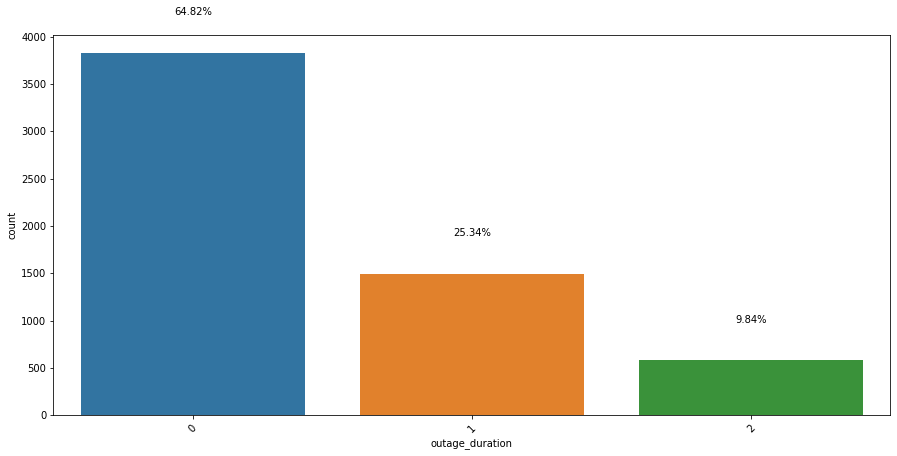

In [ ]:
barplot('outage_duration',train_data_final)

***Graphical representation of percentage of each level in target column***



Insights: ***Around 65% of outages are those that last anywhere between few minutes***

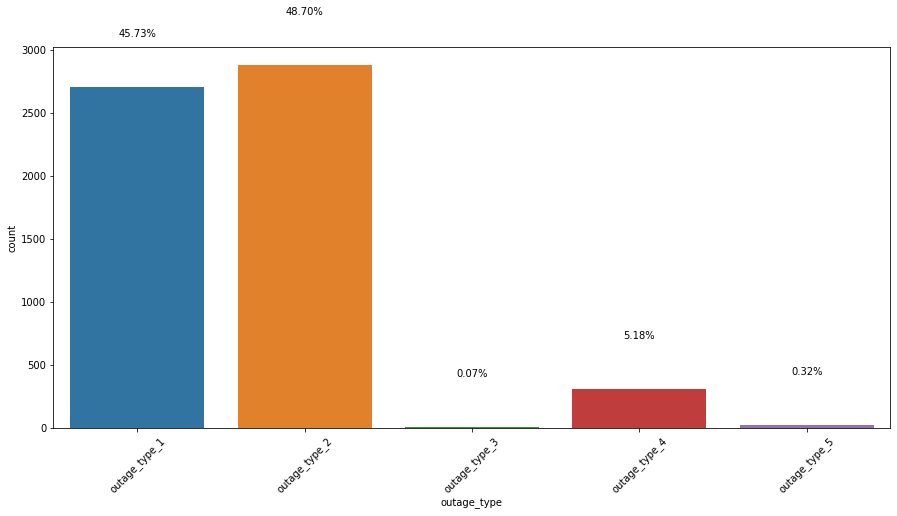

In [ ]:
barplot('outage_type',train_data_final)

***Graphical representation of percentage of each outage type in 'outage_type' column***

Insights: ***Around 95% of outages are of 'outage_type_1' and 'outage_type_2'***

In [ ]:
count = train_data_final['log_report_type'].value_counts()
count.head(50)

log_report_type_312    580
log_report_type_82     495
log_report_type_232    463
log_report_type_203    308
log_report_type_54     235
log_report_type_170    215
log_report_type_313    164
log_report_type_68     162
log_report_type_71     161
log_report_type_134    150
log_report_type_80     140
log_report_type_73     138
log_report_type_195    124
log_report_type_219    121
log_report_type_233    120
log_report_type_307    114
log_report_type_193    105
log_report_type_315     96
log_report_type_301     84
log_report_type_55      83
log_report_type_201     80
log_report_type_314     73
log_report_type_235     72
log_report_type_171     68
log_report_type_227     62
log_report_type_70      60
log_report_type_234     59
log_report_type_306     57
log_report_type_273     53
log_report_type_202     47
log_report_type_345     44
log_report_type_283     36
log_report_type_81      36
log_report_type_229     32
log_report_type_309     32
log_report_type_308     29
log_report_type_376     27
l

log_report_type_312    580
log_report_type_82     495
log_report_type_232    463
log_report_type_203    308
log_report_type_54     235
log_report_type_170    215
log_report_type_313    164
log_report_type_68     162
log_report_type_71     161
log_report_type_134    150
log_report_type_80     140
log_report_type_73     138
log_report_type_195    124
log_report_type_219    121
log_report_type_233    120
log_report_type_307    114
log_report_type_193    105
log_report_type_315     96
log_report_type_301     84
log_report_type_55      83
log_report_type_201     80
log_report_type_314     73
log_report_type_235     72
log_report_type_171     68
log_report_type_227     62
log_report_type_70      60
log_report_type_234     59
log_report_type_306     57
log_report_type_273     53
log_report_type_202     47
Name: log_report_type, dtype: int64

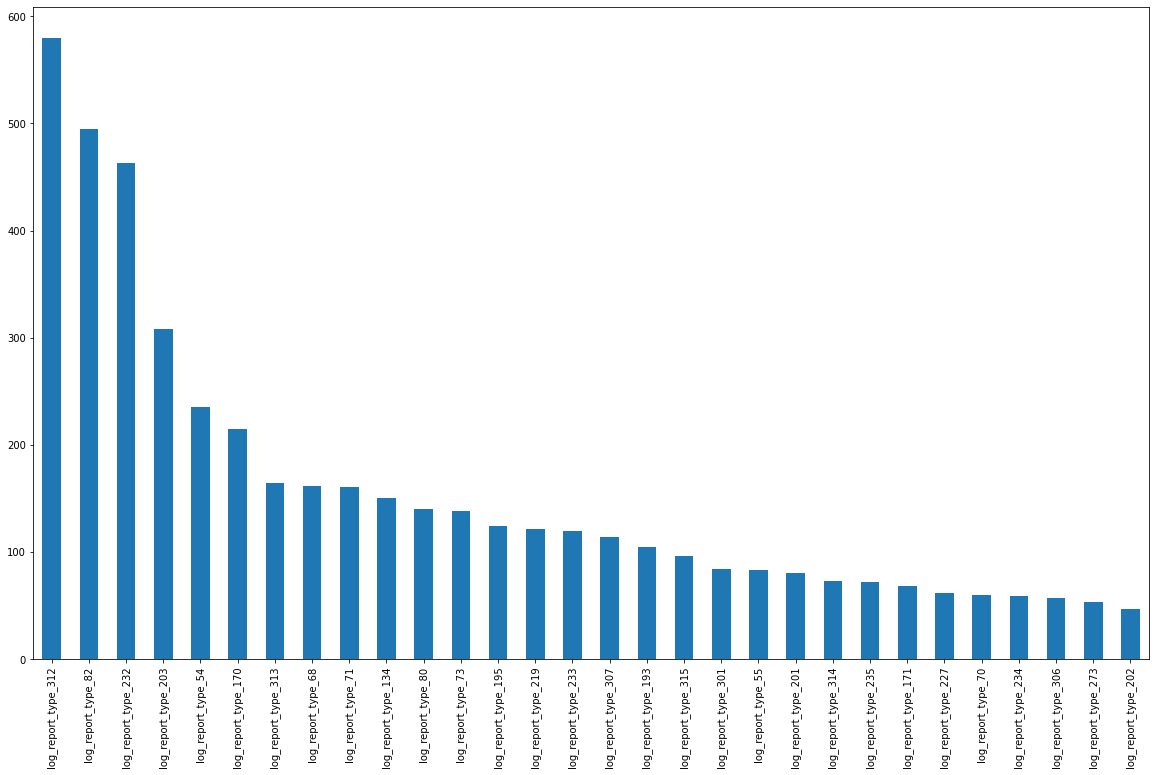

In [ ]:
#plt.figure(figsize = (14,6))
count = train_data_final['log_report_type'].value_counts()
#print(count)
###plt.show()
count.head(30).plot(kind="bar",figsize=(20,12))
count.head(30)

***Graphical representation of log report types that are repeated more than 45 times in the given dataset***

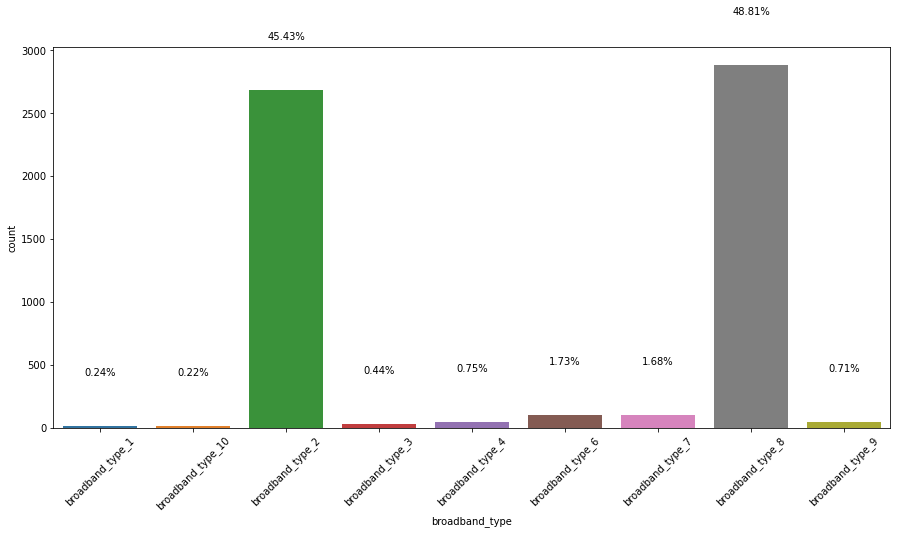

In [ ]:
barplot('broadband_type',train_data_final)

***Graphical representation of percentage of each broadband type in 'broadband_type' column***

Insights: ***Around 94% of outages are of 'broadband_type_2' and 'broadband_type_8'. These can be replaced with other broadband types that have less outages.***

transit_server_type_11    1820
transit_server_type_35    1106
transit_server_type_15     993
transit_server_type_34     984
transit_server_type_20     275
transit_server_type_13     107
transit_server_type_54     106
transit_server_type_23      75
transit_server_type_42      58
transit_server_type_44      56
transit_server_type_14      42
transit_server_type_22      32
transit_server_type_21      31
transit_server_type_43      27
transit_server_type_10      26
transit_server_type_50      21
transit_server_type_18      15
transit_server_type_30      14
transit_server_type_24      13
transit_server_type_32      12
Name: transit_server_type, dtype: int64

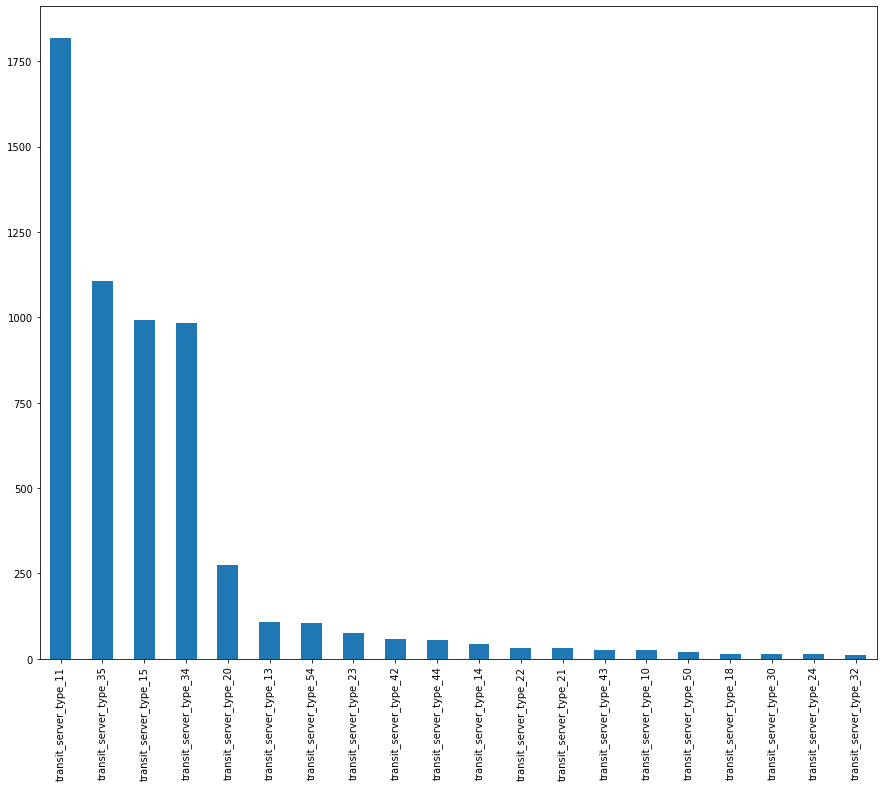

In [ ]:
#plt.figure(figsize = (14,6))
count = train_data_final['transit_server_type'].value_counts()
#print(count)
###plt.show()
count.head(20).plot(kind="bar",figsize=(15,12))
count.head(20)

***Graphical representation of top 20 transit server types that are repeated more frequently***

area_821     67
area_1107    61
area_126     59
area_734     57
area_1008    57
area_600     55
area_704     50
area_810     49
area_1052    48
area_122     47
Name: area_code, dtype: int64

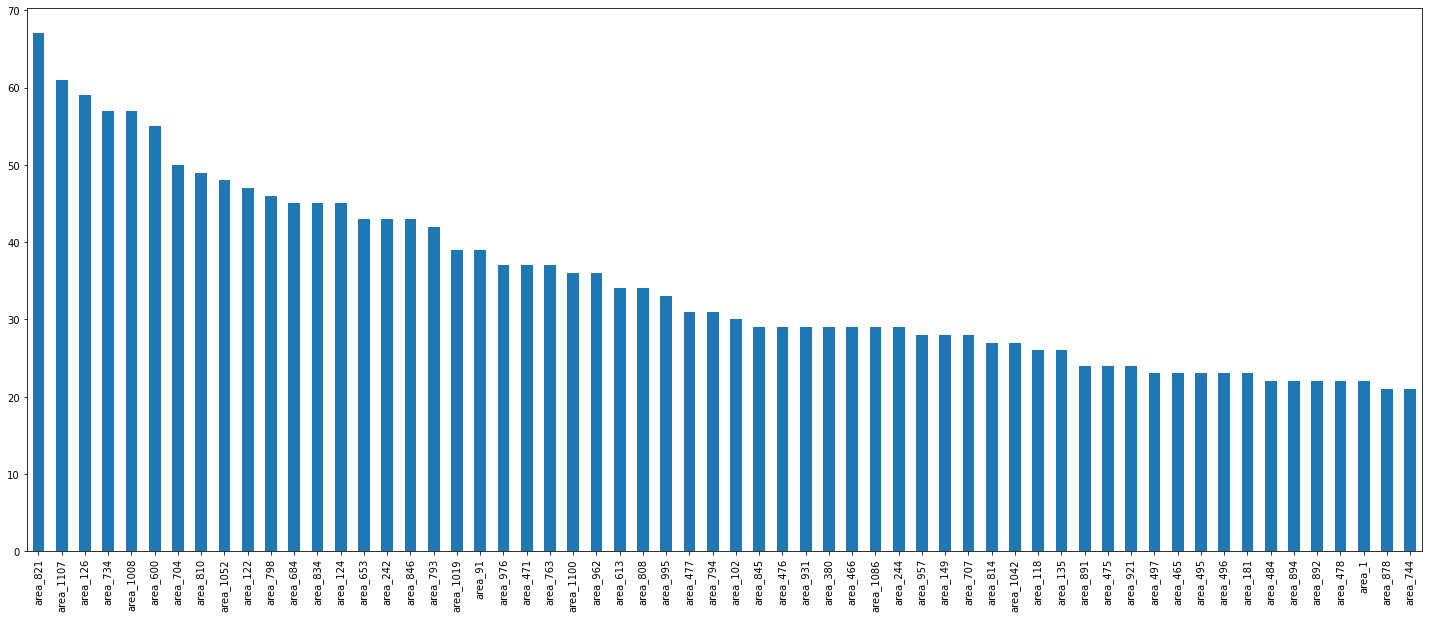

In [ ]:
#plt.figure(figsize = (14,6))
count = train_data_final['area_code'].value_counts()
#print(count)
###plt.show()
count.head(60).plot(kind="bar",figsize=(25,10))
count.head(10)

####**BIVARIATE ANALYSIS**

In [ ]:

def getProbOfisfraud(col, target, df, forGraph=True):
    crosstab = pd.crosstab(index = df[col], columns = df[target])
    crosstab.columns = pd.Index(list(crosstab.columns))
    crosstab = crosstab.reset_index() 
    crosstab['TotalCount'] = crosstab[1] + crosstab[0]
    crosstab['probisfraud'] = crosstab[1] / crosstab['TotalCount']
    
    print(crosstab.head(31))
    if forGraph:
        return crosstab[[col, 'probisfraud']]
    else:
        return crosstab[[col, 'TotalCount', 'probofisfraud']]

In [ ]:
train_data_final.columns

Index(['area_code', 'outage_duration', 'transit_server_type', 'outage_type',
       'log_report_type', 'volume', 'broadband_type'],
      dtype='object')

outage_duration     0    1    2
outage_type                    
outage_type_1    1418  900  382
outage_type_2    2129  547  199
outage_type_3       4    0    0
outage_type_4     267   39    0
outage_type_5       9   10    0

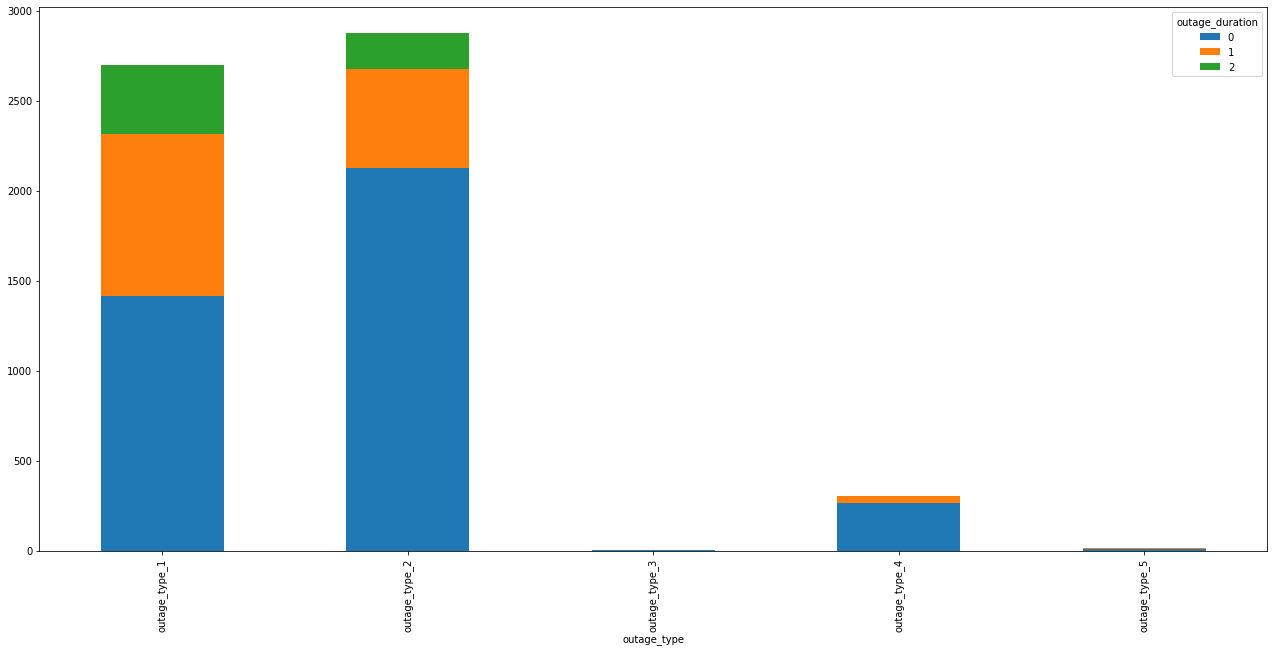

In [ ]:
#plt.figure(figsize = (16,6))
#sns.barplot(x = 'transit_server_type',y = 'outage_duration', data = getProbOfisfraud('transit_server_type', 'outage_duration',train_data_final));

#Plotting 'outage_type' with 'outage_duration'
type1 = pd.crosstab(train_data_final['outage_type'],train_data_final['outage_duration']) 
type1.plot(kind="bar", stacked = True, figsize=(22,10))
type1

***Graphical representation of outage durations against outage types***

Insights: ***In Outage types 1,2 and 3 most of the outages are those that last anywhere between few minutes***

outage_duration            0    1    2
transit_server_type                   
transit_server_type_10    10   15    1
transit_server_type_11  1050  581  189
transit_server_type_12     0    1    0
transit_server_type_13    34   60   13
transit_server_type_14    20   17    5
transit_server_type_15   427  270  296
transit_server_type_18    12    3    0
transit_server_type_2      1    3    1
transit_server_type_20   210   57    8
transit_server_type_21    20   11    0
transit_server_type_22    16   14    2
transit_server_type_23    46   29    0
transit_server_type_24     8    4    1
transit_server_type_25     1    0    0
transit_server_type_26     8    1    0
transit_server_type_27     3    2    0
transit_server_type_28     2    1    0
transit_server_type_29     2    4    0
transit_server_type_3      0    0    1
transit_server_type_30     6    8    0
transit_server_type_31     1    1    1
transit_server_type_32     7    4    1
transit_server_type_34   827  157    0
transit_server_type_35   955  151    0
transit_server_type_36     1    0    0
transit_server_type_38     3    1    1
transit_server_type_39     0    2    0
transit_server_type_40     6    1    0
transit_server_type_42    27   22    9
transit_server_type_43    16    7    4
transit_server_type_44    21   16   19
transit_server_type_45     1    1    1
transit_server_type_46     5    1    0
transit_server_type_47    10    1    0
transit_server_type_48     1    0    0
transit_server_type_49     0    0    1
transit_server_type_5      1    3    1
transit_server_type_50    14    4    3
transit_server_type_51     2    0    0
transit_server_type_54    47   38   21
transit_server_type_6      3    1    0
transit_server_type_7      1    2    2
transit_server_type_8      1    2    0
transit_server_type_9      1    0    0

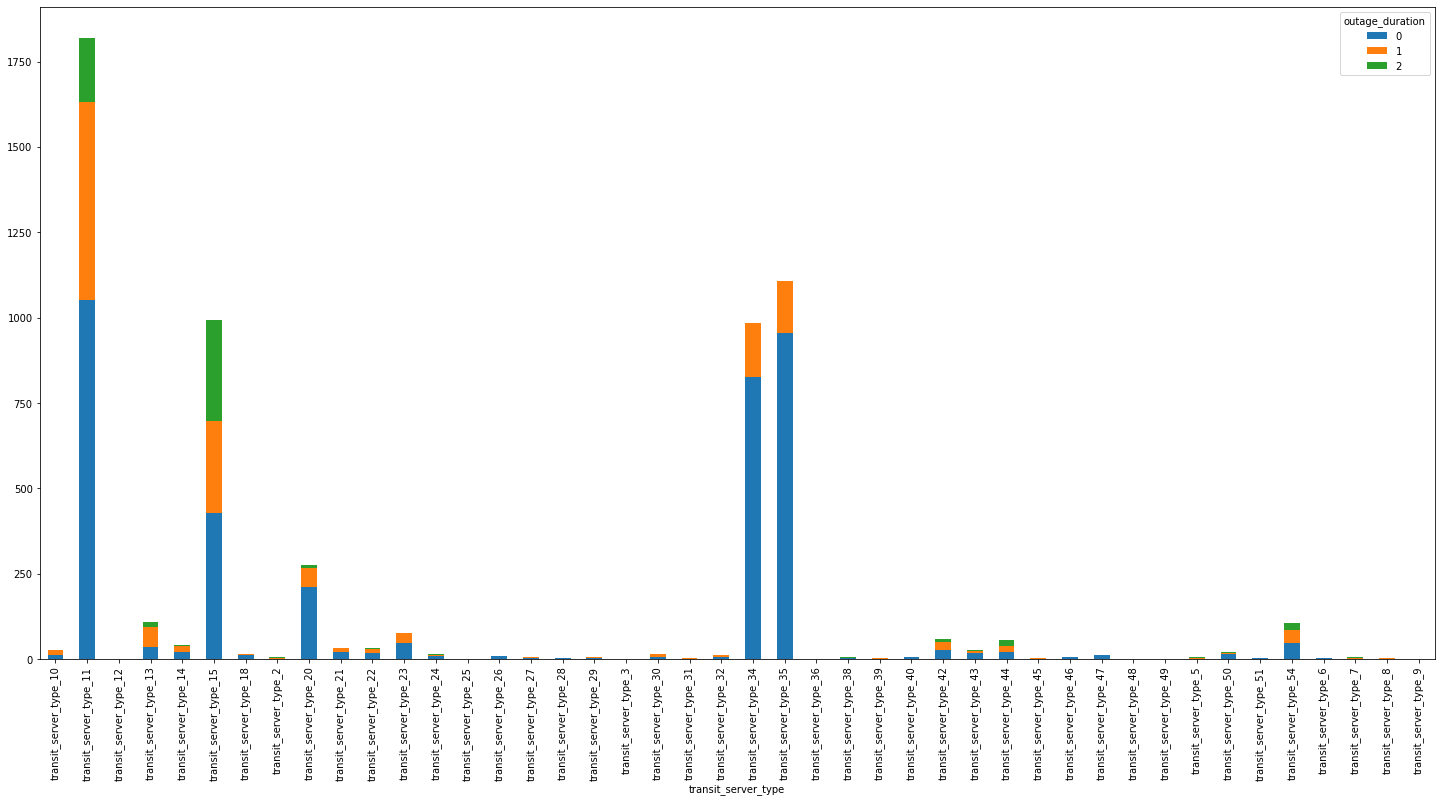

In [ ]:
type1 = pd.crosstab(train_data_final['transit_server_type'],train_data_final['outage_duration']) 
type1.plot(kind="bar", stacked = True, figsize=(25,12))
type1

***Graphical representation of outage durations against transit server types***

Insights: ***Transit server type 11 has more number of outages, out of which more number of those are short outages*** 

outage_duration    False  True 
broadband_type                 
broadband_type_1       9      5
broadband_type_10     12      1
broadband_type_2    2620     62
broadband_type_3      25      1
broadband_type_4      43      1
broadband_type_6      94      8
broadband_type_7      95      4
broadband_type_8    2384    498
broadband_type_9      41      1

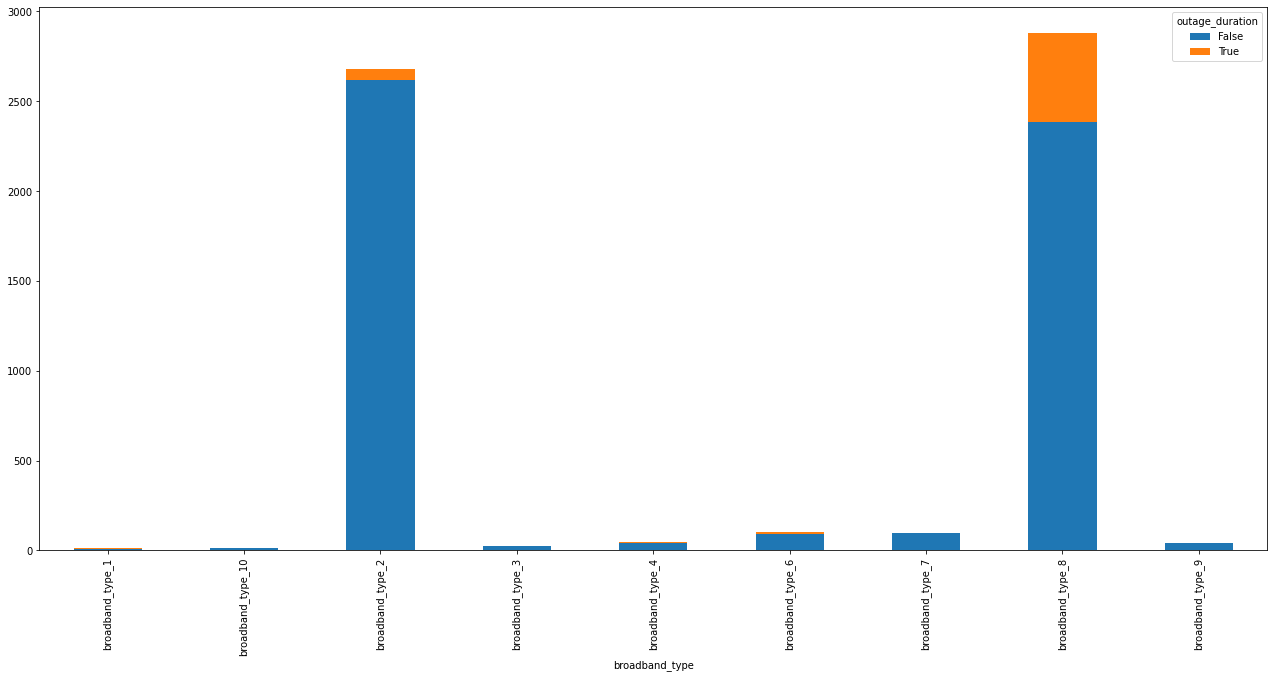

In [ ]:
type1 = pd.crosstab(train_data_final['broadband_type'],train_data_final['outage_duration'] == 2) 
type1.plot(kind="bar", stacked = True, figsize=(22,10))
type1

***Graphical representation of outage durations against broadband types***

Insights: ***Broadband type 8 has more number of outages, out of which high frequent are those which are short outages.
And broadband type 2 has more number of outages that are short as type 8***

###Performing Chisquare test of independence on categorical variables

In [ ]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

import statsmodels.api as sm

In [ ]:
cat_cols = train_data_final.select_dtypes('category').columns
cat_cols

Index(['area_code', 'outage_duration', 'transit_server_type', 'outage_type',
       'log_report_type', 'broadband_type'],
      dtype='object')

In [ ]:
def find_chi2_independence(cat_col, target, data, alpha=0.05):
    data = data[[target, cat_col]]
    tab = sm.stats.Table.from_data(data)
    tab = tab.table_orig.to_numpy()
    print(f"---------------{target} Vs {cat_col} Chi Square Test of Independence -------------------")
    print(f"\n Contingency table :\n")
    print(tab)
    
    stat, p, dof, expected = chi2_contingency(tab)
    print(f"\n Expected table :\n")
    print(expected)
    
    print(f"The p value returned = {p} and degrees of freedom returned = {dof}")
    
    # interpret p-value
    print('significance(alpha) = %.3f' % (alpha))

    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)') 

In [ ]:
for col in cat_cols:
    find_chi2_independence(col, 'outage_duration', train_data_final)

---------------outage_duration Vs area_code Chi Square Test of Independence -------------------

 Contingency table :

[[13  1 10 ...  0  4  2]
 [ 7  0  0 ...  3  4  3]
 [ 2  0  0 ...  0  1  0]]

 Expected table :

[[14.26050136  0.64820461  6.48204607 ...  1.94461382  5.83384146
   3.24102304]
 [ 5.57452575  0.25338753  2.53387534 ...  0.7601626   2.2804878
   1.26693767]
 [ 2.1649729   0.09840786  0.98407859 ...  0.29522358  0.88567073
   0.4920393 ]]
The p value returned = 4.174480859097875e-174 and degrees of freedom returned = 1750
significance(alpha) = 0.050
Dependent (reject H0)
---------------outage_duration Vs outage_duration Chi Square Test of Independence -------------------

 Contingency table :

[[3827    0    0]
 [   0 1496    0]
 [   0    0  581]]

 Expected table :

[[2480.67903117  969.71409214  376.60687669]
 [ 969.71409214  379.06775068  147.21815718]
 [ 376.60687669  147.21815718   57.17496612]]
The p value returned = 0.0 and degrees of freedom returned = 4
signific

Insights: ***Outage duration is dependent on the variables area_code, outage_duration, transit_server_type, outage_type, log_report_type, broadband_type***

###Data Preprocessing on train data

In [ ]:
train_data_basic = train_data_final

In [ ]:
train_data_basic.dtypes

area_code              category
outage_duration        category
transit_server_type    category
outage_type            category
log_report_type        category
volume                    int64
broadband_type         category
dtype: object

####Standardizing the numerical attributes and One-hot encoding categorical attributes

In [ ]:
num_attr = list(train_data_basic.select_dtypes(['int64']).columns)
# print(num_attr)
cat_attr = list(train_data_basic.select_dtypes(['category']).columns)

In [ ]:
mapper = DataFrameMapper(
  [([continuous_col], StandardScaler()) for continuous_col in num_attr] +
  [([categorical_col], OneHotEncoder(handle_unknown='error')) for categorical_col in cat_attr]
, df_out=True)

In [ ]:
print(type(mapper))

<class 'sklearn_pandas.dataframe_mapper.DataFrameMapper'>


In [ ]:
mapper.fit(train_data_basic)

train_data_basic_final = mapper.transform(train_data_basic)

####Dimensions of the dataset after Standardization and One-hot Encoding

In [ ]:
train_data_basic_final.shape

(5904, 1151)

In [ ]:
train_data_basic_final.head()

volume  ...  broadband_type_x0_broadband_type_9
0 -0.330908  ...                                 0.0
1 -0.286953  ...                                 0.0
2 -0.242999  ...                                 0.0
3 -0.330908  ...                                 0.0
4  0.943766  ...                                 0.0

[5 rows x 1151 columns]

###Data Preprocessing on Test Data

####Columns in test data

In [ ]:
test_data.columns

Index(['id', 'area_code'], dtype='object')

####Dimensions of test data

In [ ]:
test_data.shape

(1477, 2)

####Merging the other datasets with test dataset

In [ ]:
# Merging the datasets using left join
def merge_fn(df1,df2,col_name,how_param):
    merged_df=df1.merge(df2,how=how_param,on=col_name)
    return merged_df

In [ ]:
merge1 = merge_fn(test_data,server_data.drop_duplicates(subset=['id']),'id','left')
merge2 = merge_fn(merge1,outage_data.drop_duplicates(subset=['id']),'id','left')
merge3 = merge_fn(merge2,report_data.drop_duplicates(subset=['id']),'id','left')
test_data_final = merge_fn(merge3,broadband_data.drop_duplicates(subset=['id']),'id','left')

####Dimensions of the final test dataframe

In [ ]:
test_data_final.shape

(1477, 7)

####Columns in the final test dataframe

In [ ]:
test_data_final.columns

Index(['id', 'area_code', 'transit_server_type', 'outage_type',
       'log_report_type', 'volume', 'broadband_type'],
      dtype='object')

####Top 5 rows of the final test dataframe

In [ ]:
test_data_final.head()

id area_code  ... volume    broadband_type
0   3340  area_344  ...      2  broadband_type_2
1  14067  area_933  ...      1  broadband_type_2
2   1134   area_16  ...     10  broadband_type_8
3     27  area_793  ...      3  broadband_type_8
4   9793  area_344  ...     12  broadband_type_2

[5 rows x 7 columns]

####Datatype of each feature in test dataframe

In [ ]:
test_data_final.dtypes

id                      int64
area_code              object
transit_server_type    object
outage_type            object
log_report_type        object
volume                  int64
broadband_type         object
dtype: object

####Checking if there are any missing values

In [ ]:
test_data_final.isnull().sum()

id                     0
area_code              0
transit_server_type    0
outage_type            0
log_report_type        0
volume                 0
broadband_type         0
dtype: int64

***No missing values in the dataset.***

####Checking if there are any duplicate values for 'id' feature in test dataframe

In [ ]:
any(test_data_final['id'].duplicated())

False

***All the values in 'id' attribute are unique. Hence the attribute can be dropped from the dataset as the target cannot be dependent on it.***

####Dropping the 'id' attribute

In [ ]:
test_data_final.drop(['id'], axis = 1, inplace = True)
test_data1 = test_data_final

####Typecasting the features in test data

In [ ]:
col_list = ['area_code','transit_server_type','outage_type','log_report_type','broadband_type']
for i in col_list:
  test_data_final[i] = test_data_final[i].astype('category')

test_data_final.dtypes

area_code              category
transit_server_type    category
outage_type            category
log_report_type        category
volume                    int64
broadband_type         category
dtype: object

####Standardizing the numerical attributes and One-hot encoding categorical attributes

In [ ]:
num_attr = list(test_data_final.select_dtypes(['int64']).columns)
# print(num_attr)
cat_attr = list(test_data_final.select_dtypes(['category']).columns)

In [ ]:
mapper = DataFrameMapper(
  [([continuous_col], StandardScaler()) for continuous_col in num_attr] +
  [([categorical_col], OneHotEncoder(handle_unknown='error')) for categorical_col in cat_attr]
, df_out=True)

In [ ]:
mapper.fit(test_data_final)
test_data_basic_final = mapper.transform(test_data_final)

####Dimensions of the test dataset after Standardization and One-hot Encoding

In [ ]:
test_data_basic_final.shape

(1477, 717)

####Values of each attribute in test dataframe after Standardization and One-hot Encoding

In [ ]:
test_data_basic_final.head()

volume  ...  broadband_type_x0_broadband_type_9
0 -0.256644  ...                                 0.0
1 -0.294452  ...                                 0.0
2  0.045820  ...                                 0.0
3 -0.218836  ...                                 0.0
4  0.121436  ...                                 0.0

[5 rows x 717 columns]

####Checking the unique values for each attribute in train and test data

In [ ]:
col_list = ['area_code','transit_server_type','outage_type','log_report_type','broadband_type','outage_duration']
for i in range(len(col_list)):
  print(train_data_final[col_list[i]].value_counts(),'\n')

area_821     67
area_1107    61
area_126     59
area_734     57
area_1008    57
             ..
area_659      1
area_299      1
area_3        1
area_30       1
area_26       1
Name: area_code, Length: 876, dtype: int64 

transit_server_type_11    1820
transit_server_type_35    1106
transit_server_type_15     993
transit_server_type_34     984
transit_server_type_20     275
transit_server_type_13     107
transit_server_type_54     106
transit_server_type_23      75
transit_server_type_42      58
transit_server_type_44      56
transit_server_type_14      42
transit_server_type_22      32
transit_server_type_21      31
transit_server_type_43      27
transit_server_type_10      26
transit_server_type_50      21
transit_server_type_18      15
transit_server_type_30      14
transit_server_type_24      13
transit_server_type_32      12
transit_server_type_47      11
transit_server_type_26       9
transit_server_type_40       7
transit_server_type_29       6
transit_server_type_46       6
tran

In [ ]:
col_list = ['area_code','transit_server_type','outage_type','log_report_type','broadband_type']
for i in range(len(col_list)):
  print(test_data_final[col_list[i]].value_counts(),'\n')

area_734     18
area_821     18
area_810     17
area_1107    17
area_242     17
             ..
area_310      1
area_737      1
area_305      1
area_303      1
area_999      1
Name: area_code, Length: 531, dtype: int64 

transit_server_type_11    436
transit_server_type_35    296
transit_server_type_15    257
transit_server_type_34    230
transit_server_type_20     72
transit_server_type_54     33
transit_server_type_13     25
transit_server_type_23     21
transit_server_type_42     19
transit_server_type_14     11
transit_server_type_21     11
transit_server_type_10     10
transit_server_type_44      9
transit_server_type_43      8
transit_server_type_50      5
transit_server_type_40      4
transit_server_type_24      4
transit_server_type_22      4
transit_server_type_46      2
transit_server_type_18      2
transit_server_type_30      2
transit_server_type_29      2
transit_server_type_5       2
transit_server_type_27      2
transit_server_type_26      2
transit_server_type_8       1

###The operations team at small basket has asked you the following questions Which areas are most prone to long outage durations? 

*   Which areas are most prone to long outage durations?
*   Which broadband types are suspect of long outage durations?

*   Any other recommendations to improve the detection of outage durations.

#####Which areas are most prone to long outage durations?

In [ ]:
train_data_final.loc[(train_data_final.outage_duration == 2),'area_code'].value_counts().head(25)

area_1100    28
area_1107    27
area_600     27
area_821     24
area_734     23
area_704     19
area_1019    18
area_810     18
area_834     17
area_684     17
area_798     17
area_995     16
area_962     15
area_1086    14
area_653     13
area_1008    13
area_846     12
area_763     12
area_613     12
area_845     11
area_638     10
area_1042    10
area_1052    10
area_895      8
area_1075     8
Name: area_code, dtype: int64

***The above areas are the top 25 areas that are prone to long outage durations, out of which 'area_1100' is the one which is more prone to long outage durations***

####Which broadband types are suspect of long outage durations?

outage_duration    False  True 
broadband_type                 
broadband_type_1       9      5
broadband_type_10     12      1
broadband_type_2    2620     62
broadband_type_3      25      1
broadband_type_4      43      1
broadband_type_6      94      8
broadband_type_7      95      4
broadband_type_8    2384    498
broadband_type_9      41      1

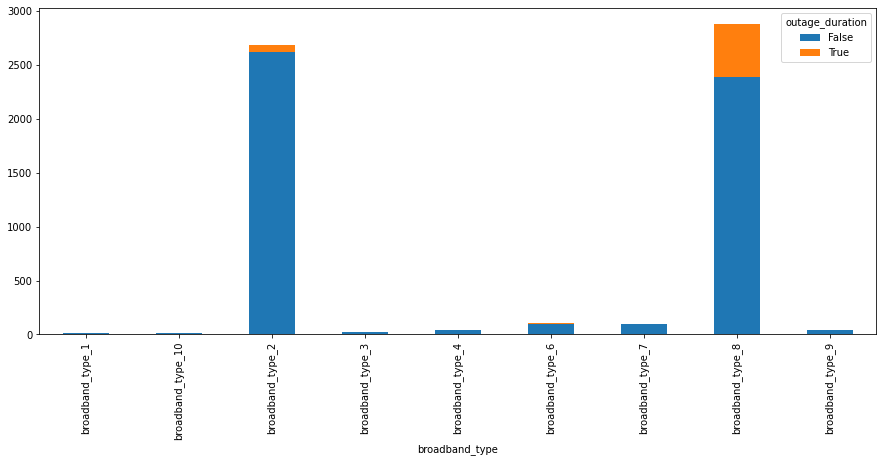

In [ ]:
type1 = pd.crosstab(train_data_final['broadband_type'],train_data_final['outage_duration'] == 2) 
type1.plot(kind="bar", stacked = True, figsize=(15,6))
type1

In [ ]:
train_data_final.loc[(train_data_final.outage_duration == 2),'broadband_type'].value_counts()

broadband_type_8     498
broadband_type_2      62
broadband_type_6       8
broadband_type_1       5
broadband_type_7       4
broadband_type_9       1
broadband_type_4       1
broadband_type_3       1
broadband_type_10      1
Name: broadband_type, dtype: int64

***The Broadband type 8 is more suspect of long outage durations.***

***Broadband type of 10% of long outage durations is broadband type 2***

#####Any other recommendations to improve the detection of outage durations.

***We can consider another factor that has the count of the customers for a particular broadband type and transit server type in an area which helps to detect the network congestion which in turn might help in detecting the outage durations i.e.,  if there is more count of it then there more scope for the area to be prone to long/medium outage durations.***

##First - Data Preprocessing and Model Building

####Reading the train and test datasets

In [ ]:
train = pd.read_csv("/content/gdrive/MyDrive/Phd exam/train_data.csv",header=0)
test = pd.read_csv("/content/gdrive/MyDrive/Phd exam/test_data.csv",header=0)

####Dimensions of test and train data after one-hot encoding

In [ ]:
test_data_basic_final.shape,  train_data_basic_final.shape # Dimensions of test and train data after one-hot encoding (from EDA)

((1477, 717), (5904, 1151))

***There is a mismatch in the dimensions of test data compared to the train data. Test data has fewer columns than train data. So, appending one data frame to another for preprocessing thus handling the mismatch.***

####Appending test dataframe to train dataframe

In [ ]:
test['outage_duration'] = -999 # adding target variable in test data and assigning a negative value to differentiate train and test rows
print('train', train.shape, 'test', test.shape)
print(train.head(3),'\n', test.head(3))
final = train.append(test) # Appending train and test data to handle mismatch in columns after one-hot encoding
print('\nDimensions of dataframe after appending test data to train data:', final.shape)
print('\nTop 3 rows in the final dataframe')
final.head(3)

train (5904, 3) test (1477, 3)
      id area_code  outage_duration
0  13366  area_415                1
1   6783  area_474                0
2   9519  area_931                1 
       id area_code  outage_duration
0   3340  area_344             -999
1  14067  area_933             -999
2   1134   area_16             -999

Dimensions of dataframe after appending test data to train data: (7381, 3)

Top 3 rows in the final dataframe


id area_code  outage_duration
0  13366  area_415                1
1   6783  area_474                0
2   9519  area_931                1

####Reading the other datasets

In [ ]:
outage_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/outage_data.csv",header=0)
broadband_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/broadband_data.csv",header=0)
report_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/report_data.csv",header=0)
server_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/server_data.csv",header=0)

####Merging the final dataframe with each other above dataframes

In [ ]:
#Defining the merge function to perform left join
def merge_fn(df1,df2,col_name,how_param):
    merged_df = df1.merge(df2,how = how_param,on = col_name)
    return merged_df

In [ ]:
final = merge_fn(final,outage_data.drop_duplicates(subset=['id']),'id','left')
merge2 = merge_fn(final,server_data.drop_duplicates(subset=['id']),'id','left')
merge3 = merge_fn(merge2,report_data.drop_duplicates(subset=['id']),'id','left')
final = merge_fn(merge3,broadband_data.drop_duplicates(subset=['id']),'id','left')

####Feature Engineering

> Creating a new feature **congestion** that defines the cumulative count of area code grouped with outage type, broadband type, and transit server type. This feature helps us in understanding the crowding of outage type, broadband type, and transit server type in an area. The more the count of congestion for each area, the more the possibility for long/medium outage durations. 



In [ ]:
final['congestion'] = final.groupby(['outage_type', 'area_code','transit_server_type','broadband_type']).cumcount()+1

####Bottom 3 rows in the final dataframe after inserting the new column

In [ ]:
final.tail(3)

id  area_code  outage_duration  ... volume    broadband_type congestion
7378  7753   area_476             -999  ...      1  broadband_type_2         19
7379   989    area_38             -999  ...      2  broadband_type_9          1
7380  3129  area_1067             -999  ...      8  broadband_type_8         10

[3 rows x 9 columns]

####Checking for missing values in the dataframe

In [ ]:
final.isnull().sum()

id                     0
area_code              0
outage_duration        0
outage_type            0
transit_server_type    0
log_report_type        0
volume                 0
broadband_type         0
congestion             0
dtype: int64

***No missing values in the dataframe***

####Checking the datatypes and Typecasting the obvious ones

In [ ]:
final.dtypes

id                      int64
area_code              object
outage_duration         int64
outage_type            object
transit_server_type    object
log_report_type        object
volume                  int64
broadband_type         object
congestion              int64
dtype: object

In [ ]:
col_list = ['area_code','transit_server_type','outage_type','log_report_type','broadband_type','outage_duration']
for i in col_list:
  final[i] = final[i].astype('category')

***All the values in 'id' attribute are unique. Hence the attribute can be dropped from the dataset as the target cannot be dependent on it.***

In [ ]:
final.drop('id', axis=1, inplace = True)

####Standardizing the numerical attributes and One-hot encoding categorical attributes

In [ ]:
cat_attr = ['area_code','transit_server_type','outage_type','log_report_type','broadband_type']
num_attr = ['congestion','volume']

In [ ]:
mapper = DataFrameMapper(
  [([continuous_col], StandardScaler()) for continuous_col in num_attr] +
  [([categorical_col], OneHotEncoder(handle_unknown='error')) for categorical_col in cat_attr]
, df_out=True)

In [ ]:
print(type(mapper))

<class 'sklearn_pandas.dataframe_mapper.DataFrameMapper'>


In [ ]:
mapper.fit(final)

train_final = mapper.transform(final)

####Values of each attribute in test dataframe after Standardization and One-hot Encoding

In [ ]:
train_final.head(3)

congestion  ...  broadband_type_x0_broadband_type_9
0   -0.652219  ...                                 0.0
1   -0.652219  ...                                 0.0
2   -0.652219  ...                                 0.0

[3 rows x 1214 columns]

In [ ]:
train_final['outage_duration'] = final['outage_duration']

####Segregating train data and test data

In [ ]:
train_df = train_final.loc[train_final.outage_duration != -999 ]
test_df=train_final.loc[train_final.outage_duration == -999 ]
train_df.shape,test_df.shape

((5904, 1215), (1477, 1215))

####Dropping the target attribute(outage duration from test dataframe

In [ ]:
test_df = test_df.drop('outage_duration',1)

###Splitting the train_df dataframe as train and validation data

In [ ]:
X, y = train_df.loc[:,train_df.columns!='outage_duration'], train_df.loc[:,'outage_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify =y,random_state=3)

###**Model Building**

###**Naive Bayes Model**

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Creating a Gaussian Classifier
gnb = GaussianNB()

# Training the model using the training sets
gnb.fit(X_train, y_train)

# Predicting the target for validation dataset
y_pred = gnb.predict(X_test)

####Train and validation target predictions using Naive Bayes

In [ ]:
train_pred = gnb.predict(X_train)
test_pred = gnb.predict(X_test)

####Accuracy of the model

In [ ]:
# Importing metrics module for calculating the accuracy
from sklearn import metrics

# Model Accuracy, assessing the performance of the model.
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4904063205417607


####Classification report for predictions on train and validation data

In [ ]:
print('\n---------------------- On Train Data ----------------------\n')
print(classification_report(y_train,train_pred))
print('\n---------------------- On Validation Data ----------------------\n')
print(classification_report(y_test,test_pred))


---------------------- On Train Data ----------------------

              precision    recall  f1-score   support

           0       1.00      0.50      0.67      2678
           1       0.44      0.66      0.53      1047
           2       0.34      1.00      0.51       407

    accuracy                           0.59      4132
   macro avg       0.59      0.72      0.57      4132
weighted avg       0.79      0.59      0.62      4132


---------------------- On Validation Data ----------------------

              precision    recall  f1-score   support

           0       0.88      0.44      0.59      1149
           1       0.34      0.47      0.39       449
           2       0.26      0.87      0.40       174

    accuracy                           0.49      1772
   macro avg       0.49      0.59      0.46      1772
weighted avg       0.68      0.49      0.52      1772



####F1 macro Average for each model

In [ ]:
scores = [['Naive Bayes',f1_score(y_train,train_pred, average='macro'),f1_score(y_test,test_pred, average='macro')]]
scores = pd.DataFrame(scores, columns = ['Model', 'Train_F1_Macro_Average_Score', 'Validation_F1_Macro_Average_Score'])

In [ ]:
scores

Model  Train_F1_Macro_Average_Score  Validation_F1_Macro_Average_Score
0  Naive Bayes                      0.569555                           0.461467

###**Logistic Regression**

In [ ]:
log_mod = LogisticRegression(random_state=123)

In [ ]:
log_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

####Train and validation target predictions using Logistic Regression

In [ ]:
y_pred_train = log_mod.predict(X_train)
y_pred_val = log_mod.predict(X_test)

####Accuracy of the model

In [ ]:
# Importing metrics module for calculating the accuracy
from sklearn import metrics

# Model Accuracy, assessing the performance of the model.
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_val))

Accuracy: 0.6975169300225733


####Classification report for predictions on train and validation data

In [ ]:
print('\n---------------------- On Train Data ----------------------\n')
print(classification_report(y_train,y_pred_train))
print('\n---------------------- On Validation Data ----------------------\n')
print(classification_report(y_test,y_pred_val))


---------------------- On Train Data ----------------------

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2678
           1       0.71      0.57      0.63      1047
           2       0.64      0.47      0.54       407

    accuracy                           0.79      4132
   macro avg       0.73      0.65      0.68      4132
weighted avg       0.78      0.79      0.78      4132


---------------------- On Validation Data ----------------------

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      1149
           1       0.52      0.38      0.44       449
           2       0.51      0.33      0.40       174

    accuracy                           0.70      1772
   macro avg       0.60      0.53      0.55      1772
weighted avg       0.67      0.70      0.68      1772



In [ ]:
scores = scores.append(pd.Series(['Logistic Regression',f1_score(y_train,y_pred_train, average='macro'),f1_score(y_test,y_pred_val, average='macro')], index=scores.columns ), 
                                  ignore_index=True)
scores

Model  ...  Validation_F1_Macro_Average_Score
0          Naive Bayes  ...                           0.461467
1  Logistic Regression  ...                           0.549739

[2 rows x 3 columns]

***F1 Macro Average has increased with logistic regression model***

###**Logistic Regression with class_weight = 'balanced'**

In [ ]:
log_mod_b = LogisticRegression(class_weight='balanced', random_state=123)

In [ ]:
log_mod_b.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

####Train and validation target predictions using logistic regression with class weight balanced

In [ ]:
y_pred_train = log_mod_b.predict(X_train)
y_pred_val = log_mod_b.predict(X_test)

####Accuracy of the model

In [ ]:
# Importing metrics module for calculating the accuracy
from sklearn import metrics

# Model Accuracy, assessing the performance of the model.
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_val))

Accuracy: 0.6585778781038375


####Classification report for predictions on train and validation data

In [ ]:
print('\n---------------------- On Train Data ----------------------\n')
print(classification_report(y_train,y_pred_train))
print('\n---------------------- On Validation Data ----------------------\n')
print(classification_report(y_test,y_pred_val))


---------------------- On Train Data ----------------------

              precision    recall  f1-score   support

           0       0.95      0.74      0.83      2678
           1       0.63      0.72      0.67      1047
           2       0.44      0.94      0.60       407

    accuracy                           0.75      4132
   macro avg       0.68      0.80      0.70      4132
weighted avg       0.82      0.75      0.77      4132


---------------------- On Validation Data ----------------------

              precision    recall  f1-score   support

           0       0.87      0.70      0.78      1149
           1       0.49      0.53      0.50       449
           2       0.35      0.71      0.47       174

    accuracy                           0.66      1772
   macro avg       0.57      0.65      0.58      1772
weighted avg       0.72      0.66      0.68      1772



In [ ]:
scores = scores.append(pd.Series(['Logistic Regression_Balanced',f1_score(y_train,y_pred_train, average='macro'),f1_score(y_test,y_pred_val, average='macro')], index=scores.columns ), 
                                  ignore_index=True)
scores

Model  ...  Validation_F1_Macro_Average_Score
0                   Naive Bayes  ...                           0.461467
1           Logistic Regression  ...                           0.549739
2  Logistic Regression_Balanced  ...                           0.582766

[3 rows x 3 columns]

***F1 Macro Average on train data has increased with class weight balanced logistic regression model, but not much increase for test data which indicates that the model has some overfitting.***

###**Decision Tree**

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

####Accuracy of the model

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6664785553047404


####Train and validation target predictions using Decision Tree

In [ ]:
x_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

####Classification report for predictions on train and validation data

In [ ]:
print('\n---------------------- On Train Data ----------------------\n')
print(classification_report(y_train,x_pred))
print('\n---------------------- On Validation Data ----------------------\n')
print(classification_report(y_test,y_pred))


---------------------- On Train Data ----------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2678
           1       1.00      1.00      1.00      1047
           2       1.00      1.00      1.00       407

    accuracy                           1.00      4132
   macro avg       1.00      1.00      1.00      4132
weighted avg       1.00      1.00      1.00      4132


---------------------- On Validation Data ----------------------

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      1149
           1       0.47      0.46      0.46       449
           2       0.41      0.39      0.40       174

    accuracy                           0.67      1772
   macro avg       0.55      0.54      0.55      1772
weighted avg       0.66      0.67      0.66      1772



In [ ]:
scores = scores.append(pd.Series(['Decision Tree',f1_score(y_train,x_pred, average='macro'),f1_score(y_test,y_pred, average='macro')], 
                                 index=scores.columns ), ignore_index=True)
scores

Model  ...  Validation_F1_Macro_Average_Score
0                   Naive Bayes  ...                           0.461467
1           Logistic Regression  ...                           0.549739
2  Logistic Regression_Balanced  ...                           0.582766
3                 Decision Tree  ...                           0.547270

[4 rows x 3 columns]

***From the above dataframe, the model has fitted close to train data compared to the test data***

###**Decision Tree with class weight balanced**

In [ ]:
clf_dt_balanced = DecisionTreeClassifier(random_state=123, class_weight = 'balanced')

In [ ]:
clf_dt_balanced.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

####Train and validation target predictions using Decision Tree with class weight balanced

In [ ]:
y_pred_train = clf_dt_balanced.predict(X_train)
y_pred_val = clf_dt_balanced.predict(X_test)

####Accuracy of the model

In [ ]:
# Model Accuracy, assessing the performance of the model.
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_val))

Accuracy: 0.6247178329571106


####Classification report for predictions on train and validation data

In [ ]:
print('\n---------------------- On Train Data ----------------------\n')
print(classification_report(y_train, y_pred_train))
print('\n---------------------- On Validation Data ----------------------\n')
print(classification_report(y_test, y_pred_val))


---------------------- On Train Data ----------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2678
           1       1.00      1.00      1.00      1047
           2       1.00      1.00      1.00       407

    accuracy                           1.00      4132
   macro avg       1.00      1.00      1.00      4132
weighted avg       1.00      1.00      1.00      4132


---------------------- On Validation Data ----------------------

              precision    recall  f1-score   support

           0       0.77      0.71      0.74      1149
           1       0.43      0.48      0.45       449
           2       0.35      0.41      0.38       174

    accuracy                           0.62      1772
   macro avg       0.52      0.54      0.52      1772
weighted avg       0.64      0.62      0.63      1772



In [ ]:
scores = scores.append(pd.Series(['Decision Tree_Balanced',f1_score(y_train, y_pred_train, average='macro'),f1_score(y_test, y_pred_val, average='macro')], 
                                 index=scores.columns ), ignore_index=True)
scores

Model  ...  Validation_F1_Macro_Average_Score
0                   Naive Bayes  ...                           0.461467
1           Logistic Regression  ...                           0.549739
2  Logistic Regression_Balanced  ...                           0.582766
3                 Decision Tree  ...                           0.547270
4        Decision Tree_Balanced  ...                           0.523747

[5 rows x 3 columns]

***From the above dataframe, the model has fitted close to train data compared to the test data***

####Feature Importances

> ***The relative importance of each feature when making a prediction.***



In [ ]:
clf.feature_importances_

array([0.1092395 , 0.10673799, 0.00241948, ..., 0.00209022, 0.00290731,
       0.00047825])

In [ ]:
features = X_train.columns
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

pd.set_option('max_columns',None)
pd.DataFrame([X_train.columns[indices],np.sort(importances)[::-1]])

0         1                                   2     \
0  congestion    volume  broadband_type_x0_broadband_type_2   
1    0.109239  0.106738                            0.059519   

                                     3                             4     \
0  log_report_type_x0_log_report_type_203  outage_type_x0_outage_type_1   
1                               0.0246629                     0.0207962   

                           5                                      6     \
0  outage_type_x0_outage_type_2  log_report_type_x0_log_report_type_73   
1                      0.018199                              0.0155391   

                                     7     \
0  log_report_type_x0_log_report_type_195   
1                               0.0124232   

                                            8     \
0  transit_server_type_x0_transit_server_type_15   
1                                     0.00966361   

                                    9                             10    \
0  log_report_type_x0_log_report_type_71  outage_type_x0_outage_type_4   
1                             0.00869689                    0.00823466   

                     11                                             12    \
0  area_code_x0_area_1100  transit_server_type_x0_transit_server_type_11   
1              0.00814472                                     0.00736989   

                                    13    \
0  log_report_type_x0_log_report_type_82   
1                             0.00724614   

                                     14    \
0  log_report_type_x0_log_report_type_201   
1                              0.00681935   

                                            15    \
0  transit_server_type_x0_transit_server_type_54   
1                                     0.00680756   

                                     16                     17    \
0  log_report_type_x0_log_report_type_170  area_code_x0_area_995   
1                              0.00675176             0.00660002   

                    18                                      19    \
0  area_code_x0_area_821  log_report_type_x0_log_report_type_193   
1               0.005895                               0.0056189   

                     20                                     21    \
0  area_code_x0_area_1052  log_report_type_x0_log_report_type_54   
1              0.00540206                             0.00519239   

                    22                                     23    \
0  area_code_x0_area_684  log_report_type_x0_log_report_type_70   
1               0.005111                             0.00504744   

                    24                                      25    \
0  area_code_x0_area_895  log_report_type_x0_log_report_type_134   
1             0.00443347                              0.00437707   

                                    26                     27    \
0  log_report_type_x0_log_report_type_80  area_code_x0_area_921   
1                             0.00436784             0.00436716   

                     28                      29                      30    \
0  area_code_x0_area_1019  area_code_x0_area_1008  area_code_x0_area_1086   
1               0.0043132              0.00413998              0.00413066   

                    31                     32                     33    \
0  area_code_x0_area_798  area_code_x0_area_734  area_code_x0_area_845   
1             0.00404929             0.00391433             0.00389278   

                     34                                             35    \
0  area_code_x0_area_1107  transit_server_type_x0_transit_server_type_34   
1              0.00382015                                      0.0037019   

                    36                     37                     38    \
0  area_code_x0_area_600  area_code_x0_area_704  area_code_x0_area_976   
1             0.00357962             0.00354396             0.00348446   

                    39                                      40    \


In [ ]:
importances = pd.DataFrame([X_train.columns[indices],np.sort(importances)[::-1]])

####Top 30 important features in the model

In [ ]:
importances1 = importances.loc[:,:30]
importances1

0         1                                   2   \
0  congestion    volume  broadband_type_x0_broadband_type_2   
1    0.109239  0.106738                            0.059519   

                                       3                             4   \
0  log_report_type_x0_log_report_type_203  outage_type_x0_outage_type_1   
1                               0.0246629                     0.0207962   

                             5                                      6   \
0  outage_type_x0_outage_type_2  log_report_type_x0_log_report_type_73   
1                      0.018199                              0.0155391   

                                       7   \
0  log_report_type_x0_log_report_type_195   
1                               0.0124232   

                                              8   \
0  transit_server_type_x0_transit_server_type_15   
1                                     0.00966361   

                                      9                             10  \
0  log_report_type_x0_log_report_type_71  outage_type_x0_outage_type_4   
1                             0.00869689                    0.00823466   

                       11                                             12  \
0  area_code_x0_area_1100  transit_server_type_x0_transit_server_type_11   
1              0.00814472                                     0.00736989   

                                      13  \
0  log_report_type_x0_log_report_type_82   
1                             0.00724614   

                                       14  \
0  log_report_type_x0_log_report_type_201   
1                              0.00681935   

                                              15  \
0  transit_server_type_x0_transit_server_type_54   
1                                     0.00680756   

                                       16                     17  \
0  log_report_type_x0_log_report_type_170  area_code_x0_area_995   
1                              0.00675176             0.00660002   

                      18                                      19  \
0  area_code_x0_area_821  log_report_type_x0_log_report_type_193   
1               0.005895                               0.0056189   

                       20                                     21  \
0  area_code_x0_area_1052  log_report_type_x0_log_report_type_54   
1              0.00540206                             0.00519239   

                      22                                     23  \
0  area_code_x0_area_684  log_report_type_x0_log_report_type_70   
1               0.005111                             0.00504744   

                      24                                      25  \
0  area_code_x0_area_895  log_report_type_x0_log_report_type_134   
1             0.00443347                              0.00437707   

                                      26                     27  \
0  log_report_type_x0_log_report_type_80  area_code_x0_area_921   
1                             0.00436784             0.00436716   

                       28                      29                      30  
0  area_code_x0_area_1019  area_code_x0_area_1008  area_code_x0_area_1086  
1               0.0043132              0.00413998              0.00413066

***Feature that is playing an important role while making a prediction - Congestion***

In [ ]:
indices = np.argsort(importances1)[::-1]
pd.set_option('max_columns',None)
#pd.DataFrame([X_train.columns[indices],np.sort(importances1)[::-1]])

In [ ]:
'''plt.figure(figsize = (12,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances1[indices], color='blue')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig('imp_feat.png')'''

"plt.figure(figsize = (12,10))\nplt.title('Feature Importances')\nplt.barh(range(len(indices)), importances1[indices], color='blue')\nplt.yticks(range(len(indices)), [features[i] for i in indices])\nplt.xlabel('Relative Importance')\nplt.savefig('imp_feat.png')"

###Random Forest

In [ ]:
# Creating Random Forest classifer object
rf = RandomForestClassifier()

# Training Random Forest Classifer
rf = rf.fit(X_train,y_train)

# Predicting the response for test dataset
y_pred = rf.predict(X_test)

In [ ]:
#Model Accuracy, assessing the performance of the model.
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6930022573363431


####Train and validation target predictions using Random Forest

In [ ]:
x_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)

####Classification report for predictions on train and validation data

In [ ]:
print('\n--------------------- On Train Data ---------------------\n')
print(classification_report(y_train,x_pred))
print('\n--------------------- On Validation Data ---------------------\n')
print(classification_report(y_test,y_pred))


--------------------- On Train Data ---------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2678
           1       1.00      1.00      1.00      1047
           2       1.00      1.00      1.00       407

    accuracy                           1.00      4132
   macro avg       1.00      1.00      1.00      4132
weighted avg       1.00      1.00      1.00      4132


--------------------- On Validation Data ---------------------

              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1149
           1       0.52      0.37      0.43       449
           2       0.41      0.30      0.35       174

    accuracy                           0.69      1772
   macro avg       0.56      0.52      0.53      1772
weighted avg       0.67      0.69      0.67      1772



In [ ]:
scores = scores.append(pd.Series(['Random_Forest',f1_score(y_train, x_pred, average='macro'),f1_score(y_test, y_pred, average='macro')], 
                                 index=scores.columns ), ignore_index=True)
scores

Model  Train_F1_Macro_Average_Score  \
0                   Naive Bayes                      0.569555   
1           Logistic Regression                      0.680966   
2  Logistic Regression_Balanced                      0.702275   
3                 Decision Tree                      1.000000   
4        Decision Tree_Balanced                      1.000000   
5                 Random_Forest                      1.000000   

   Validation_F1_Macro_Average_Score  
0                           0.461467  
1                           0.549739  
2                           0.582766  
3                           0.547270  
4                           0.523747  
5                           0.531918

##Second - Data Preprocessing and Model Building

####Reading the DATASETS

In [ ]:
broadband_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/broadband_data.csv",header=0)
outage_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/outage_data.csv",header=0)
report_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/report_data.csv",header=0)
server_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/server_data.csv",header=0)

In [ ]:
train = pd.read_csv("/content/gdrive/MyDrive/Phd exam/train_data.csv",header=0)
test = pd.read_csv("/content/gdrive/MyDrive/Phd exam/test_data.csv",header=0)

***Due to mismatch in the dimensions of test data compared to the train data after one-hot encoding( Test data has fewer columns than train data) appending one data frame to another for preprocessing thus handling the mismatch.***

In [ ]:
test['outage_duration'] = -999 # adding target variable in test data and assigning a negative value to differentiate train and test rows
print('train', train.shape, 'test', test.shape)
print(train.head(3),'\n', test.head(3))
final = train.append(test) # Appending train and test data to handle mismatch in columns after one-hot encoding
print(final.shape)
final.head(3)

train (5904, 3) test (1477, 3)
      id area_code  outage_duration
0  13366  area_415                1
1   6783  area_474                0
2   9519  area_931                1 
       id area_code  outage_duration
0   3340  area_344             -999
1  14067  area_933             -999
2   1134   area_16             -999
(7381, 3)


id area_code  outage_duration
0  13366  area_415                1
1   6783  area_474                0
2   9519  area_931                1

####Separating the area code value 

In [ ]:
final['area_code'] = final.area_code.apply(lambda x: int(x.split('area_')[1]))
final.head(3)

id  area_code  outage_duration
0  13366        415                1
1   6783        474                0
2   9519        931                1

####Feature Engineering: 

> Considering a feature area count that has the frequency of each area code in the dataset



In [ ]:
area_count = final.groupby('area_code').count()[['id']]
area_count.columns = ['area_count']
final = pd.merge(final, area_count, how='inner', left_on='area_code', right_index=True) #Merging area count with final dataframe
print(final.shape)
final.head(3)

(7381, 4)


id  area_code  outage_duration  area_count
0     13366        415                1           6
1773   8911        415                1           6
3368   4883        415                1           6

In [ ]:
print(np.sort(pd.unique(final.area_count))[::-1]) # Unique values of area count feature in ascending order

[85 78 75 71 66 64 61 60 59 58 56 55 54 53 52 51 50 49 48 45 44 43 41 40
 39 38 36 35 33 32 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13
 12 11 10  9  8  7  6  5  4  3  2  1]


####Considering only the areas that have the area count more than 20

In [ ]:
frequent_areas = area_count[area_count['area_count'] > 20]
print(frequent_areas)

           area_count
area_code            
1                  24
7                  24
9                  27
91                 49
95                 25
...               ...
1075               28
1086               33
1099               23
1100               45
1107               78

[94 rows x 1 columns]


In [ ]:
frequent_area_records = final[final['area_code'].isin(frequent_areas.index)].copy() # copying the records that have the area count greater than 20
frequent_area_records['value'] = 1 #creating a column 'value' to make use of it in pivot table
frequent_area_records.head(3)

id  area_code  outage_duration  area_count  value
2    9519        931                1          33      1
376  6575        931                0          33      1
421  4238        931                0          33      1

Creating pivot table for 'frequent_area_records' area code column

In [ ]:
# creating pivot table for area code column using id as index and values for each area code to be taken from value column
area_pivot = frequent_area_records.pivot(index='id', columns='area_code', values='value') 
# The each value of area code in frequent_area_records becomes the column and value will be 1/null for a cell (rows are made columns and columns as rows)
# print(area_pivot)
area_pivot.columns = ['location_%i' % c for c in area_pivot.columns] # renaming the column names by prefixing with 'location_'
print('area_pivot', area_pivot.shape,'\t\tfrequent_area_records',frequent_area_records.shape)

area_pivot (3391, 94) 		frequent_area_records (3391, 5)


In [ ]:
# Merging the pivot table of frequent area records with final dataframe
final = pd.merge(final, area_pivot, how='left', left_on='id', right_index=True)
print(final.shape)
final.head(3)

(7381, 98)


id  area_code  outage_duration  area_count  location_1  location_7  \
0     13366        415                1           6         NaN         NaN   
1773   8911        415                1           6         NaN         NaN   
3368   4883        415                1           6         NaN         NaN   

      location_9  location_91  location_95  location_102  location_118  \
0            NaN          NaN          NaN           NaN           NaN   
1773         NaN          NaN          NaN           NaN           NaN   
3368         NaN          NaN          NaN           NaN           NaN   

      location_122  location_124  location_126  location_135  location_149  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_155  location_157  location_181  location_242  location_244  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_373  location_380  location_445  location_460  location_465  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_466  location_468  location_469  location_471  location_475  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_476  location_477  location_478  location_479  location_484  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_485  location_488  location_495  location_496  location_497  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_504  location_505  location_506  location_584  location_599  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_600  location_613  location_627  location_638  location_644  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_653  location_684  location_691  location_704  location_707  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_734  location_744  location_756  location_760  location_763  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_793  location_794  location_798  location_805  location_808  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           Na

The frequency of each server type in the dataset

In [ ]:
server_type_count = server_data.groupby('transit_server_type').count()[['id']] # The frequency of each server type in the dataset
print(np.sort(pd.unique(server_type_count.id))[::-1]) # Unique values of server type count in ascending order

[7888 6615 5927 4395 1458  684  582  478  466  429  330  306  223  154
  145  136   73   69   65   63   60   53   46   44   42   40   38   37
   32   29   28   26   24   19   18   17   14   10    6    5    4    3
    2    1]


In [ ]:
server_type_count.head(3)

id
transit_server_type         
transit_server_type_1      4
transit_server_type_10   145
transit_server_type_11  7888

####Considering only the transit server types that have the count more than 15

In [ ]:
frequent_servers = server_type_count[server_type_count['id'] > 15]
# copying the records that are of transit server types which have count greater than 15
frequent_server_records = server_data[server_data['transit_server_type'].isin(frequent_servers.index)].copy() 
frequent_server_records['value'] = 1 #creating a column 'value' to make use of it in pivot table

In [ ]:
frequent_server_records.head(3) # the records that are of transit server types which have count greater than 15

id     transit_server_type  value
0  6597  transit_server_type_11      1
1  8011  transit_server_type_15      1
2  2597  transit_server_type_15      1

In [ ]:
# creating pivot table for the records that are of transit server types which have count greater than 15 using id as index
server_pivot = frequent_server_records.pivot(index='id', columns='transit_server_type', values='value')
# The each value of server type in frequent_server_records becomes the column and value will be 1/null for a cell (rows are made columns and columns as rows)
server_pivot.columns = map(lambda x: x.replace(' ', '_'), server_pivot.columns) # renaming the column names 
print('server_pivot', server_pivot.shape)

server_pivot (18538, 39)


In [ ]:
server_pivot.head(3)

transit_server_type_10  transit_server_type_11  transit_server_type_13  \
id                                                                           
1                      NaN                     1.0                     1.0   
2                      NaN                     NaN                     NaN   
3                      NaN                     1.0                     NaN   

    transit_server_type_14  transit_server_type_15  transit_server_type_18  \
id                                                                           
1                      NaN                     NaN                     NaN   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   

    transit_server_type_2  transit_server_type_20  transit_server_type_21  \
id                                                                          
1                     NaN                     NaN                     NaN   
2                     NaN                     NaN                     NaN   
3                     NaN                     NaN                     NaN   

    transit_server_type_22  transit_server_type_23  transit_server_type_24  \
id                                                                           
1                      NaN                     NaN                     NaN   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   

    transit_server_type_26  transit_server_type_27  transit_server_type_28  \
id                                                                           
1                      NaN                     NaN                     NaN   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   

    transit_server_type_29  transit_server_type_3  transit_server_type_30  \
id                                                                          
1                      NaN                    NaN                     NaN   
2                      NaN                    NaN                     NaN   
3                      NaN                    NaN                     NaN   

    transit_server_type_32  transit_server_type_34  transit_server_type_35  \
id                                                                           
1                      NaN                     NaN                     NaN   
2                      NaN                     1.0                     1.0   
3                      NaN                     NaN                     NaN   

    transit_server_type_36  transit_server_type_38  transit_server_type_39  \
id                                                                           
1                      NaN                     NaN                     NaN   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   

    transit_server_type_40  transit_server_type_42  transit_server_type_43  \
id                                                                           
1                      NaN                     NaN                     NaN   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   

    transit_server_type_44  transit_server_type_45  transit_server_type_46  \
id                                                                           
1                      NaN                     NaN                     NaN   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   

    transit_server_type_47  transit_server_type_49  transit_server_type_5  \
id                         

In [ ]:
final = pd.merge(final, server_pivot, how='left', left_on='id', right_index=True) # Merging the pivot table of frequent server type records with final dataframe
print(final.shape) 
final.head(3)

(7381, 137)


id  area_code  outage_duration  area_count  location_1  location_7  \
0     13366        415                1           6         NaN         NaN   
1773   8911        415                1           6         NaN         NaN   
3368   4883        415                1           6         NaN         NaN   

      location_9  location_91  location_95  location_102  location_118  \
0            NaN          NaN          NaN           NaN           NaN   
1773         NaN          NaN          NaN           NaN           NaN   
3368         NaN          NaN          NaN           NaN           NaN   

      location_122  location_124  location_126  location_135  location_149  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_155  location_157  location_181  location_242  location_244  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_373  location_380  location_445  location_460  location_465  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_466  location_468  location_469  location_471  location_475  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_476  location_477  location_478  location_479  location_484  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_485  location_488  location_495  location_496  location_497  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_504  location_505  location_506  location_584  location_599  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_600  location_613  location_627  location_638  location_644  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_653  location_684  location_691  location_704  location_707  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_734  location_744  location_756  location_760  location_763  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_793  location_794  location_798  location_805  location_808  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           Na

The frequency of each log report type in the dataset

In [ ]:
report_type_count = report_data.groupby('log_report_type').count()[['id']] # The frequency of each log report type in the dataset
print(np.sort(pd.unique(report_type_count.id))[::-1]) # Unique values of log report type count in ascending order

[5267 4754 3472 2823 2145 1901 1597 1573 1526 1514 1495 1419 1336 1294
 1160 1152 1093 1080  950  902  882  868  783  707  627  564  560  491
  484  462  460  459  438  420  412  401  399  367  364  321  305  301
  295  277  244  235  214  209  207  192  191  187  179  169  157  152
  148  140  137  134  129  126  121  113  110  107  104  101   94   92
   87   86   77   74   73   70   65   64   63   62   61   60   56   55
   53   51   50   49   48   46   44   42   40   39   38   37   36   34
   33   31   30   29   28   26   25   24   23   22   21   20   19   18
   17   16   15   14   13   12   11   10    9    8    7    6    5    4
    3    2    1]


Considering only the log report types that have the count more than 15

In [ ]:
frequent_reports = report_type_count[report_type_count['id'] > 15]
# copying the records that are of log report types which have count greater than 15
frequent_report_records = report_data[report_data['log_report_type'].isin(frequent_reports.index)].copy()
frequent_report_records['value'] = 1 #creating a column 'value' to make use of it in pivot table

In [ ]:
frequent_report_records.head(3) # the records that are of log report types which have count greater than 15

id     log_report_type  volume  value
0  6597  log_report_type_68       6      1
1  8011  log_report_type_68       7      1
2  2597  log_report_type_68       1      1

In [ ]:
# creating pivot table for the records that are of log report types which have count greater than 15 using id as index
report_pivot = frequent_report_records.pivot(index='id', columns='log_report_type', values='value')
# The each value of log report type in frequent_report_records becomes the column and value will be 1/null for a cell (rows are made columns and columns as rows)
report_pivot.columns = map(lambda x: x.replace(' ', '_'), report_pivot.columns) # renaming the column names
print('report_pivot', report_pivot.shape)

report_pivot (18467, 160)


In [ ]:
final = pd.merge(final, report_pivot, how='left', left_on='id', right_index=True) # Merging the pivot table of frequent report type records with final dataframe
print(final.shape)
final.head(3)

(7381, 297)


id  area_code  outage_duration  area_count  location_1  location_7  \
0     13366        415                1           6         NaN         NaN   
1773   8911        415                1           6         NaN         NaN   
3368   4883        415                1           6         NaN         NaN   

      location_9  location_91  location_95  location_102  location_118  \
0            NaN          NaN          NaN           NaN           NaN   
1773         NaN          NaN          NaN           NaN           NaN   
3368         NaN          NaN          NaN           NaN           NaN   

      location_122  location_124  location_126  location_135  location_149  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_155  location_157  location_181  location_242  location_244  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_373  location_380  location_445  location_460  location_465  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_466  location_468  location_469  location_471  location_475  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_476  location_477  location_478  location_479  location_484  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_485  location_488  location_495  location_496  location_497  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_504  location_505  location_506  location_584  location_599  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_600  location_613  location_627  location_638  location_644  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_653  location_684  location_691  location_704  location_707  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_734  location_744  location_756  location_760  location_763  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_793  location_794  location_798  location_805  location_808  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           Na

In [ ]:
report_data_volume = report_data.copy() # copying data in report_data to another dataframe to insert volume column
report_data_volume.drop(['log_report_type'], axis = 1, inplace = True) # dropping log report type column as we have already made use of it and created pivot out of it
report_data_volume.head(3)

id  volume
0  6597       6
1  8011       7
2  2597       1

In [ ]:
report_data_volume.shape

(58671, 2)

In [ ]:
# Merge function for performing left join on 2 dataframes
def merge_fn(df1,df2,col_name,how_param):
    merged_df=df1.merge(df2,how=how_param,on=col_name)
    return merged_df

In [ ]:
final = merge_fn(final,report_data_volume.drop_duplicates(subset=['id']),'id','left') # Merging report_data_volume with final
print(final.shape)
final.head(3)

(7381, 298)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1   8911        415                1           6         NaN         NaN   
2   4883        415                1           6         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
2         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

In [ ]:
final = merge_fn(final,outage_data.drop_duplicates(subset=['id']),'id','left') # Merging outage_data dataframe with final
print(final.shape)
final.head(3)

(7381, 299)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1   8911        415                1           6         NaN         NaN   
2   4883        415                1           6         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
2         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

In [ ]:
final = merge_fn(final,broadband_data.drop_duplicates(subset=['id']),'id','left') # Merging broadband_data dataframe with final
print(final.shape)
final.head(3)

(7381, 300)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1   8911        415                1           6         NaN         NaN   
2   4883        415                1           6         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
2         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

In [ ]:
final = merge_fn(final,server_data.drop_duplicates(subset=['id']),'id','left') # Merging outage_data dataframe with final for feature engineering

In [ ]:
print(final.shape)
final.head(3)

(7381, 301)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1   8911        415                1           6         NaN         NaN   
2   4883        415                1           6         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
2         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

Feature Engineering

> Creating a new feature **congestion** that defines the cumulative count of area code grouped with outage type, broadband type, and transit server type. This feature helps us in understanding the crowding of broadband type, and transit server type in an area. The more the count of congestion for each area, the more the possibility for long/medium outage durations. 

In [ ]:
final['combined'] = final['area_code'].astype(str)+'_'+final['broadband_type']

In [ ]:
final['combined'] = final['combined']+'_'+final['transit_server_type']

In [ ]:
print(final.shape)
final.head(3)

(7381, 302)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1   8911        415                1           6         NaN         NaN   
2   4883        415                1           6         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
2         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

Count of each area code with particular server type and broadband type

In [ ]:
congestion = final.groupby('combined').count()[['id']] # Count of each area code with particular server type and broadband type

In [ ]:
congestion.columns = ['congestion'] # Naming the column as congestion
final = pd.merge(final,congestion, how='left', left_on='combined', right_index=True) # Merging congestion dataframe with final
print(final.shape)
final.head(3)

(7381, 303)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1   8911        415                1           6         NaN         NaN   
2   4883        415                1           6         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
2         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

In [ ]:
final.drop(['combined'],axis=1, inplace=True) # Dropping the string column 'combined' keeping the count column 'congestion' 

In [ ]:
final.drop(['transit_server_type'],axis=1, inplace=True) # Dropping the server type column as we have already make use of it by creating the frequent server records table

In [ ]:
final = final.fillna(0) # Filling the missing values with '0'

In [ ]:
# Typecasting the columns 'outage_type','broadband_type'
col_list = ['outage_type','broadband_type']
for i in col_list:
  final[i] = final[i].astype('category')

In [ ]:
cat_attr = list(final.select_dtypes(['category']).columns)

In [ ]:
cat_attr

['outage_type', 'broadband_type']

Dummifying the two categorical columns 'outage_type','broadband_type'

In [ ]:
train_final = pd.get_dummies(final)

In [ ]:
print(train_final.shape)
train_final.head(3)

(7381, 314)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         0.0         0.0   
1   8911        415                1           6         0.0         0.0   
2   4883        415                1           6         0.0         0.0   

   location_9  location_91  location_95  location_102  location_118  \
0         0.0          0.0          0.0           0.0           0.0   
1         0.0          0.0          0.0           0.0           0.0   
2         0.0          0.0          0.0           0.0           0.0   

   location_122  location_124  location_126  location_135  location_149  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_155  location_157  location_181  location_242  location_244  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_373  location_380  location_445  location_460  location_465  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_466  location_468  location_469  location_471  location_475  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_476  location_477  location_478  location_479  location_484  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_485  location_488  location_495  location_496  location_497  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_504  location_505  location_506  location_584  location_599  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_600  location_613  location_627  location_638  location_644  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_653  location_684  location_691  location_704  location_707  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_734  location_744  location_756  location_760  location_763  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_793  location_794  location_798  location_805  location_808  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_810  location_814  location_821  location_834  location_836  \
0           0.0           0.0 

Standardizing the numerical columns

In [ ]:
num_attr = ['area_count', 'volume', 'congestion']

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
train_final[num_attr]=scaler.fit_transform(train_final[num_attr])

In [ ]:
# Dataframe after standardization
print(train_final.shape)
train_final.head(3)

(7381, 314)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1   -0.885967         0.0         0.0   
1   8911        415                1   -0.885967         0.0         0.0   
2   4883        415                1   -0.885967         0.0         0.0   

   location_9  location_91  location_95  location_102  location_118  \
0         0.0          0.0          0.0           0.0           0.0   
1         0.0          0.0          0.0           0.0           0.0   
2         0.0          0.0          0.0           0.0           0.0   

   location_122  location_124  location_126  location_135  location_149  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_155  location_157  location_181  location_242  location_244  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_373  location_380  location_445  location_460  location_465  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_466  location_468  location_469  location_471  location_475  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_476  location_477  location_478  location_479  location_484  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_485  location_488  location_495  location_496  location_497  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_504  location_505  location_506  location_584  location_599  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_600  location_613  location_627  location_638  location_644  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_653  location_684  location_691  location_704  location_707  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_734  location_744  location_756  location_760  location_763  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_793  location_794  location_798  location_805  location_808  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_810  location_814  location_821  location_834  location_836  \
0           0.0           0.0 

In [ ]:
train_final_copy = train_final.copy()

In [ ]:
train_final = train_final.drop('area_code',1)

In [ ]:
train_df = train_final.loc[train_final.outage_duration != -999 ]
test_df = train_final.loc[train_final.outage_duration== -999 ]
train_df.shape,  test_df.shape

((5904, 313), (1477, 313))

In [ ]:
test_df = test_df.drop('outage_duration',1) # Dropping the target variable from test data

In [ ]:
test_orig = pd.read_csv('/content/gdrive/MyDrive/Phd exam/test_data.csv')

In [ ]:
test_m = pd.merge(test_orig,test_df,on= 'id')

In [ ]:
test_m.head(3)

id area_code  area_count  location_1  location_7  location_9  \
0   3340  area_344   -0.504624         0.0         0.0         0.0   
1  14067  area_933   -1.124307         0.0         0.0         0.0   
2   1134   area_16   -0.599960         0.0         0.0         0.0   

   location_91  location_95  location_102  location_118  location_122  \
0          0.0          0.0           0.0           0.0           0.0   
1          0.0          0.0           0.0           0.0           0.0   
2          0.0          0.0           0.0           0.0           0.0   

   location_124  location_126  location_135  location_149  location_155  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_157  location_181  location_242  location_244  location_373  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_380  location_445  location_460  location_465  location_466  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_468  location_469  location_471  location_475  location_476  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_477  location_478  location_479  location_484  location_485  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_488  location_495  location_496  location_497  location_504  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_505  location_506  location_584  location_599  location_600  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_613  location_627  location_638  location_644  location_653  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_684  location_691  location_704  location_707  location_734  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_744  location_756  location_760  location_763  location_793  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_794  location_798  location_805  location_808  location_810  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_814  location_821  location_834  location_836  location_845  \
0           0.0           0.0           0.0   

In [ ]:
drop_l = ['area_code','id'] # Dropping area  code and id from test data (all values of 'id' column are unique)
test_m = test_m.drop(drop_l, 1)

In [ ]:
train_t = train_df.drop('id',1)

In [ ]:
train_t['outage_duration'] = train_t['outage_duration'].astype('category')
train_t.outage_duration.dtypes

CategoricalDtype(categories=[0, 1, 2], ordered=False)

In [ ]:
train_t.to_csv('train_data_final.csv',index=False)
test_m.to_csv('test_data_final.csv',index=False)

In [ ]:
train_t.shape,  test_m.shape

((5904, 312), (1477, 311))

Final Train and Test data

In [ ]:
test = pd.read_csv('/content/test_data_final.csv')
train = pd.read_csv('/content/train_data_final.csv')

###Splitting the train_df dataframe as train and validation data

In [ ]:
X, y = train.loc[:,train.columns!='outage_duration'], train.loc[:,'outage_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify =y,random_state=3)

###**Model Building**

###**Naive Bayes Model**

In [ ]:
from sklearn.naive_bayes import GaussianNB

#Creating a Gaussian Classifier
gnb = GaussianNB()

#Training the model using the training sets
gnb.fit(X_train, y_train)


GaussianNB(priors=None, var_smoothing=1e-09)

####Train and validation target predictions using Naive Bayes

In [ ]:
traine_pred = gnb.predict(X_train)
teste_pred = gnb.predict(X_test)

####Accuracy of the model

In [ ]:
# Model Accuracy, assessing the performance of the model.
print("Accuracy:",metrics.accuracy_score(y_test, teste_pred))

Accuracy: 0.3843115124153499


####Classification report for predictions on train and validation data

In [ ]:
print(classification_report(y_train,traine_pred))
print('\n---Test---\n')
print(classification_report(y_test,teste_pred))

              precision    recall  f1-score   support

           0       0.98      0.32      0.48      2678
           1       0.29      0.34      0.31      1047
           2       0.20      1.00      0.33       407

    accuracy                           0.39      4132
   macro avg       0.49      0.55      0.38      4132
weighted avg       0.73      0.39      0.43      4132


---Test---

              precision    recall  f1-score   support

           0       0.97      0.33      0.49      1149
           1       0.28      0.32      0.30       449
           2       0.19      0.93      0.31       174

    accuracy                           0.38      1772
   macro avg       0.48      0.52      0.37      1772
weighted avg       0.72      0.38      0.42      1772



####F1 macro Averages for each model

In [ ]:
scores1 = [['Naive Bayes',f1_score(y_train,traine_pred, average='macro'),f1_score(y_test,teste_pred, average='macro')]]
scores1 = pd.DataFrame(scores1, columns = ['Model', 'Train_F1_Macro_Average_Score', 'Validation_F1_Macro_Average_Score'])
scores1

Model  Train_F1_Macro_Average_Score  \
0  Naive Bayes                      0.376094   

   Validation_F1_Macro_Average_Score  
0                           0.365818

###**Logistic Regression**

In [ ]:
log_mod = LogisticRegression(random_state=123)

####Training the model using the training sets

In [ ]:
log_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

####Train and validation target predictions using Logistic Regression

In [ ]:
y_pred_train = log_mod.predict(X_train)
y_pred_val = log_mod.predict(X_test)

####Classification report for predictions on train and validation data

In [ ]:
print(classification_report(y_train,y_pred_train))
print('\n---Test---\n')
print(classification_report(y_test,y_pred_val))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      2678
           1       0.64      0.47      0.54      1047
           2       0.61      0.63      0.62       407

    accuracy                           0.76      4132
   macro avg       0.69      0.67      0.67      4132
weighted avg       0.75      0.76      0.75      4132


---Test---

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1149
           1       0.57      0.38      0.45       449
           2       0.50      0.53      0.52       174

    accuracy                           0.72      1772
   macro avg       0.62      0.60      0.60      1772
weighted avg       0.70      0.72      0.71      1772



In [ ]:
scores1 = scores1.append(pd.Series(['Logistic Regression',f1_score(y_train,y_pred_train, average='macro'),f1_score(y_test,y_pred_val, average='macro')], index=scores.columns ), 
                                  ignore_index=True)
scores1

Model  Train_F1_Macro_Average_Score  \
0          Naive Bayes                      0.376094   
1  Logistic Regression                      0.671525   

   Validation_F1_Macro_Average_Score  
0                           0.365818  
1                           0.600955

***F1 Macro Average has increased with logistic regression model***

###**Decision Tree**

In [ ]:
# Creating Decision Tree classifer object
clf = DecisionTreeClassifier()

# Training Decision Tree Classifer
clf = clf.fit(X_train,y_train)

# Predicting the response for test dataset
y_pred = clf.predict(X_test)

####Accuracy of the model

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6783295711060948


####Train and validation target predictions using Decision Tree

In [ ]:
x_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

####Classification report for predictions on train and validation data

In [ ]:
print(classification_report(y_train,x_pred))
print('\n---Test---\n')
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2678
           1       0.98      0.94      0.96      1047
           2       1.00      0.95      0.97       407

    accuracy                           0.98      4132
   macro avg       0.98      0.96      0.97      4132
weighted avg       0.98      0.98      0.98      4132


---Test---

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1149
           1       0.48      0.43      0.46       449
           2       0.39      0.37      0.38       174

    accuracy                           0.68      1772
   macro avg       0.55      0.54      0.55      1772
weighted avg       0.67      0.68      0.67      1772



In [ ]:
scores1 = scores1.append(pd.Series(['Decision Tree',f1_score(y_train,x_pred, average='macro'),f1_score(y_test,y_pred, average='macro')], 
                                 index=scores.columns ), ignore_index=True)
scores1

Model  Train_F1_Macro_Average_Score  \
0          Naive Bayes                      0.376094   
1  Logistic Regression                      0.671525   
2        Decision Tree                      0.972354   

   Validation_F1_Macro_Average_Score  
0                           0.365818  
1                           0.600955  
2                           0.545944

***From the above dataframe, the model has fitted close to train data compared to the test data***

####Feature Importances
> ***The relative importance of each feature when making a prediction.***

In [ ]:
clf.feature_importances_
features = X_train.columns

In [ ]:
# features = X_train.columns
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

pd.set_option('max_columns',None)
pd.DataFrame([X_train.columns[indices],np.sort(importances)[::-1]])

0           1                    2           3                    4    \
0    volume  congestion  log_report_type_203  area_count  log_report_type_170   
1  0.145415    0.113651             0.112946     0.10233            0.0538837   

                         5                   6                    7    \
0  outage_type_outage_type_1  log_report_type_68  log_report_type_273   
1                  0.0252819           0.0142218            0.0124953   

                   8                   9                   10   \
0  log_report_type_201  log_report_type_54  log_report_type_80   
1            0.0112312           0.0103272            0.010196   

                      11                  12                   13   \
0  transit_server_type_11  log_report_type_71  log_report_type_227   
1              0.00986684          0.00969455           0.00968578   

                   14                               15                  16   \
0  log_report_type_209  broadband_type_broadband_type_2  log_report_type_73   
1           0.00832565                       0.00828683          0.00821784   

                         17                   18                      19   \
0  outage_type_outage_type_2  log_report_type_193  transit_server_type_34   
1                 0.00796357           0.00749692              0.00717615   

                   20                      21                   22   \
0  log_report_type_202  transit_server_type_54  log_report_type_301   
1           0.00605735              0.00584194            0.0058417   

                      23            24                   25   \
0  transit_server_type_35  location_895  log_report_type_312   
1              0.00583054    0.00579278           0.00554165   

                   26                               27   \
0  log_report_type_307  broadband_type_broadband_type_8   
1           0.00533799                       0.00527112   

                         28                               29   \
0  outage_type_outage_type_4  broadband_type_broadband_type_7   
1                 0.00497164                       0.00484367   

                   30                   31                      32   \
0  log_report_type_232  log_report_type_345  transit_server_type_14   
1            0.0047877           0.00465712              0.00458778   

                      33                   34                   35   \
0  transit_server_type_20  log_report_type_171  log_report_type_191   
1              0.00446902           0.00436165           0.00431032   

                   36            37            38                   39   \
0  log_report_type_315  location_734  location_976  log_report_type_218   
1           0.00429091    0.00406885    0.00398711           0.00393679   

            40                   41                  42                  43   \
0  location_995  log_report_type_196  log_report_type_56  log_report_type_55   
1      0.003884           0.00350855          0.00349762          0.00342713   

                   44                   45                   46   \
0  log_report_type_360  log_report_type_306  log_report_type_313   
1           0.00333877            0.0032872           0.00326045   

                               47            48                   49   \
0  broadband_type_broadband_type_4  location_691  log_report_type_179   
1                       0.00322215    0.00320411           0.00317354   

                   50                   51                   52   \
0  log_report_type_182  log_report_type_172  log_report_type_157   
1           0.00314723           0.00311213           0.00303506   

            53                   54            55                   56   \
0  location_810  log_report_type_207  location_821  log_report_type_305   
1    0.00293342           0.00292695    0.00288602           0.00277494   

                     57                   58             59            60   \
0  transit_server_type_2  log_report_type_167  locatio

In [ ]:
importances = pd.DataFrame([X_train.columns[indices],np.sort(importances)[::-1]])

####Top 30 important features in the model

In [ ]:
importances1 = importances.loc[:,:30]
importances1

0           1                    2           3                    4   \
0    volume  congestion  log_report_type_203  area_count  log_report_type_170   
1  0.145415    0.113651             0.112946     0.10233            0.0538837   

                          5                   6                    7   \
0  outage_type_outage_type_1  log_report_type_68  log_report_type_273   
1                  0.0252819           0.0142218            0.0124953   

                    8                   9                   10  \
0  log_report_type_201  log_report_type_54  log_report_type_80   
1            0.0112312           0.0103272            0.010196   

                       11                  12                   13  \
0  transit_server_type_11  log_report_type_71  log_report_type_227   
1              0.00986684          0.00969455           0.00968578   

                    14                               15                  16  \
0  log_report_type_209  broadband_type_broadband_type_2  log_report_type_73   
1           0.00832565                       0.00828683          0.00821784   

                          17                   18                      19  \
0  outage_type_outage_type_2  log_report_type_193  transit_server_type_34   
1                 0.00796357           0.00749692              0.00717615   

                    20                      21                   22  \
0  log_report_type_202  transit_server_type_54  log_report_type_301   
1           0.00605735              0.00584194            0.0058417   

                       23            24                   25  \
0  transit_server_type_35  location_895  log_report_type_312   
1              0.00583054    0.00579278           0.00554165   

                    26                               27  \
0  log_report_type_307  broadband_type_broadband_type_8   
1           0.00533799                       0.00527112   

                          28                               29  \
0  outage_type_outage_type_4  broadband_type_broadband_type_7   
1                 0.00497164                       0.00484367   

                    30  
0  log_report_type_232  
1            0.0047877

***Feature that is playing an important role while making a prediction - Volume &Congestion***

###**Random Forest**

In [ ]:
# Creating Decision Tree classifer object
rf = RandomForestClassifier()

# Training Decision Tree Classifer
rf = rf.fit(X_train,y_train)

# Predicting the response for test dataset
y_pred = clf.predict(X_test)

####Accuracy of the model

In [ ]:
# Model Accuracy, assessing the performance of the model.
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6783295711060948


####Train and validation target predictions using Random Forest

In [ ]:
x_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)

####Classification report for predictions on train and validation data

In [ ]:
print(classification_report(y_train,x_pred))
print('\n-----------------------------Test---\n')
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2678
           1       0.97      0.95      0.96      1047
           2       0.98      0.97      0.98       407

    accuracy                           0.98      4132
   macro avg       0.97      0.97      0.97      4132
weighted avg       0.98      0.98      0.98      4132


-----------------------------Test---

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1149
           1       0.54      0.46      0.50       449
           2       0.45      0.41      0.43       174

    accuracy                           0.71      1772
   macro avg       0.59      0.58      0.58      1772
weighted avg       0.70      0.71      0.70      1772



In [ ]:
scores1 = scores1.append(pd.Series(['Random_Forest',f1_score(y_train, x_pred, average='macro'),f1_score(y_test, y_pred, average='macro')], 
                                 index=scores.columns ), ignore_index=True)
scores1

Model  Train_F1_Macro_Average_Score  \
0          Naive Bayes                      0.376094   
1  Logistic Regression                      0.671525   
2        Decision Tree                      0.972354   
3        Random_Forest                      0.972587   

   Validation_F1_Macro_Average_Score  
0                           0.365818  
1                           0.600955  
2                           0.545944  
3                           0.583278

***From the above dataframe, the random forest model has fitted close to train data compared to the validation data***

####Predicting test data target values using the random forest model

In [ ]:
y_pred_test = rf.predict(test) # Predicting test data target values using the random forest model 
final = pd.DataFrame({'id':test_data['id'],'outage_duration':y_pred_test}) # Adding the column 'id' to the dataframe
final = final.set_index('id')
final['outage_duration'].value_counts() # Value counts of each level in the predicted target column

0    1007
1     326
2     144
Name: outage_duration, dtype: int64

###**XGBoost**

In [ ]:
import xgboost as xgb
model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.7110609480812641

####Train and validation target predictions using Random Forest

In [ ]:
traine_pred = model.predict(X_train)
teste_pred = model.predict(X_test)

####Classification report for predictions on train and validation data

In [ ]:
print(classification_report(y_train,traine_pred))
print('\n')
print('\n')
print(classification_report(y_test,teste_pred))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      2678
           1       0.61      0.22      0.33      1047
           2       0.53      0.67      0.59       407

    accuracy                           0.72      4132
   macro avg       0.64      0.60      0.58      4132
weighted avg       0.70      0.72      0.68      4132





              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1149
           1       0.59      0.21      0.31       449
           2       0.51      0.66      0.57       174

    accuracy                           0.71      1772
   macro avg       0.62      0.59      0.57      1772
weighted avg       0.69      0.71      0.67      1772



####Predicting test data target values using the XGBoost model

In [ ]:
y_pred_test = model.predict(test) # Predicting test data target values using the xgboostt model 
final = pd.DataFrame({'id':test_data['id'],'outage_duration':y_pred_test}) # Adding the column 'id' to the dataframe
final = final.set_index('id')
final['outage_duration'].value_counts() # Value counts of each level in the predicted target column

0    1140
2     194
1     143
Name: outage_duration, dtype: int64

In [ ]:
scores1 = scores1.append(pd.Series(['XGBoost',f1_score(y_train,traine_pred, average='macro'),f1_score(y_test,teste_pred, average='macro')], 
                                 index=scores.columns ), ignore_index=True)
scores1

Model  Train_F1_Macro_Average_Score  \
0          Naive Bayes                      0.376094   
1  Logistic Regression                      0.671525   
2        Decision Tree                      0.972354   
3        Random_Forest                      0.972587   
4              XGBoost                      0.584667   

   Validation_F1_Macro_Average_Score  
0                           0.365818  
1                           0.600955  
2                           0.545944  
3                           0.583278  
4                           0.570730

***XGBoost has performed equivalently on train and validation data***

##Third - Data Preprocessing and Model Building

####Reading the DATASETS

In [ ]:
broadband_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/broadband_data.csv",header=0)
outage_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/outage_data.csv",header=0)
report_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/report_data.csv",header=0)
server_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/server_data.csv",header=0)

In [ ]:
train = pd.read_csv("/content/gdrive/MyDrive/Phd exam/train_data.csv",header=0)
test = pd.read_csv("/content/gdrive/MyDrive/Phd exam/test_data.csv",header=0)

***Due to mismatch in the dimensions of test data compared to the train data after one-hot encoding( Test data has fewer columns than train data) appending one data frame to another for preprocessing thus handling the mismatch.***

In [ ]:
test['outage_duration'] = -999 # adding target variable in test data and assigning a negative value to differentiate train and test rows
print('train', train.shape, 'test', test.shape)
print(train.head(3),'\n\n', test.head(3))
final = train.append(test) # Appending train and test data to handle mismatch in columns after one-hot encoding
print(final.shape)
final.head(3)

train (5904, 3) test (1477, 3)
      id area_code  outage_duration
0  13366  area_415                1
1   6783  area_474                0
2   9519  area_931                1 

       id area_code  outage_duration
0   3340  area_344             -999
1  14067  area_933             -999
2   1134   area_16             -999
(7381, 3)


id area_code  outage_duration
0  13366  area_415                1
1   6783  area_474                0
2   9519  area_931                1

####Separating the area code value from the string

In [ ]:
final['area_code'] = final.area_code.apply(lambda x: int(x.split('area_')[1]))
final.head(3)

id  area_code  outage_duration
0  13366        415                1
1   6783        474                0
2   9519        931                1

####Feature Engineering: 

> Considering a feature area count that has the frequency of each area code in the dataset

In [ ]:
area_count = final.groupby('area_code').count()[['id']]
area_count.columns = ['area_count'] #naming the count column
final = pd.merge(final, area_count, how='inner', left_on='area_code', right_index=True) # Merging area count with final dataframe
print(final.shape)
final.head(3)

(7381, 4)


id  area_code  outage_duration  area_count
0     13366        415                1           6
1773   8911        415                1           6
3368   4883        415                1           6

In [ ]:
print(np.sort(pd.unique(final.area_count))[::-1]) # Unique values of area count feature in ascending order

[85 78 75 71 66 64 61 60 59 58 56 55 54 53 52 51 50 49 48 45 44 43 41 40
 39 38 36 35 33 32 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13
 12 11 10  9  8  7  6  5  4  3  2  1]


####Considering only the areas that have the area count more than 20

In [ ]:
frequent_areas = area_count[area_count['area_count'] > 20]
print(frequent_areas)

           area_count
area_code            
1                  24
7                  24
9                  27
91                 49
95                 25
...               ...
1075               28
1086               33
1099               23
1100               45
1107               78

[94 rows x 1 columns]


In [ ]:
frequent_area_records = final[final['area_code'].isin(frequent_areas.index)].copy() # copying the records that have the area count greater than 20
frequent_area_records['value'] = 1 #creating a column 'value' to make use of it in pivot table
frequent_area_records.head(3)

id  area_code  outage_duration  area_count  value
2    9519        931                1          33      1
376  6575        931                0          33      1
421  4238        931                0          33      1

Creating pivot table for 'frequent_area_records' area code column

In [ ]:
# creating pivot table for area code column using id as index and values for each area code to be taken from value column
area_pivot = frequent_area_records.pivot(index='id', columns='area_code', values='value')
# The each value of area code in frequent_area_records becomes the column and value will be 1/null for a cell (rows are made columns and columns as rows)
# print(area_pivot)
area_pivot.columns = ['location_%i' % c for c in area_pivot.columns] # renaming the column names by prefixing with 'location_'
print('area_pivot', area_pivot.shape,'\t\tfrequent_area_records',frequent_area_records.shape)

area_pivot (3391, 94) 		frequent_area_records (3391, 5)


In [ ]:
# Merging the pivot table of frequent area records with final dataframe
final = pd.merge(final, area_pivot, how='left', left_on='id', right_index=True)
print(final.shape)
final.head(3)

(7381, 98)


id  area_code  outage_duration  area_count  location_1  location_7  \
0     13366        415                1           6         NaN         NaN   
1773   8911        415                1           6         NaN         NaN   
3368   4883        415                1           6         NaN         NaN   

      location_9  location_91  location_95  location_102  location_118  \
0            NaN          NaN          NaN           NaN           NaN   
1773         NaN          NaN          NaN           NaN           NaN   
3368         NaN          NaN          NaN           NaN           NaN   

      location_122  location_124  location_126  location_135  location_149  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_155  location_157  location_181  location_242  location_244  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_373  location_380  location_445  location_460  location_465  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_466  location_468  location_469  location_471  location_475  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_476  location_477  location_478  location_479  location_484  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_485  location_488  location_495  location_496  location_497  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_504  location_505  location_506  location_584  location_599  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_600  location_613  location_627  location_638  location_644  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_653  location_684  location_691  location_704  location_707  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_734  location_744  location_756  location_760  location_763  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_793  location_794  location_798  location_805  location_808  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           Na

The frequency of each server type in the dataset

In [ ]:
server_type_count = server_data.groupby('transit_server_type').count()[['id']] # The frequency of each server type in the dataset
print(np.sort(pd.unique(server_type_count.id))[::-1]) # Unique values of server type count in ascending order

[7888 6615 5927 4395 1458  684  582  478  466  429  330  306  223  154
  145  136   73   69   65   63   60   53   46   44   42   40   38   37
   32   29   28   26   24   19   18   17   14   10    6    5    4    3
    2    1]


In [ ]:
server_type_count.head(3)

id
transit_server_type         
transit_server_type_1      4
transit_server_type_10   145
transit_server_type_11  7888

####Considering only the transit server types that have the count more than 20

In [ ]:
frequent_servers = server_type_count[server_type_count['id'] > 20]
# copying the records that are of transit server types which have count greater than 20
frequent_server_records = server_data[server_data['transit_server_type'].isin(frequent_servers.index)].copy()
frequent_server_records['value'] = 1 #creating a column 'value' to make use of it in pivot table

In [ ]:
# creating pivot table for the records that are of transit server types which have count greater than 20 using id as index
server_pivot = frequent_server_records.pivot(index='id', columns='transit_server_type', values='value')
# The each value of server type in frequent_server_records becomes the column and value will be 1/null for a cell (rows are made columns and columns as rows)
server_pivot.columns = map(lambda x: x.replace(' ', '_'), server_pivot.columns)
print('server_pivot', server_pivot.shape)

server_pivot (18530, 33)


In [ ]:
final = pd.merge(final, server_pivot, how='left', left_on='id', right_index=True) # Merging the pivot table of frequent server type records with final dataframe
print(final.shape)
final.head(3)

(7381, 131)


id  area_code  outage_duration  area_count  location_1  location_7  \
0     13366        415                1           6         NaN         NaN   
1773   8911        415                1           6         NaN         NaN   
3368   4883        415                1           6         NaN         NaN   

      location_9  location_91  location_95  location_102  location_118  \
0            NaN          NaN          NaN           NaN           NaN   
1773         NaN          NaN          NaN           NaN           NaN   
3368         NaN          NaN          NaN           NaN           NaN   

      location_122  location_124  location_126  location_135  location_149  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_155  location_157  location_181  location_242  location_244  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_373  location_380  location_445  location_460  location_465  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_466  location_468  location_469  location_471  location_475  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_476  location_477  location_478  location_479  location_484  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_485  location_488  location_495  location_496  location_497  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_504  location_505  location_506  location_584  location_599  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_600  location_613  location_627  location_638  location_644  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_653  location_684  location_691  location_704  location_707  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_734  location_744  location_756  location_760  location_763  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_793  location_794  location_798  location_805  location_808  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           Na

The frequency of each log report type in the dataset

In [ ]:
report_type_count = report_data.groupby('log_report_type').count()[['id']] # The frequency of each log report type in the dataset
print(np.sort(pd.unique(report_type_count.id))[::-1]) # Unique values of log report type count in ascending order

[5267 4754 3472 2823 2145 1901 1597 1573 1526 1514 1495 1419 1336 1294
 1160 1152 1093 1080  950  902  882  868  783  707  627  564  560  491
  484  462  460  459  438  420  412  401  399  367  364  321  305  301
  295  277  244  235  214  209  207  192  191  187  179  169  157  152
  148  140  137  134  129  126  121  113  110  107  104  101   94   92
   87   86   77   74   73   70   65   64   63   62   61   60   56   55
   53   51   50   49   48   46   44   42   40   39   38   37   36   34
   33   31   30   29   28   26   25   24   23   22   21   20   19   18
   17   16   15   14   13   12   11   10    9    8    7    6    5    4
    3    2    1]


Considering only the log report types that have the count more than 20

In [ ]:
frequent_reports = report_type_count[report_type_count['id'] > 20]
# copying the records that are of log report types which have count greater than 20
frequent_report_records = report_data[report_data['log_report_type'].isin(frequent_reports.index)].copy()
frequent_report_records['value'] = 1 #creating a column 'value' to make use of it in pivot table

In [ ]:
# creating pivot table for the records that are of log report types which have count greater than 15 using id as index
report_pivot = frequent_report_records.pivot(index='id', columns='log_report_type', values='volume')
# The each value of log report type in frequent_report_records becomes the column and value will be 1/null for a cell (rows are made columns and columns as rows)
report_pivot.columns = map(lambda x: x.replace(' ', '_'), report_pivot.columns)
print('report_pivot', report_pivot.shape)

report_pivot (18448, 147)


In [ ]:
final = pd.merge(final, report_pivot, how='left', left_on='id', right_index=True) # Merging the pivot table of frequent report type records with final dataframe
print(final.shape)
final.head(3)

(7381, 278)


id  area_code  outage_duration  area_count  location_1  location_7  \
0     13366        415                1           6         NaN         NaN   
1773   8911        415                1           6         NaN         NaN   
3368   4883        415                1           6         NaN         NaN   

      location_9  location_91  location_95  location_102  location_118  \
0            NaN          NaN          NaN           NaN           NaN   
1773         NaN          NaN          NaN           NaN           NaN   
3368         NaN          NaN          NaN           NaN           NaN   

      location_122  location_124  location_126  location_135  location_149  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_155  location_157  location_181  location_242  location_244  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_373  location_380  location_445  location_460  location_465  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_466  location_468  location_469  location_471  location_475  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_476  location_477  location_478  location_479  location_484  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_485  location_488  location_495  location_496  location_497  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_504  location_505  location_506  location_584  location_599  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_600  location_613  location_627  location_638  location_644  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_653  location_684  location_691  location_704  location_707  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_734  location_744  location_756  location_760  location_763  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_793  location_794  location_798  location_805  location_808  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           Na

In [ ]:
report_data_volume = report_data.copy() # Copying data in report_data to another dataframe to insert volume column
report_data_volume.drop(['log_report_type'], axis = 1, inplace = True) # Dropping log report type column as we have already made use of it and created pivot out of it
report_data_volume.head(3)

id  volume
0  6597       6
1  8011       7
2  2597       1

In [ ]:
report_data_volume.shape

(58671, 2)

In [ ]:
# Merge function for performing left join on 2 dataframes
def merge_fn(df1,df2,col_name,how_param):
    merged_df=df1.merge(df2,how=how_param,on=col_name)
    return merged_df

In [ ]:
final = merge_fn(final,report_data_volume.drop_duplicates(subset=['id']),'id','left') # Merging report_data_volume with final
print(final.shape)
final.head(3)

(7381, 279)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1   8911        415                1           6         NaN         NaN   
2   4883        415                1           6         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
2         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

The frequency of each outage type in the dataset

In [ ]:
outage_type_count = outage_data.groupby('outage_type').count()[['id']] # The frequency of each outage type in the dataset
print(np.sort(pd.unique(outage_type_count.id))[::-1])  # Unique values of outage type count in ascending order

[8737 8728 1014   65    8]


Considering only the outage types that have the count more than 50

In [ ]:
frequent_outages = outage_type_count[outage_type_count['id'] > 50]
# copying the records that are of outage types which have count greater than 50
frequent_outage_records = outage_data[outage_data['outage_type'].isin(frequent_outages.index)].copy()
frequent_outage_records['value'] = 1 #creating a column 'value' to make use of it in pivot table

In [ ]:
# creating pivot table for the records that are of outage types which have count greater than 50 using id as index
outage_pivot = frequent_outage_records.pivot(index='id', columns='outage_type', values='value')
# The each value of outage type in frequent_outage_records becomes the column and value will be 1/null for a cell (rows are made columns and columns as rows)
outage_pivot.columns = map(lambda x: x.replace(' ', '_'), outage_pivot.columns) # renaming the column names
print('outage_pivot', outage_pivot.shape)

outage_pivot (18544, 4)


In [ ]:
final = pd.merge(final, outage_pivot, how='left', left_on='id', right_index=True) # Merging the pivot table of frequent outage type records with final dataframe
print(final.shape)
final.head(3)

(7381, 283)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1   8911        415                1           6         NaN         NaN   
2   4883        415                1           6         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
2         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

The frequency of each broadband type in the dataset

In [ ]:
broadbandtype_count = broadband_data.groupby('broadband_type').count()[['id']]  # The frequency of each broadband type in the dataset
print(np.sort(pd.unique(broadbandtype_count.id))[::-1]) # Unique values of broadband type count in ascending order

[10268  8918   582   498   330   190   145    73    58    14]


Considering only the log report types that have the count more than 20

In [ ]:
frequent_broadbands = broadbandtype_count[broadbandtype_count['id'] > 20]
# copying the records that are of log report types which have count greater than 20
frequent_broadband_records = broadband_data[broadband_data['broadband_type'].isin(frequent_broadbands.index)].copy()
frequent_broadband_records['value'] = 1 # creating a column 'value' to make use of it in pivot table

In [ ]:
# creating pivot table for the records that are of broadband types which have count greater than 20 using id as index
broadband_pivot = frequent_broadband_records.pivot(index='id', columns='broadband_type', values='value')
# The each value of broadband type in frequent_broadband_records becomes the column and value will be 1/null for a cell (rows are made columns and columns as rows)
broadband_pivot.columns = map(lambda x: x.replace(' ', '_'), broadband_pivot.columns)  # renaming the column names
print('broadband_pivot', broadband_pivot.shape)

broadband_pivot (18552, 9)


In [ ]:
final = pd.merge(final, broadband_pivot, how='left', left_on='id', right_index=True) # Merging the pivot table of frequent broadband type records with final dataframe
print(final.shape)
final.head(3)

(7381, 292)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1   8911        415                1           6         NaN         NaN   
2   4883        415                1           6         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
2         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

In [ ]:
final = merge_fn(final,outage_data.drop_duplicates(subset=['id']),'id','left') # Merging outage_data dataframe with final
print(final.shape)
final.head(3)

(7381, 293)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1   8911        415                1           6         NaN         NaN   
2   4883        415                1           6         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
2         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

In [ ]:
final = merge_fn(final,broadband_data.drop_duplicates(subset=['id']),'id','left') # Merging broadband_data dataframe with final
print(final.shape)
final.head(3)

(7381, 294)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1   8911        415                1           6         NaN         NaN   
2   4883        415                1           6         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
2         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

In [ ]:
final = merge_fn(final,server_data.drop_duplicates(subset=['id']),'id','left')  # Merging server_data dataframe with final for feature engineering

In [ ]:
print(final.shape)
final.head(2)

(7381, 295)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1   8911        415                1           6         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_845  location_846  location_878  location_885  location_891  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_892  location_894  location_895  location_899  location_921  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_931  location_957  location_962  location_976  location_995  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_1008  location_1018  location_1019  location_1026  location_1042  \
0            NaN            NaN            NaN            NaN            NaN   
1            

Feature Engineering

> Creating a new feature **congestion** that defines the cumulative count of area code grouped with broadband type, and transit server type. This feature helps us in understanding the crowding of broadband type, and transit server type in an area. The more the count of congestion for each area, the more the possibility for long/medium outage durations. 

In [ ]:
final['combined'] = final['area_code'].astype(str)+'_'+final['broadband_type']+'_'+final['transit_server_type']

Count of each area code with particular server type and broadband type

In [ ]:
congestion = final.groupby('combined').count()[['id']] # Count of each area code with particular server type and broadband type

In [ ]:
congestion.columns = ['congestion'] # Naming the column as congestion
final = pd.merge(final,congestion, how='left', left_on='combined', right_index=True) # Merging congestion dataframe with final
print(final.shape)
final.head(3)

(7381, 297)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1   8911        415                1           6         NaN         NaN   
2   4883        415                1           6         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
2         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

In [ ]:
final.drop(['combined'],axis=1, inplace=True) # Dropping the string column 'combined' keeping the count column 'congestion' 

Feature Engineering

> Creating a new feature **area_broadband** that defines the cumulative count of area code grouped with broadband type. The more the count of area_broadband for each area, the more the possibility for long/medium outage durations.

> Creating a new feature **area_server** that defines the cumulative count of area code grouped with transit server type. The more the count of area_server for each area, the more the possibility for long/medium outage durations.

> Creating a new feature **broadband_server** that defines the cumulative count of broadband type grouped with transit server type. The more the count of broadband_server for each area, the more the possibility for long/medium outage durations.





In [ ]:
final['area_broadband'] = final['area_code'].astype(str)+'_'+final['broadband_type']
final['area_server'] = final['area_code'].astype(str)+'_'+final['transit_server_type']
final['broadband_server'] = final['transit_server_type']+'_'+final['broadband_type']

In [ ]:
area_broadband_count = final.groupby('area_broadband').count()[['id']] # Count of each area code for each broadband type
area_server_count = final.groupby('area_server').count()[['id']] # Count of each area code for each transit server type
broadband_server_count = final.groupby('broadband_server').count()[['id']] # Count of each broadband type for each transit server type

In [ ]:
# Naming the columns
area_broadband_count.columns = ['area_broadband_count']
area_server_count.columns = ['area_server_count']
broadband_server_count.columns = ['broadband_server_count']

In [ ]:
# Merging the above 3 dataframes with final dataframe
final = pd.merge(final,area_broadband_count, how='left', left_on='area_broadband', right_index=True)
final = pd.merge(final,area_server_count, how='left', left_on='area_server', right_index=True)
final = pd.merge(final,broadband_server_count, how='left', left_on='broadband_server', right_index=True)

In [ ]:
print(final.shape)
final.head(3)

(7381, 302)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1   8911        415                1           6         NaN         NaN   
2   4883        415                1           6         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
2         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

In [ ]:
print(final['volume'].min(),'\n')  #Minimum value in volume column
final['volume'].max() # Maximum value in volume column

1 



636

Replacing the values that are greater than 300 with 300 considering everything above 300 as those with high volume band

In [ ]:
final.loc[final['volume'] > 300,'volume'] = 300

Binning the volume column into 3 bins

In [ ]:
cut_labels = ['volume1','volume2','volume3'] #Naming the columns of the bins
cut_bins = [0, 100, 200, 300] # Ranges of the bin
final['volume_binned'] = pd.cut(final['volume'], bins = cut_bins, labels = cut_labels)

In [ ]:
final.head(3)

id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1   8911        415                1           6         NaN         NaN   
2   4883        415                1           6         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
2         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

In [ ]:
final['volume_binned'].dtype

CategoricalDtype(categories=['volume1', 'volume2', 'volume3'], ordered=True)

In [ ]:
final.drop(['area_broadband','area_server','broadband_server','volume'],axis=1, inplace=True)

In [ ]:
final.drop(['transit_server_type'],axis=1, inplace=True)

In [ ]:
final['volume_binned'].value_counts() # Value counts of each bin of column volume_binned

volume1    7308
volume2      50
volume3      23
Name: volume_binned, dtype: int64

The frequency of each value of column 'volume_binned' in the dataset

In [ ]:
volume_count = final.groupby('volume_binned').count()[['id']] # The frequency of each value of column 'volume_binned' in the dataset
print(np.sort(pd.unique(volume_count.id))[::-1]) # # Unique values of column 'volume_binned' in ascending order

[7308   50   23]


Considering only the binned volume types that have the count more than 10

In [ ]:
frequent_volumes = volume_count[volume_count['id'] > 10]
# copying the records that are of binned volume types which have count greater than 10
frequent_volume_records = final[final['volume_binned'].isin(frequent_volumes.index)].copy()
frequent_volume_records['value'] = 1 # Creating a column 'value' to make use of it in pivot table

In [ ]:
# creating pivot table for the records that are of binned volume types which have count greater than 10 using id as index
volume_pivot = frequent_volume_records.pivot(index='id', columns='volume_binned', values='value')
# The each value of binned volume type in frequent_volume_records becomes the column and value will be 1/null for a cell (rows are made columns and columns as rows)
volume_pivot.columns = map(lambda x: x.replace(' ', '_'), volume_pivot.columns) # renaming the column names
print('volume_pivot', volume_pivot.shape)

volume_pivot (7381, 3)


In [ ]:
final = pd.merge(final, volume_pivot, how='left', left_on='id', right_index=True)  # Merging the pivot table of frequent volume binned records with final dataframe
print(final.shape)
final.head(3)

(7381, 301)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1   8911        415                1           6         NaN         NaN   
2   4883        415                1           6         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
2         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

In [ ]:
final.drop(['broadband_type','volume_binned','outage_type'],axis=1, inplace=True)

In [ ]:
final = final.fillna(0) # Filling the missing values with '0'

In [ ]:
train_final = final.copy()

In [ ]:
print(train_final.shape)
train_final.head(3)

(7381, 298)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         0.0         0.0   
1   8911        415                1           6         0.0         0.0   
2   4883        415                1           6         0.0         0.0   

   location_9  location_91  location_95  location_102  location_118  \
0         0.0          0.0          0.0           0.0           0.0   
1         0.0          0.0          0.0           0.0           0.0   
2         0.0          0.0          0.0           0.0           0.0   

   location_122  location_124  location_126  location_135  location_149  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_155  location_157  location_181  location_242  location_244  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_373  location_380  location_445  location_460  location_465  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_466  location_468  location_469  location_471  location_475  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_476  location_477  location_478  location_479  location_484  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_485  location_488  location_495  location_496  location_497  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_504  location_505  location_506  location_584  location_599  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_600  location_613  location_627  location_638  location_644  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_653  location_684  location_691  location_704  location_707  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_734  location_744  location_756  location_760  location_763  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_793  location_794  location_798  location_805  location_808  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_810  location_814  location_821  location_834  location_836  \
0           0.0           0.0 

In [ ]:
train_final_copy = train_final.copy()

In [ ]:
train_final = train_final.drop('area_code',1)

In [ ]:
train_df = train_final.loc[train_final.outage_duration != -999 ]
test_df = train_final.loc[train_final.outage_duration== -999 ]
train_df.shape,  test_df.shape

((5904, 297), (1477, 297))

In [ ]:
test_df.head(3)

id  outage_duration  area_count  location_1  location_7  location_9  \
5   17244             -999           6         0.0         0.0         0.0   
17   6096             -999          16         0.0         0.0         0.0   
18  16214             -999          16         0.0         0.0         0.0   

    location_91  location_95  location_102  location_118  location_122  \
5           0.0          0.0           0.0           0.0           0.0   
17          0.0          0.0           0.0           0.0           0.0   
18          0.0          0.0           0.0           0.0           0.0   

    location_124  location_126  location_135  location_149  location_155  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_157  location_181  location_242  location_244  location_373  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_380  location_445  location_460  location_465  location_466  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_468  location_469  location_471  location_475  location_476  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_477  location_478  location_479  location_484  location_485  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_488  location_495  location_496  location_497  location_504  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_505  location_506  location_584  location_599  location_600  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_613  location_627  location_638  location_644  location_653  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_684  location_691  location_704  location_707  location_734  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_744  location_756  location_760  location_763  location_793  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_794  location_798  location_805  location_808  location_810  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_814  location_821  location_8

In [ ]:
test_df = test_df.drop('outage_duration',1)

In [ ]:
test_orig = pd.read_csv('/content/gdrive/MyDrive/Phd exam/test_data.csv')

In [ ]:
test_orig.head(3)

id area_code
0   3340  area_344
1  14067  area_933
2   1134   area_16

In [ ]:
test_df.head(3)

id  area_count  location_1  location_7  location_9  location_91  \
5   17244           6         0.0         0.0         0.0          0.0   
17   6096          16         0.0         0.0         0.0          0.0   
18  16214          16         0.0         0.0         0.0          0.0   

    location_95  location_102  location_118  location_122  location_124  \
5           0.0           0.0           0.0           0.0           0.0   
17          0.0           0.0           0.0           0.0           0.0   
18          0.0           0.0           0.0           0.0           0.0   

    location_126  location_135  location_149  location_155  location_157  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_181  location_242  location_244  location_373  location_380  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_445  location_460  location_465  location_466  location_468  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_469  location_471  location_475  location_476  location_477  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_478  location_479  location_484  location_485  location_488  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_495  location_496  location_497  location_504  location_505  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_506  location_584  location_599  location_600  location_613  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_627  location_638  location_644  location_653  location_684  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_691  location_704  location_707  location_734  location_744  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_756  location_760  location_763  location_793  location_794  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_798  location_805  location_808  location_810  location_814  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_821  location_834  location_836  location

In [ ]:
test_df.insert(0, 'index', range(0, len(test_df)))
test_df.head(3)

index     id  area_count  location_1  location_7  location_9  location_91  \
5       0  17244           6         0.0         0.0         0.0          0.0   
17      1   6096          16         0.0         0.0         0.0          0.0   
18      2  16214          16         0.0         0.0         0.0          0.0   

    location_95  location_102  location_118  location_122  location_124  \
5           0.0           0.0           0.0           0.0           0.0   
17          0.0           0.0           0.0           0.0           0.0   
18          0.0           0.0           0.0           0.0           0.0   

    location_126  location_135  location_149  location_155  location_157  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_181  location_242  location_244  location_373  location_380  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_445  location_460  location_465  location_466  location_468  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_469  location_471  location_475  location_476  location_477  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_478  location_479  location_484  location_485  location_488  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_495  location_496  location_497  location_504  location_505  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_506  location_584  location_599  location_600  location_613  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_627  location_638  location_644  location_653  location_684  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_691  location_704  location_707  location_734  location_744  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_756  location_760  location_763  location_793  location_794  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_798  location_805  location_808  location_810  location_814  \
5            0.0           0.0           0.0           0.0           0.0   
17           0.0           0.0           0.0           0.0           0.0   
18           0.0           0.0           0.0           0.0           0.0   

    location_821  locat

In [ ]:
test_df = test_df.set_index('index')

In [ ]:
test_df.head(3)

id  area_count  location_1  location_7  location_9  location_91  \
index                                                                       
0      17244           6         0.0         0.0         0.0          0.0   
1       6096          16         0.0         0.0         0.0          0.0   
2      16214          16         0.0         0.0         0.0          0.0   

       location_95  location_102  location_118  location_122  location_124  \
index                                                                        
0              0.0           0.0           0.0           0.0           0.0   
1              0.0           0.0           0.0           0.0           0.0   
2              0.0           0.0           0.0           0.0           0.0   

       location_126  location_135  location_149  location_155  location_157  \
index                                                                         
0               0.0           0.0           0.0           0.0           0.0   
1               0.0           0.0           0.0           0.0           0.0   
2               0.0           0.0           0.0           0.0           0.0   

       location_181  location_242  location_244  location_373  location_380  \
index                                                                         
0               0.0           0.0           0.0           0.0           0.0   
1               0.0           0.0           0.0           0.0           0.0   
2               0.0           0.0           0.0           0.0           0.0   

       location_445  location_460  location_465  location_466  location_468  \
index                                                                         
0               0.0           0.0           0.0           0.0           0.0   
1               0.0           0.0           0.0           0.0           0.0   
2               0.0           0.0           0.0           0.0           0.0   

       location_469  location_471  location_475  location_476  location_477  \
index                                                                         
0               0.0           0.0           0.0           0.0           0.0   
1               0.0           0.0           0.0           0.0           0.0   
2               0.0           0.0           0.0           0.0           0.0   

       location_478  location_479  location_484  location_485  location_488  \
index                                                                         
0               0.0           0.0           0.0           0.0           0.0   
1               0.0           0.0           0.0           0.0           0.0   
2               0.0           0.0           0.0           0.0           0.0   

       location_495  location_496  location_497  location_504  location_505  \
index                                                                         
0               0.0           0.0           0.0           0.0           0.0   
1               0.0           0.0           0.0           0.0           0.0   
2               0.0           0.0           0.0           0.0           0.0   

       location_506  location_584  location_599  location_600  location_613  \
index                                                                         
0               0.0           0.0           0.0           0.0           0.0   
1               0.0           0.0           0.0           0.0           0.0   
2               0.0           0.0           0.0           0.0           0.0   

       location_627  location_638  location_644  location_653  location_684  \
index                                                                         
0               0.0           0.0           0.0           0.0           0.0   
1               0.0           0.0           0.0           0.0           0.0   
2               0.0           0.0           0.0           0.0           0.0   

       location_691  location_704  location_707  location_734  lo

In [ ]:
test_orig.index = test_df.index

In [ ]:
test_orig['id2'] = test_df['id'].copy()

In [ ]:
test_orig.tail(3)

id  area_code    id2
index                        
1474   7753   area_476  10873
1475    989    area_38  17234
1476   3129  area_1067   1967

In [ ]:
test_df.tail(3)

id  area_count  location_1  location_7  location_9  location_91  \
index                                                                       
1474   10873           1         0.0         0.0         0.0          0.0   
1475   17234           1         0.0         0.0         0.0          0.0   
1476    1967           1         0.0         0.0         0.0          0.0   

       location_95  location_102  location_118  location_122  location_124  \
index                                                                        
1474           0.0           0.0           0.0           0.0           0.0   
1475           0.0           0.0           0.0           0.0           0.0   
1476           0.0           0.0           0.0           0.0           0.0   

       location_126  location_135  location_149  location_155  location_157  \
index                                                                         
1474            0.0           0.0           0.0           0.0           0.0   
1475            0.0           0.0           0.0           0.0           0.0   
1476            0.0           0.0           0.0           0.0           0.0   

       location_181  location_242  location_244  location_373  location_380  \
index                                                                         
1474            0.0           0.0           0.0           0.0           0.0   
1475            0.0           0.0           0.0           0.0           0.0   
1476            0.0           0.0           0.0           0.0           0.0   

       location_445  location_460  location_465  location_466  location_468  \
index                                                                         
1474            0.0           0.0           0.0           0.0           0.0   
1475            0.0           0.0           0.0           0.0           0.0   
1476            0.0           0.0           0.0           0.0           0.0   

       location_469  location_471  location_475  location_476  location_477  \
index                                                                         
1474            0.0           0.0           0.0           0.0           0.0   
1475            0.0           0.0           0.0           0.0           0.0   
1476            0.0           0.0           0.0           0.0           0.0   

       location_478  location_479  location_484  location_485  location_488  \
index                                                                         
1474            0.0           0.0           0.0           0.0           0.0   
1475            0.0           0.0           0.0           0.0           0.0   
1476            0.0           0.0           0.0           0.0           0.0   

       location_495  location_496  location_497  location_504  location_505  \
index                                                                         
1474            0.0           0.0           0.0           0.0           0.0   
1475            0.0           0.0           0.0           0.0           0.0   
1476            0.0           0.0           0.0           0.0           0.0   

       location_506  location_584  location_599  location_600  location_613  \
index                                                                         
1474            0.0           0.0           0.0           0.0           0.0   
1475            0.0           0.0           0.0           0.0           0.0   
1476            0.0           0.0           0.0           0.0           0.0   

       location_627  location_638  location_644  location_653  location_684  \
index                                                                         
1474            0.0           0.0           0.0           0.0           0.0   
1475            0.0           0.0           0.0           0.0           0.0   
1476            0.0           0.0           0.0           0.0           0.0   

       location_691  location_704  location_707  location_734  lo

In [ ]:
train_df = train_final.loc[train_final.outage_duration != -999 ]
test_df = train_final.loc[train_final.outage_duration== -999 ]
train_df.shape,  test_df.shape

((5904, 297), (1477, 297))

In [ ]:
test_df = test_df.drop('outage_duration',1)

In [ ]:
test_data = pd.read_csv('/content/gdrive/MyDrive/Phd exam/test_data.csv')

In [ ]:
test_m = pd.merge(test_data,test_df,on= 'id')

In [ ]:
test_m.head(3)

id area_code  area_count  location_1  location_7  location_9  \
0   3340  area_344          14         0.0         0.0         0.0   
1  14067  area_933           1         0.0         0.0         0.0   
2   1134   area_16          12         0.0         0.0         0.0   

   location_91  location_95  location_102  location_118  location_122  \
0          0.0          0.0           0.0           0.0           0.0   
1          0.0          0.0           0.0           0.0           0.0   
2          0.0          0.0           0.0           0.0           0.0   

   location_124  location_126  location_135  location_149  location_155  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_157  location_181  location_242  location_244  location_373  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_380  location_445  location_460  location_465  location_466  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_468  location_469  location_471  location_475  location_476  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_477  location_478  location_479  location_484  location_485  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_488  location_495  location_496  location_497  location_504  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_505  location_506  location_584  location_599  location_600  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_613  location_627  location_638  location_644  location_653  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_684  location_691  location_704  location_707  location_734  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_744  location_756  location_760  location_763  location_793  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_794  location_798  location_805  location_808  location_810  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   location_814  location_821  location_834  location_836  location_845  \
0           0.0           0.0           0.0   

In [ ]:
drop_l = ['area_code','id'] # Dropping area  code and id from test data (all values of 'id' column are unique)
test_m = test_m.drop(drop_l, 1)

In [ ]:
train_t = train_df.drop('id',1)

In [ ]:
train_t.to_csv('train_data_final.csv',index=False)
test_m.to_csv('test_data_final.csv',index=False)

In [ ]:
test = pd.read_csv('/content/test_data_final.csv')
train = pd.read_csv('/content/train_data_final.csv')

In [ ]:
train['outage_duration'] = train['outage_duration'].astype('category') # Converting the target column to categorical type

In [ ]:
test.shape,  train.shape

((1477, 295), (5904, 296))

In [ ]:
train.outage_duration.value_counts()

0    3827
1    1496
2     581
Name: outage_duration, dtype: int64

####Oversampling the dataset to handle class imbalance

In [ ]:
train_over = train.copy()

In [ ]:
y_over = train['outage_duration']

In [ ]:
train_over.drop(['outage_duration'],axis = 1, inplace = True)

In [ ]:
train_over.shape

(5904, 295)

In [ ]:
from pandas import read_csv
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [ ]:
# transform the dataset
oversample = SMOTE()
X_over_final, y_over_final = oversample.fit_resample(train_over, y_over)
# summarize distribution

In [ ]:
# summarize class distribution
print(Counter(y_over_final))

Counter({1: 3827, 0: 3827, 2: 3827})


In [ ]:
X_over_final = pd.DataFrame(X_over_final)
X_over_final.dtypes
y_over_final = pd.DataFrame(y_over_final)
y_over_final.dtypes
y_over_final.columns = ['outage_duration']
print(y_over_final.head(3))
y_over_final['outage_duration'] = y_over_final['outage_duration'].astype('category')
column_names = test.columns
X_over_final.columns = column_names
y_column = y_over_final['outage_duration']
X_over_final = pd.concat([X_over_final,y_column], axis = 1)
train = X_over_final.copy()

   outage_duration
0                1
1                1
2                1


###Splitting the train_df dataframe as train and validation data

In [ ]:
X, y = train.loc[:,train.columns!='outage_duration'], train.loc[:,'outage_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify =y,random_state=3)

###**Model Building**

###**Naive Bayes Model**

In [ ]:
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

####Train and validation target predictions using Naive Bayes

In [ ]:
traine_pred = gnb.predict(X_train)
teste_pred = gnb.predict(X_test)

####Accuracy of the model

In [ ]:
# Model Accuracy, assessing the performance of the model.
print("Accuracy:",metrics.accuracy_score(y_test, teste_pred))

Accuracy: 0.5732946298984035


####Classification report for predictions on train and validation data

In [ ]:
print(classification_report(y_train,traine_pred))
print('\n---Test---\n')
print(classification_report(y_test,teste_pred))

              precision    recall  f1-score   support

           0       0.91      0.40      0.55      2679
           1       0.54      0.36      0.44      2679
           2       0.52      0.99      0.68      2678

    accuracy                           0.58      8036
   macro avg       0.66      0.58      0.56      8036
weighted avg       0.66      0.58      0.56      8036


---Test---

              precision    recall  f1-score   support

           0       0.88      0.39      0.54      1148
           1       0.52      0.34      0.41      1148
           2       0.52      0.99      0.68      1149

    accuracy                           0.57      3445
   macro avg       0.64      0.57      0.55      3445
weighted avg       0.64      0.57      0.55      3445



####F1 macro Averages for each model

In [ ]:
scores2 = [['Naive Bayes',f1_score(y_train,traine_pred, average='macro'),f1_score(y_test,teste_pred, average='macro')]]
scores2 = pd.DataFrame(scores2, columns = ['Model', 'Train_F1_Macro_Average_Score', 'Validation_F1_Macro_Average_Score'])
scores2

Model  Train_F1_Macro_Average_Score  \
0  Naive Bayes                      0.557282   

   Validation_F1_Macro_Average_Score  
0                            0.54519

###**Logistic Regression**

In [ ]:
log_mod = LogisticRegression(random_state=123)

####Training the model using the training sets

In [ ]:
log_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

####Train and validation target predictions using Logistic Regression

In [ ]:
y_pred_train = log_mod.predict(X_train)
y_pred_val = log_mod.predict(X_test)

####Classification report for predictions on train and validation data

In [ ]:
print(classification_report(y_train,y_pred_train))
print('\n---Test---\n')
print(classification_report(y_test,y_pred_val))

              precision    recall  f1-score   support

           0       0.65      0.55      0.60      2679
           1       0.55      0.62      0.58      2679
           2       0.81      0.83      0.82      2678

    accuracy                           0.67      8036
   macro avg       0.67      0.67      0.67      8036
weighted avg       0.67      0.67      0.66      8036


---Test---

              precision    recall  f1-score   support

           0       0.65      0.55      0.60      1148
           1       0.54      0.60      0.57      1148
           2       0.80      0.83      0.82      1149

    accuracy                           0.66      3445
   macro avg       0.66      0.66      0.66      3445
weighted avg       0.66      0.66      0.66      3445



In [ ]:
scores2 = scores2.append(pd.Series(['Logistic Regression',f1_score(y_train,y_pred_train, average='macro'),f1_score(y_test,y_pred_val, average='macro')], index=scores.columns ), 
                                  ignore_index=True)
scores2

Model  Train_F1_Macro_Average_Score  \
0          Naive Bayes                      0.557282   
1  Logistic Regression                      0.665002   

   Validation_F1_Macro_Average_Score  
0                           0.545190  
1                           0.661623

***F1 Macro Average has increased with logistic regression model***

###**Decision Tree**

In [ ]:
# Creating Decision Tree classifer object
clf = DecisionTreeClassifier()

# Training Decision Tree Classifer
clf = clf.fit(X_train,y_train)

# Predicting the response for test dataset
y_pred = clf.predict(X_test)

####Accuracy of the model

In [ ]:
# Model Accuracy, assessing the performance of the model.
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8104499274310595


####Train and validation target predictions using Decision Tree

In [ ]:
x_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

####Classification report for predictions on train and validation data

In [ ]:
print(classification_report(y_train,x_pred))
print('\n---Test---\n')
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2679
           1       0.99      0.99      0.99      2679
           2       1.00      1.00      1.00      2678

    accuracy                           1.00      8036
   macro avg       1.00      1.00      1.00      8036
weighted avg       1.00      1.00      1.00      8036


---Test---

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1148
           1       0.77      0.74      0.75      1148
           2       0.89      0.90      0.90      1149

    accuracy                           0.81      3445
   macro avg       0.81      0.81      0.81      3445
weighted avg       0.81      0.81      0.81      3445



In [ ]:
y_pred_test = clf.predict(test)
final = pd.DataFrame({'id':test_orig['id'],'outage_duration':y_pred_test})
final = final.set_index('id')
final['outage_duration'].value_counts()

0    915
1    389
2    173
Name: outage_duration, dtype: int64

In [ ]:
scores2 = scores2.append(pd.Series(['Decision Tree',f1_score(y_train,x_pred, average='macro'),f1_score(y_test,y_pred, average='macro')], 
                                 index=scores.columns ), ignore_index=True)
scores2

Model  Train_F1_Macro_Average_Score  \
0          Naive Bayes                      0.557282   
1  Logistic Regression                      0.665002   
2        Decision Tree                      0.995397   

   Validation_F1_Macro_Average_Score  
0                           0.545190  
1                           0.661623  
2                           0.809928

***From the above dataframe, the model has fitted close to train data compared to the test data***

####Feature Importances
> ***The relative importance of each feature when making a prediction.***

In [ ]:
features = X_train.columns
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

pd.set_option('max_columns',None)
pd.DataFrame([X_train.columns[indices],np.sort(importances)[::-1]])

0              1           2           3    \
0  log_report_type_203  outage_type_1  congestion  area_count   
1             0.281775      0.0673707   0.0497241   0.0386326   

                    4                    5                   6    \
0  area_broadband_count  log_report_type_170  log_report_type_82   
1              0.036661            0.0345464           0.0307337   

                 7                    8                    9    \
0  area_server_count  log_report_type_232  log_report_type_291   
1          0.0295114            0.0199774            0.0173763   

                  10                      11                  12   \
0  log_report_type_73  broadband_server_count  log_report_type_68   
1           0.0170157                0.016668           0.0141167   

                      13                   14                   15   \
0  transit_server_type_20  log_report_type_179  log_report_type_202   
1               0.0131023            0.0127885            0.0118556   

                  16                   17                   18   \
0  log_report_type_54  log_report_type_201  log_report_type_312   
1           0.0110073            0.0102985             0.010164   

                      19                   20                   21   \
0  transit_server_type_34  log_report_type_171  log_report_type_209   
1              0.00938326           0.00910514           0.00842939   

                   22                  23                  24   \
0  log_report_type_273  log_report_type_70  log_report_type_71   
1           0.00829673          0.00711112          0.00609271   

                   25                   26                      27   \
0  log_report_type_307  log_report_type_193  transit_server_type_11   
1            0.0060839           0.00598175              0.00534444   

                  28                      29                      30   \
0  log_report_type_55  transit_server_type_13  transit_server_type_15   
1          0.00523468              0.00513675              0.00507408   

                   31                   32                  33   \
0  log_report_type_315  log_report_type_204  log_report_type_80   
1           0.00506068           0.00503342          0.00489846   

                   34                   35            36   \
0  log_report_type_155  log_report_type_283  location_995   
1           0.00446695           0.00370176    0.00353771   

                   37                   38                   39   \
0  log_report_type_313  log_report_type_134  log_report_type_305   
1           0.00353143           0.00345275           0.00342912   

                     40                   41                   42   \
0  transit_server_type_2  log_report_type_370  log_report_type_157   
1             0.00329328           0.00328924           0.00328301   

            43                   44                   45   \
0  location_460  log_report_type_182  log_report_type_205   
1    0.00326413           0.00322306           0.00313475   

                   46                   47            48                49   \
0  log_report_type_219  log_report_type_290  location_895  broadband_type_1   
1           0.00304504           0.00298057    0.00281384          0.002799   

             50                  51                   52   \
0  outage_type_2  log_report_type_56  log_report_type_301   
1     0.00267609           0.0025332           0.00251789   

                   53                   54                   55   \
0  log_report_type_234  log_report_type_345  log_report_type_172   
1           0.00248301            0.0024554           0.00231972   

                      56            57                  58   \
0  transit_server_type_42  location_834  log_report_type_81   
1              0.00227128    0.00218106          0.00208145   

                   59            60                      61   \
0  log_report_type_376  location_931  transit_server_type_54   
1           0.002

In [ ]:
importances = pd.DataFrame([X_train.columns[indices],np.sort(importances)[::-1]])

####Top 30 important features in the model

In [ ]:
importances1 = importances.loc[:,:30]
importances1

0              1           2           3   \
0  log_report_type_203  outage_type_1  congestion  area_count   
1             0.281775      0.0673707   0.0497241   0.0386326   

                     4                    5                   6   \
0  area_broadband_count  log_report_type_170  log_report_type_82   
1              0.036661            0.0345464           0.0307337   

                  7                    8                    9   \
0  area_server_count  log_report_type_232  log_report_type_291   
1          0.0295114            0.0199774            0.0173763   

                   10                      11                  12  \
0  log_report_type_73  broadband_server_count  log_report_type_68   
1           0.0170157                0.016668           0.0141167   

                       13                   14                   15  \
0  transit_server_type_20  log_report_type_179  log_report_type_202   
1               0.0131023            0.0127885            0.0118556   

                   16                   17                   18  \
0  log_report_type_54  log_report_type_201  log_report_type_312   
1           0.0110073            0.0102985             0.010164   

                       19                   20                   21  \
0  transit_server_type_34  log_report_type_171  log_report_type_209   
1              0.00938326           0.00910514           0.00842939   

                    22                  23                  24  \
0  log_report_type_273  log_report_type_70  log_report_type_71   
1           0.00829673          0.00711112          0.00609271   

                    25                   26                      27  \
0  log_report_type_307  log_report_type_193  transit_server_type_11   
1            0.0060839           0.00598175              0.00534444   

                   28                      29                      30  
0  log_report_type_55  transit_server_type_13  transit_server_type_15  
1          0.00523468              0.00513675              0.00507408

***Feature that is playing an important role while making a prediction - log_report_type_203***

###**Random Forest**

In [ ]:
# Create Decision Tree classifer object
rf = RandomForestClassifier()

# Train Decision Tree Classifer
rf = rf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = rf.predict(X_test)

####Accuracy of the model

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8592162554426706


####Train and validation target predictions using Random Forest

In [ ]:
x_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)

####Classification report for predictions on train and validation data

In [ ]:
print(classification_report(y_train,x_pred))
print('\n-----------------------------Test---\n')
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2679
           1       0.99      1.00      0.99      2679
           2       1.00      1.00      1.00      2678

    accuracy                           1.00      8036
   macro avg       1.00      1.00      1.00      8036
weighted avg       1.00      1.00      1.00      8036


-----------------------------Test---

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1148
           1       0.83      0.80      0.81      1148
           2       0.91      0.96      0.93      1149

    accuracy                           0.86      3445
   macro avg       0.86      0.86      0.86      3445
weighted avg       0.86      0.86      0.86      3445



####Predicting test data target values using the random forest model

In [ ]:
y_pred_test = rf.predict(test)
final = pd.DataFrame({'id':test_data['id'],'outage_duration':y_pred_test})
final = final.set_index('id')
final['outage_duration'].value_counts()

0    910
1    378
2    189
Name: outage_duration, dtype: int64

In [ ]:
scores2 = scores2.append(pd.Series(['Random_Forest',f1_score(y_train, x_pred, average='macro'),f1_score(y_test, y_pred, average='macro')], 
                                 index=scores.columns ), ignore_index=True)
scores2

Model  Train_F1_Macro_Average_Score  \
0          Naive Bayes                      0.557282   
1  Logistic Regression                      0.665002   
2        Decision Tree                      0.995397   
3        Random_Forest                      0.995397   

   Validation_F1_Macro_Average_Score  
0                           0.545190  
1                           0.661623  
2                           0.809928  
3                           0.858176

In [ ]:
#final.to_csv('sample_submission.csv')

###**XGBoost**

In [ ]:
import xgboost as xgb
model = xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.7126269956458636

####Train and validation target predictions using XGBoost

In [ ]:
traine_pred = model.predict(X_train)
teste_pred = model.predict(X_test)

####Classification report for predictions on train and validation data

In [ ]:
print(classification_report(y_train,traine_pred))
print('\n')
print('\n')
print(classification_report(y_test,teste_pred))

              precision    recall  f1-score   support

           0       0.80      0.65      0.71      2679
           1       0.59      0.76      0.66      2679
           2       0.86      0.77      0.81      2678

    accuracy                           0.72      8036
   macro avg       0.75      0.72      0.73      8036
weighted avg       0.75      0.72      0.73      8036





              precision    recall  f1-score   support

           0       0.78      0.64      0.70      1148
           1       0.57      0.74      0.65      1148
           2       0.85      0.76      0.80      1149

    accuracy                           0.71      3445
   macro avg       0.73      0.71      0.72      3445
weighted avg       0.73      0.71      0.72      3445



####Predicting test data target values using the XGBoost model

In [ ]:
y_pred_test = model.predict(test)
final = pd.DataFrame({'id':test_data['id'],'outage_duration':y_pred_test})
final = final.set_index('id')
final['outage_duration'].value_counts()

0    685
1    603
2    189
Name: outage_duration, dtype: int64

In [ ]:
scores2 = scores2.append(pd.Series(['XGBoost',f1_score(y_train,traine_pred, average='macro'),f1_score(y_test,teste_pred, average='macro')], 
                                 index=scores.columns ), ignore_index=True)
scores2

Model  Train_F1_Macro_Average_Score  \
0          Naive Bayes                      0.557282   
1  Logistic Regression                      0.665002   
2        Decision Tree                      0.995397   
3        Random_Forest                      0.995397   
4              XGBoost                      0.728172   

   Validation_F1_Macro_Average_Score  
0                           0.545190  
1                           0.661623  
2                           0.809928  
3                           0.858176  
4                           0.716941

##Fourth - Data Preprocessing and Model Building

####Reading the DATASETS

In [ ]:
broadband_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/broadband_data.csv",header=0)
outage_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/outage_data.csv",header=0)
report_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/report_data.csv",header=0)
server_data = pd.read_csv("/content/gdrive/MyDrive/Phd exam/server_data.csv",header=0)

In [ ]:
train = pd.read_csv("/content/gdrive/MyDrive/Phd exam/train_data.csv",header=0)
test = pd.read_csv("/content/gdrive/MyDrive/Phd exam/test_data.csv",header=0)

***Due to mismatch in the dimensions of test data compared to the train data after one-hot encoding( Test data has fewer columns than train data) appending one data frame to another for preprocessing thus handling the mismatch.***

In [ ]:
test['outage_duration'] = -999 # adding target variable in test data and assigning a negative value to differentiate train and test rows
print('train', train.shape, 'test', test.shape)
print(train.head(3),'\n', test.head(3))
final = train.append(test) # Appending train and test data to handle mismatch in columns after one-hot encoding
print(final.shape)
final.head(3)

train (5904, 3) test (1477, 3)
      id area_code  outage_duration
0  13366  area_415                1
1   6783  area_474                0
2   9519  area_931                1 
       id area_code  outage_duration
0   3340  area_344             -999
1  14067  area_933             -999
2   1134   area_16             -999
(7381, 3)


id area_code  outage_duration
0  13366  area_415                1
1   6783  area_474                0
2   9519  area_931                1

In [ ]:
def merge_fn(df1,df2,col_name,how_param):
    merged_df=df1.merge(df2,how=how_param,on=col_name)
    return merged_df

####Separating the area code value from the string

In [ ]:
final['area_code'] = final.area_code.apply(lambda x: int(x.split('area_')[1]))
final.head(3)

id  area_code  outage_duration
0  13366        415                1
1   6783        474                0
2   9519        931                1

####Feature Engineering: 

> Considering a feature area count that has the frequency of each area code in the dataset

In [ ]:
area_count = final.groupby('area_code').count()[['id']]
area_count.columns = ['area_count'] #naming the count column
final = pd.merge(final, area_count, how='inner', left_on='area_code', right_index=True) # Merging area count with final dataframe
print(final.shape)
final.head(6)

(7381, 4)


id  area_code  outage_duration  area_count
0     13366        415                1           6
1773   8911        415                1           6
3368   4883        415                1           6
4231  16659        415                0           6
5433  17297        415                1           6
595   17244        415             -999           6

In [ ]:
print(np.sort(pd.unique(final.area_count))[::-1]) # Unique values of area count feature in ascending order

[85 78 75 71 66 64 61 60 59 58 56 55 54 53 52 51 50 49 48 45 44 43 41 40
 39 38 36 35 33 32 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13
 12 11 10  9  8  7  6  5  4  3  2  1]


####Considering only the areas that have the area count more than 20

In [ ]:
frequent_areas = area_count[area_count['area_count'] > 20]
print(frequent_areas)

           area_count
area_code            
1                  24
7                  24
9                  27
91                 49
95                 25
...               ...
1075               28
1086               33
1099               23
1100               45
1107               78

[94 rows x 1 columns]


In [ ]:
frequent_area_records = final[final['area_code'].isin(frequent_areas.index)].copy() # copying the records that have the area count greater than 20
frequent_area_records['value'] = 1 #creating a column 'value' to make use of it in pivot table
frequent_area_records.head(3)

id  area_code  outage_duration  area_count  value
2    9519        931                1          33      1
376  6575        931                0          33      1
421  4238        931                0          33      1

Creating pivot table for 'frequent_area_records' area code column

In [ ]:
# creating pivot table for area code column using id as index and values for each area code to be taken from value column
area_pivot = frequent_area_records.pivot(index='id', columns='area_code', values='value')
# The each value of area code in frequent_area_records becomes the column and value will be 1/null for a cell (rows are made columns and columns as rows)
# print(area_pivot)
area_pivot.columns = ['location_%i' % c for c in area_pivot.columns]
print('area_pivot', area_pivot.shape,'\t\tfrequent_area_records',frequent_area_records.shape)

area_pivot (3391, 94) 		frequent_area_records (3391, 5)


In [ ]:
# Merging the pivot table of frequent area records with final dataframe
final = pd.merge(final, area_pivot, how='left', left_on='id', right_index=True)
print(final.shape)
final.head(3)

(7381, 98)


id  area_code  outage_duration  area_count  location_1  location_7  \
0     13366        415                1           6         NaN         NaN   
1773   8911        415                1           6         NaN         NaN   
3368   4883        415                1           6         NaN         NaN   

      location_9  location_91  location_95  location_102  location_118  \
0            NaN          NaN          NaN           NaN           NaN   
1773         NaN          NaN          NaN           NaN           NaN   
3368         NaN          NaN          NaN           NaN           NaN   

      location_122  location_124  location_126  location_135  location_149  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_155  location_157  location_181  location_242  location_244  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_373  location_380  location_445  location_460  location_465  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_466  location_468  location_469  location_471  location_475  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_476  location_477  location_478  location_479  location_484  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_485  location_488  location_495  location_496  location_497  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_504  location_505  location_506  location_584  location_599  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_600  location_613  location_627  location_638  location_644  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_653  location_684  location_691  location_704  location_707  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_734  location_744  location_756  location_760  location_763  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_793  location_794  location_798  location_805  location_808  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           Na

The frequency of each server type in the dataset

In [ ]:
server_type_count = server_data.groupby('transit_server_type').count()[['id']] # The frequency of each server type in the dataset
print(np.sort(pd.unique(server_type_count.id))[::-1]) # Unique values of server type count in ascending order

[7888 6615 5927 4395 1458  684  582  478  466  429  330  306  223  154
  145  136   73   69   65   63   60   53   46   44   42   40   38   37
   32   29   28   26   24   19   18   17   14   10    6    5    4    3
    2    1]


In [ ]:
server_type_count.head(3)

id
transit_server_type         
transit_server_type_1      4
transit_server_type_10   145
transit_server_type_11  7888

####Considering only the transit server types that have the count more than 20

In [ ]:
frequent_servers = server_type_count[server_type_count['id'] > 20]
# copying the records that are of transit server types which have count greater than 20
frequent_server_records = server_data[server_data['transit_server_type'].isin(frequent_servers.index)].copy()
frequent_server_records['value'] = 1 #creating a column 'value' to make use of it in pivot table

In [ ]:
# creating pivot table for the records that are of transit server types which have count greater than 20 using id as index
server_pivot = frequent_server_records.pivot(index='id', columns='transit_server_type', values='value')
# The each value of server type in frequent_server_records becomes the column and value will be 1/null for a cell (rows are made columns and columns as rows)
server_pivot.columns = map(lambda x: x.replace(' ', '_'), server_pivot.columns)
print('server_pivot', server_pivot.shape)

server_pivot (18530, 33)


In [ ]:
final = pd.merge(final, server_pivot, how='left', left_on='id', right_index=True) # Merging the pivot table of frequent server type records with final dataframe
print(final.shape)
final.head(3)

(7381, 131)


id  area_code  outage_duration  area_count  location_1  location_7  \
0     13366        415                1           6         NaN         NaN   
1773   8911        415                1           6         NaN         NaN   
3368   4883        415                1           6         NaN         NaN   

      location_9  location_91  location_95  location_102  location_118  \
0            NaN          NaN          NaN           NaN           NaN   
1773         NaN          NaN          NaN           NaN           NaN   
3368         NaN          NaN          NaN           NaN           NaN   

      location_122  location_124  location_126  location_135  location_149  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_155  location_157  location_181  location_242  location_244  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_373  location_380  location_445  location_460  location_465  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_466  location_468  location_469  location_471  location_475  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_476  location_477  location_478  location_479  location_484  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_485  location_488  location_495  location_496  location_497  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_504  location_505  location_506  location_584  location_599  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_600  location_613  location_627  location_638  location_644  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_653  location_684  location_691  location_704  location_707  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_734  location_744  location_756  location_760  location_763  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_793  location_794  location_798  location_805  location_808  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           Na

The frequency of each outage type in the dataset

In [ ]:
outage_type_count = outage_data.groupby('outage_type').count()[['id']] # The frequency of each outage type in the dataset
print(np.sort(pd.unique(outage_type_count.id))[::-1]) # Unique values of outage type count in ascending order

[8737 8728 1014   65    8]


Considering only the outage types that have the count more than 50

In [ ]:
frequent_outages = outage_type_count[outage_type_count['id'] > 50]
# copying the records that are of outage types which have count greater than 50
frequent_outage_records = outage_data[outage_data['outage_type'].isin(frequent_outages.index)].copy()
frequent_outage_records['value'] = 1 # creating a column 'value' to make use of it in pivot table

In [ ]:
# creating pivot table for the records that are of outage types which have count greater than 50 using id as index
outage_pivot = frequent_outage_records.pivot(index='id', columns='outage_type', values='value')
# The each value of outage type in frequent_outage_records becomes the column and value will be 1/null for a cell (rows are made columns and columns as rows)
outage_pivot.columns = map(lambda x: x.replace(' ', '_'), outage_pivot.columns) # renaming the column names
print('outage_pivot', outage_pivot.shape)

outage_pivot (18544, 4)


In [ ]:
final = pd.merge(final, outage_pivot, how='left', left_on='id', right_index=True) # Merging the pivot table of frequent outage type records with final dataframe
print(final.shape)
final.head(3)

(7381, 135)


id  area_code  outage_duration  area_count  location_1  location_7  \
0     13366        415                1           6         NaN         NaN   
1773   8911        415                1           6         NaN         NaN   
3368   4883        415                1           6         NaN         NaN   

      location_9  location_91  location_95  location_102  location_118  \
0            NaN          NaN          NaN           NaN           NaN   
1773         NaN          NaN          NaN           NaN           NaN   
3368         NaN          NaN          NaN           NaN           NaN   

      location_122  location_124  location_126  location_135  location_149  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_155  location_157  location_181  location_242  location_244  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_373  location_380  location_445  location_460  location_465  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_466  location_468  location_469  location_471  location_475  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_476  location_477  location_478  location_479  location_484  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_485  location_488  location_495  location_496  location_497  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_504  location_505  location_506  location_584  location_599  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_600  location_613  location_627  location_638  location_644  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_653  location_684  location_691  location_704  location_707  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_734  location_744  location_756  location_760  location_763  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_793  location_794  location_798  location_805  location_808  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           Na

The frequency of each broadband type in the dataset 

In [ ]:
broadbandtype_count = broadband_data.groupby('broadband_type').count()[['id']] # The frequency of each broadband type in the dataset
print(np.sort(pd.unique(broadbandtype_count.id))[::-1]) # Unique values of broadband type count in ascending order

[10268  8918   582   498   330   190   145    73    58    14]


Considering only the log report types that have the count more than 20

In [ ]:
frequent_broadbands = broadbandtype_count[broadbandtype_count['id'] > 20]
# copying the records that are of log report types which have count greater than 20
frequent_broadband_records = broadband_data[broadband_data['broadband_type'].isin(frequent_broadbands.index)].copy()
frequent_broadband_records['value'] = 1 # creating a column 'value' to make use of it in pivot table

In [ ]:
# creating pivot table for the records that are of broadband types which have count greater than 20 using id as index
broadband_pivot = frequent_broadband_records.pivot(index='id', columns='broadband_type', values='value')
# The each value of broadband type in frequent_broadband_records becomes the column and value will be 1/null for a cell (rows are made columns and columns as rows)
broadband_pivot.columns = map(lambda x: x.replace(' ', '_'), broadband_pivot.columns)
print('broadband_pivot', broadband_pivot.shape)

broadband_pivot (18552, 9)


In [ ]:
final = pd.merge(final, broadband_pivot, how='left', left_on='id', right_index=True) # Merging the pivot table of frequent broadband type records with final dataframe
print(final.shape)
final.head(3)

(7381, 144)


id  area_code  outage_duration  area_count  location_1  location_7  \
0     13366        415                1           6         NaN         NaN   
1773   8911        415                1           6         NaN         NaN   
3368   4883        415                1           6         NaN         NaN   

      location_9  location_91  location_95  location_102  location_118  \
0            NaN          NaN          NaN           NaN           NaN   
1773         NaN          NaN          NaN           NaN           NaN   
3368         NaN          NaN          NaN           NaN           NaN   

      location_122  location_124  location_126  location_135  location_149  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_155  location_157  location_181  location_242  location_244  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_373  location_380  location_445  location_460  location_465  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_466  location_468  location_469  location_471  location_475  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_476  location_477  location_478  location_479  location_484  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_485  location_488  location_495  location_496  location_497  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_504  location_505  location_506  location_584  location_599  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_600  location_613  location_627  location_638  location_644  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_653  location_684  location_691  location_704  location_707  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_734  location_744  location_756  location_760  location_763  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           NaN           NaN           NaN           NaN   

      location_793  location_794  location_798  location_805  location_808  \
0              NaN           NaN           NaN           NaN           NaN   
1773           NaN           NaN           NaN           NaN           NaN   
3368           NaN           Na

In [ ]:
final = merge_fn(final,outage_data.drop_duplicates(subset=['id']),'id','left') # Merging outage_data dataframe with final
print(final.shape)
final.head(3)

(7381, 145)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1   8911        415                1           6         NaN         NaN   
2   4883        415                1           6         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
2         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

In [ ]:
final = merge_fn(final,broadband_data.drop_duplicates(subset=['id']),'id','left') # Merging broadband_data dataframe with final
print(final.shape)
final.head(3)

(7381, 146)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1   8911        415                1           6         NaN         NaN   
2   4883        415                1           6         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
2         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

In [ ]:
final = merge_fn(final,server_data.drop_duplicates(subset=['id']),'id','left')  # Merging server_data dataframe with final for feature engineering

Feature Engineering

> Creating a new feature **server_type_count** that defines the count of each server type in the dataset

> Creating a new feature **broadbandtype_count** that defines the count of each broadband type in the dataset

> Creating a new feature **outage_type_count** that defines the count of each outage type in the dataset





In [ ]:
server_type_count1 = server_type_count
server_type_count1.columns = ['server_type_count']
final = pd.merge(final, server_type_count1, how='inner', left_on='transit_server_type', right_index=True)

In [ ]:
broadbandtype_count1 = broadbandtype_count
broadbandtype_count1.columns = ['broadbandtype_count']
final = pd.merge(final, broadbandtype_count1, how='inner', left_on='broadband_type', right_index=True)
#-----
outage_type_count1 = outage_type_count
outage_type_count1.columns = ['outage_type_count']
final = pd.merge(final, outage_type_count1, how='inner', left_on='outage_type', right_index=True)
final.head(2)

id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
9  11152        474                0          16         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
9         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
9           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
9           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
9           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
9           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
9           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
9           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
9           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
9           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
9           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
9           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
9           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN           NaN           NaN           NaN   
9           NaN           NaN           NaN           NaN           NaN   

   location_845  location_846  location_878  location_885  location_891  \
0           NaN           NaN           NaN           NaN           NaN   
9           NaN           NaN           NaN           NaN           NaN   

   location_892  location_894  location_895  location_899  location_921  \
0           NaN           NaN           NaN           NaN           NaN   
9           NaN           NaN           NaN           NaN           NaN   

   location_931  location_957  location_962  location_976  location_995  \
0           NaN           NaN           NaN           NaN           NaN   
9           NaN           NaN           NaN           NaN           NaN   

   location_1008  location_1018  location_1019  location_1026  location_1042  \
0            NaN            NaN            NaN            NaN            NaN   
9            

Feature Engineering

> Creating a new feature **congestion** that defines the cumulative count of area code grouped with broadband type, and transit server type. This feature helps us in understanding the crowding of broadband type, and transit server type in an area. The more the count of congestion for each area, the more the possibility for long/medium outage durations. 

In [ ]:
final['combined'] = final['area_code'].astype(str)+'_'+final['broadband_type']+'_'+final['transit_server_type']

Count of each area code with particular server type and broadband type

In [ ]:
congestion = final.groupby('combined').count()[['id']] # Count of each area code with particular server type and broadband type

In [ ]:
congestion.columns = ['congestion'] # Naming the column as congestion
final = pd.merge(final,congestion, how='left', left_on='combined', right_index=True) # Merging congestion dataframe with final
print(final.shape)
final.head(3)

(7381, 152)


id  area_code  outage_duration  area_count  location_1  location_7  \
0    13366        415                1           6         NaN         NaN   
9    11152        474                0          16         NaN         NaN   
209   9312        326                0          10         NaN         NaN   

     location_9  location_91  location_95  location_102  location_118  \
0           NaN          NaN          NaN           NaN           NaN   
9           NaN          NaN          NaN           NaN           NaN   
209         NaN          NaN          NaN           NaN           NaN   

     location_122  location_124  location_126  location_135  location_149  \
0             NaN           NaN           NaN           NaN           NaN   
9             NaN           NaN           NaN           NaN           NaN   
209           NaN           NaN           NaN           NaN           NaN   

     location_155  location_157  location_181  location_242  location_244  \
0             NaN           NaN           NaN           NaN           NaN   
9             NaN           NaN           NaN           NaN           NaN   
209           NaN           NaN           NaN           NaN           NaN   

     location_373  location_380  location_445  location_460  location_465  \
0             NaN           NaN           NaN           NaN           NaN   
9             NaN           NaN           NaN           NaN           NaN   
209           NaN           NaN           NaN           NaN           NaN   

     location_466  location_468  location_469  location_471  location_475  \
0             NaN           NaN           NaN           NaN           NaN   
9             NaN           NaN           NaN           NaN           NaN   
209           NaN           NaN           NaN           NaN           NaN   

     location_476  location_477  location_478  location_479  location_484  \
0             NaN           NaN           NaN           NaN           NaN   
9             NaN           NaN           NaN           NaN           NaN   
209           NaN           NaN           NaN           NaN           NaN   

     location_485  location_488  location_495  location_496  location_497  \
0             NaN           NaN           NaN           NaN           NaN   
9             NaN           NaN           NaN           NaN           NaN   
209           NaN           NaN           NaN           NaN           NaN   

     location_504  location_505  location_506  location_584  location_599  \
0             NaN           NaN           NaN           NaN           NaN   
9             NaN           NaN           NaN           NaN           NaN   
209           NaN           NaN           NaN           NaN           NaN   

     location_600  location_613  location_627  location_638  location_644  \
0             NaN           NaN           NaN           NaN           NaN   
9             NaN           NaN           NaN           NaN           NaN   
209           NaN           NaN           NaN           NaN           NaN   

     location_653  location_684  location_691  location_704  location_707  \
0             NaN           NaN           NaN           NaN           NaN   
9             NaN           NaN           NaN           NaN           NaN   
209           NaN           NaN           NaN           NaN           NaN   

     location_734  location_744  location_756  location_760  location_763  \
0             NaN           NaN           NaN           NaN           NaN   
9             NaN           NaN           NaN           NaN           NaN   
209           NaN           NaN           NaN           NaN           NaN   

     location_793  location_794  location_798  location_805  location_808  \
0             NaN           NaN           NaN           NaN           NaN   
9             NaN           NaN           NaN           NaN           NaN   
209           NaN           NaN           NaN           NaN           NaN   

   

In [ ]:
final.drop(['combined'],axis=1, inplace=True) # Dropping the string column 'combined' keeping the count column 'congestion'

Feature Engineering

> Creating a new feature **area_broadband** that defines the cumulative count of area code grouped with broadband type. The more the count of area_broadband for each area, the more the possibility for long/medium outage durations.

> Creating a new feature **area_server** that defines the cumulative count of area code grouped with transit server type. The more the count of area_server for each area, the more the possibility for long/medium outage durations.

> Creating a new feature **broadband_server** that defines the cumulative count of broadband type grouped with transit server type. The more the count of broadband_server for each area, the more the possibility for long/medium outage durations.

In [ ]:
final['area_broadband'] = final['area_code'].astype(str)+'_'+final['broadband_type']
final['area_server'] = final['area_code'].astype(str)+'_'+final['transit_server_type']
final['broadband_server'] = final['transit_server_type']+'_'+final['broadband_type']

In [ ]:
area_broadband_count = final.groupby('area_broadband').count()[['id']] # Count of each area code for each broadband type
area_server_count = final.groupby('area_server').count()[['id']] # Count of each area code for each transit server type
broadband_server_count = final.groupby('broadband_server').count()[['id']] # Count of each broadband type for each transit server type
# Naming the columns
area_broadband_count.columns = ['area_broadband_count'] 
area_server_count.columns = ['area_server_count']
broadband_server_count.columns = ['broadband_server_count']

In [ ]:
# Merging the above 3 dataframes with final dataframe
final = pd.merge(final,area_broadband_count, how='left', left_on='area_broadband', right_index=True)
final = pd.merge(final,area_server_count, how='left', left_on='area_server', right_index=True)
final = pd.merge(final,broadband_server_count, how='left', left_on='broadband_server', right_index=True)

In [ ]:
final.drop(['area_broadband','area_server','broadband_server'],axis=1, inplace=True)

In [ ]:
final.drop(['transit_server_type'],axis=1, inplace=True)

In [ ]:
final.drop(['broadband_type','outage_type'],axis=1, inplace=True)

The frequency of each log report type in the dataset

In [ ]:
report_type_count = report_data.groupby('log_report_type').count()[['id']]# The frequency of each log report type in the dataset
print(np.sort(pd.unique(report_type_count.id))[::-1]) # Unique values of log report type count in ascending order

[5267 4754 3472 2823 2145 1901 1597 1573 1526 1514 1495 1419 1336 1294
 1160 1152 1093 1080  950  902  882  868  783  707  627  564  560  491
  484  462  460  459  438  420  412  401  399  367  364  321  305  301
  295  277  244  235  214  209  207  192  191  187  179  169  157  152
  148  140  137  134  129  126  121  113  110  107  104  101   94   92
   87   86   77   74   73   70   65   64   63   62   61   60   56   55
   53   51   50   49   48   46   44   42   40   39   38   37   36   34
   33   31   30   29   28   26   25   24   23   22   21   20   19   18
   17   16   15   14   13   12   11   10    9    8    7    6    5    4
    3    2    1]


In [ ]:
report_data1 = report_data.drop(['volume'],1) # Dropping volume column and merging report_data1 with final
final = merge_fn(final,report_data1.drop_duplicates(subset=['id']),'id','left')

In [ ]:
report_type_count1 = report_type_count
report_type_count1.columns = ['report_type_count']
final = pd.merge(final, report_type_count1, how='inner', left_on='log_report_type', right_index=True) # Merging report_type_count with final dataframe
final.head(2)

id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1  11152        474                0          16         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_845  location_846  location_878  location_885  location_891  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_892  location_894  location_895  location_899  location_921  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_931  location_957  location_962  location_976  location_995  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   location_1008  location_1018  location_1019  location_1026  location_1042  \
0            NaN            NaN            NaN            NaN            NaN   
1            

In [ ]:
final.drop(['log_report_type'],axis=1, inplace=True)

In [ ]:
final.tail(6)

id  area_code  outage_duration  area_count  location_1  location_7  \
7323   6168        924             -999           5         NaN         NaN   
7326   4143       1095                0          13         NaN         NaN   
7336   2781       1109                0          13         NaN         NaN   
7337    969       1079                0           5         NaN         NaN   
7353   6981         86             -999           1         NaN         NaN   
7380  15786         44                0           2         NaN         NaN   

      location_9  location_91  location_95  location_102  location_118  \
7323         NaN          NaN          NaN           NaN           NaN   
7326         NaN          NaN          NaN           NaN           NaN   
7336         NaN          NaN          NaN           NaN           NaN   
7337         NaN          NaN          NaN           NaN           NaN   
7353         NaN          NaN          NaN           NaN           NaN   
7380         NaN          NaN          NaN           NaN           NaN   

      location_122  location_124  location_126  location_135  location_149  \
7323           NaN           NaN           NaN           NaN           NaN   
7326           NaN           NaN           NaN           NaN           NaN   
7336           NaN           NaN           NaN           NaN           NaN   
7337           NaN           NaN           NaN           NaN           NaN   
7353           NaN           NaN           NaN           NaN           NaN   
7380           NaN           NaN           NaN           NaN           NaN   

      location_155  location_157  location_181  location_242  location_244  \
7323           NaN           NaN           NaN           NaN           NaN   
7326           NaN           NaN           NaN           NaN           NaN   
7336           NaN           NaN           NaN           NaN           NaN   
7337           NaN           NaN           NaN           NaN           NaN   
7353           NaN           NaN           NaN           NaN           NaN   
7380           NaN           NaN           NaN           NaN           NaN   

      location_373  location_380  location_445  location_460  location_465  \
7323           NaN           NaN           NaN           NaN           NaN   
7326           NaN           NaN           NaN           NaN           NaN   
7336           NaN           NaN           NaN           NaN           NaN   
7337           NaN           NaN           NaN           NaN           NaN   
7353           NaN           NaN           NaN           NaN           NaN   
7380           NaN           NaN           NaN           NaN           NaN   

      location_466  location_468  location_469  location_471  location_475  \
7323           NaN           NaN           NaN           NaN           NaN   
7326           NaN           NaN           NaN           NaN           NaN   
7336           NaN           NaN           NaN           NaN           NaN   
7337           NaN           NaN           NaN           NaN           NaN   
7353           NaN           NaN           NaN           NaN           NaN   
7380           NaN           NaN           NaN           NaN           NaN   

      location_476  location_477  location_478  location_479  location_484  \
7323           NaN           NaN           NaN           NaN           NaN   
7326           NaN           NaN           NaN           NaN           NaN   
7336           NaN           NaN           NaN           NaN           NaN   
7337           NaN           NaN           NaN           NaN           NaN   
7353           NaN           NaN           NaN           NaN           NaN   
7380           NaN           NaN           NaN           NaN           NaN   

      location_485  location_488  location_495  location_496  location_497  \
7323           NaN           NaN           NaN           NaN           NaN   
7326           NaN           NaN           Na

In [ ]:
report_type_count = report_data.groupby('log_report_type').count()[['id']] # The frequency of each log report type in the dataset
print(np.sort(pd.unique(report_type_count.id))[::-1]) # Unique values of log report type count in ascending order

[5267 4754 3472 2823 2145 1901 1597 1573 1526 1514 1495 1419 1336 1294
 1160 1152 1093 1080  950  902  882  868  783  707  627  564  560  491
  484  462  460  459  438  420  412  401  399  367  364  321  305  301
  295  277  244  235  214  209  207  192  191  187  179  169  157  152
  148  140  137  134  129  126  121  113  110  107  104  101   94   92
   87   86   77   74   73   70   65   64   63   62   61   60   56   55
   53   51   50   49   48   46   44   42   40   39   38   37   36   34
   33   31   30   29   28   26   25   24   23   22   21   20   19   18
   17   16   15   14   13   12   11   10    9    8    7    6    5    4
    3    2    1]


Considering only the log report types that have the count more than 20

In [ ]:
frequent_reports = report_type_count[report_type_count['id'] > 20]
# copying the records that are of log report types which have count greater than 20
frequent_report_records = report_data[report_data['log_report_type'].isin(frequent_reports.index)].copy()

In [ ]:
frequent_report_records.head(3) # the records that are of log report types which have count greater than 20

id     log_report_type  volume
0  6597  log_report_type_68       6
1  8011  log_report_type_68       7
2  2597  log_report_type_68       1

In [ ]:
# creating pivot table for the records that are of log report types which have count greater than 20 using id as index and values as the values in volume column
report_pivot = frequent_report_records.pivot(index='id', columns='log_report_type', values='volume')
# The each value of log report type in frequent_report_records becomes the column and value will be volume value/null for a cell (rows are made columns and columns as rows)
report_pivot.columns = map(lambda x: x.replace(' ', '_'), report_pivot.columns)
print('report_pivot', report_pivot.shape)

report_pivot (18448, 147)


In [ ]:
final = pd.merge(final, report_pivot, how='left', left_on='id', right_index=True)# Merging the pivot table of frequent report type records with final dataframe
print(final.shape)
final.head(3)

(7381, 299)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1  11152        474                0          16         NaN         NaN   
7  11229        358                0           4         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
7         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

In [ ]:
other_reports = report_type_count[report_type_count['id'] <= 20] # the records that are of log report types which have count less than 20
other_report_records = report_data[report_data['log_report_type'].isin(other_reports.index)].copy()
other_report_records['value'] = 1 # creating a column 'value' to make use of it in pivot table

In [ ]:
other_report_records.head(3) # the records that are of log report types which have count less than 20

id      log_report_type  volume  value
75   4703  log_report_type_159       1      1
369  8235   log_report_type_15       6      1
373  8235  log_report_type_149       6      1

In [ ]:
other_log_report = other_report_records.groupby('id').max()[['value']] # id values(number of rows - unique ids) and the frequency of each id
other_log_report.columns = ['other_log_report']
print('other_log_report', other_log_report.shape)
other_log_report.head(3)

other_log_report (684, 1)


other_log_report
id                  
50                 1
72                 1
78                 1

In [ ]:
other_report_records.id.nunique() #Displaying number of unique ids

684

In [ ]:
final = pd.merge(final, other_log_report, how='left', left_on='id', right_index=True) # Merging other_report_records with final dataframe
print(final.shape)
final.head(3)

(7381, 300)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1  11152        474                0          16         NaN         NaN   
7  11229        358                0           4         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
7         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

In [ ]:
report_data_count = report_data.copy()

In [ ]:
report_data_count.head(3)

id     log_report_type  volume
0  6597  log_report_type_68       6
1  8011  log_report_type_68       7
2  2597  log_report_type_68       1

Separating log report type value from each string

In [ ]:
report_data_count['log_report_type'] = report_data_count.log_report_type.apply(lambda x: int(x.split('log_report_type_')[1]))

Considering 2 new features - maximum number of each log report type per id and minimum number of each log report type per id

In [ ]:
max_log_report_perid = report_data_count.groupby('id').max()[['log_report_type']] # maximum number of each log report type per id
max_log_report_perid.columns = ['max_log_report_perid']
min_log_report_perid = report_data_count.groupby('id').min()[['log_report_type']] # minimum number of each log report type per id
min_log_report_perid.columns = ['min_log_report_perid']

In [ ]:
# Merging maximum and minimum count of log report type per id with final
final = pd.merge(final, max_log_report_perid, how='left', left_on='id', right_index=True)
final = pd.merge(final, min_log_report_perid, how='left', left_on='id', right_index=True)
print(final.shape)
final.head(3)

(7381, 302)


id  area_code  outage_duration  area_count  location_1  location_7  \
0  13366        415                1           6         NaN         NaN   
1  11152        474                0          16         NaN         NaN   
7  11229        358                0           4         NaN         NaN   

   location_9  location_91  location_95  location_102  location_118  \
0         NaN          NaN          NaN           NaN           NaN   
1         NaN          NaN          NaN           NaN           NaN   
7         NaN          NaN          NaN           NaN           NaN   

   location_122  location_124  location_126  location_135  location_149  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_155  location_157  location_181  location_242  location_244  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_373  location_380  location_445  location_460  location_465  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_466  location_468  location_469  location_471  location_475  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_476  location_477  location_478  location_479  location_484  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_485  location_488  location_495  location_496  location_497  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_504  location_505  location_506  location_584  location_599  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_600  location_613  location_627  location_638  location_644  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_653  location_684  location_691  location_704  location_707  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_734  location_744  location_756  location_760  location_763  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_793  location_794  location_798  location_805  location_808  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
7           NaN           NaN           NaN           NaN           NaN   

   location_810  location_814  location_821  location_834  location_836  \
0           NaN           NaN 

In [ ]:
report_data_count.head(3)

id  log_report_type  volume
0  6597               68       6
1  8011               68       7
2  2597               68       1

Replacing values of volume > 49 with 50 considering all the values > 50 as high volume band

In [ ]:
report_data_count.loc[report_data_count['volume'] > 49, 'volume'] = 50
volume_count = report_data_count.groupby(['id', 'volume']).count()[['log_report_type']].reset_index()

In [ ]:
volume_count.head(3)

id  volume  log_report_type
0   1       1                1
1   1       2                2
2   2       1                5

In [ ]:
# creating pivot table for the records that are of report_data_count using id as index and values as log_report_type values 
volume_pivot = volume_count.pivot(index='id', columns='volume', values='log_report_type')
# The each value of log report type in report_data_count becomes the column and value will be log_report_type/null for a cell (rows are made columns and columns as rows)
volume_pivot.columns = ['volume_%i' % c for c in volume_pivot.columns]
print('volume_pivot', volume_pivot.shape)
final = pd.merge(final, volume_pivot, how='left', left_on='id', right_index=True) # Merging the pivot table of volume_pivot records with final dataframe
print(final.shape)

volume_pivot (18552, 50)
(7381, 352)


In [ ]:
final = final.fillna(0) # Filling the missing values with '0'

In [ ]:
train_final = final.copy()

In [ ]:
train_final = train_final.drop('area_code',1)

In [ ]:
train_df = train_final.loc[train_final.outage_duration != -999 ]
test_df = train_final.loc[train_final.outage_duration== -999 ]
train_df.shape,  test_df.shape

((5904, 351), (1477, 351))

In [ ]:
test_df = test_df.drop('outage_duration',1)

In [ ]:
test_orig = pd.read_csv('/content/gdrive/MyDrive/Phd exam/test_data.csv')

In [ ]:
test_df.insert(0, 'index', range(0, len(test_df)))
test_df.head(3)

index     id  area_count  location_1  location_7  location_9  location_91  \
12      0   2300          24         0.0         0.0         0.0          0.0   
13      1  15126          23         0.0         0.0         0.0          0.0   
24      2  11340          28         0.0         0.0         0.0          0.0   

    location_95  location_102  location_118  location_122  location_124  \
12          0.0           0.0           0.0           0.0           0.0   
13          0.0           0.0           0.0           0.0           0.0   
24          0.0           0.0           0.0           0.0           0.0   

    location_126  location_135  location_149  location_155  location_157  \
12           0.0           0.0           0.0           0.0           0.0   
13           0.0           0.0           0.0           0.0           0.0   
24           0.0           0.0           0.0           0.0           0.0   

    location_181  location_242  location_244  location_373  location_380  \
12           0.0           0.0           0.0           0.0           0.0   
13           0.0           0.0           0.0           0.0           0.0   
24           0.0           0.0           0.0           0.0           0.0   

    location_445  location_460  location_465  location_466  location_468  \
12           1.0           0.0           0.0           0.0           0.0   
13           0.0           0.0           0.0           0.0           1.0   
24           0.0           0.0           0.0           0.0           0.0   

    location_469  location_471  location_475  location_476  location_477  \
12           0.0           0.0           0.0           0.0           0.0   
13           0.0           0.0           0.0           0.0           0.0   
24           0.0           0.0           0.0           0.0           0.0   

    location_478  location_479  location_484  location_485  location_488  \
12           0.0           0.0           0.0           0.0           0.0   
13           0.0           0.0           0.0           0.0           0.0   
24           0.0           0.0           0.0           0.0           0.0   

    location_495  location_496  location_497  location_504  location_505  \
12           0.0           0.0           0.0           0.0           0.0   
13           0.0           0.0           0.0           0.0           0.0   
24           0.0           0.0           1.0           0.0           0.0   

    location_506  location_584  location_599  location_600  location_613  \
12           0.0           0.0           0.0           0.0           0.0   
13           0.0           0.0           0.0           0.0           0.0   
24           0.0           0.0           0.0           0.0           0.0   

    location_627  location_638  location_644  location_653  location_684  \
12           0.0           0.0           0.0           0.0           0.0   
13           0.0           0.0           0.0           0.0           0.0   
24           0.0           0.0           0.0           0.0           0.0   

    location_691  location_704  location_707  location_734  location_744  \
12           0.0           0.0           0.0           0.0           0.0   
13           0.0           0.0           0.0           0.0           0.0   
24           0.0           0.0           0.0           0.0           0.0   

    location_756  location_760  location_763  location_793  location_794  \
12           0.0           0.0           0.0           0.0           0.0   
13           0.0           0.0           0.0           0.0           0.0   
24           0.0           0.0           0.0           0.0           0.0   

    location_798  location_805  location_808  location_810  location_814  \
12           0.0           0.0           0.0           0.0           0.0   
13           0.0           0.0           0.0           0.0           0.0   
24           0.0           0.0           0.0           0.0           0.0   

    location_821  locat

In [ ]:
test_df = test_df.set_index('index')

In [ ]:
test_orig.index = test_df.index
test_orig['id2'] = test_df['id'].copy()

In [ ]:
train_df = train_final.loc[train_final.outage_duration != -999 ]
test_df = train_final.loc[train_final.outage_duration== -999 ]
train_df.shape,  test_df.shape
test_df = test_df.drop('outage_duration',1)
test_data = pd.read_csv('/content/gdrive/MyDrive/Phd exam/test_data.csv')
test_m = pd.merge(test_data,test_df,on= 'id')

In [ ]:
drop_l = ['area_code','id'] # Dropping area  code and id from test data (all values of 'id' column are unique)
test_m = test_m.drop(drop_l, 1)

In [ ]:
train_t = train_df.drop('id',1)

In [ ]:
train_t.to_csv('train_data_final.csv',index=False)
test_m.to_csv('test_data_final.csv',index=False)
test = pd.read_csv('/content/test_data_final.csv')
train = pd.read_csv('/content/train_data_final.csv')

In [ ]:
train['outage_duration'] = train['outage_duration'].astype('category') # Converting the target column to categorical type

In [ ]:
train.head(2)

outage_duration  area_count  location_1  location_7  location_9  \
0               1           6         0.0         0.0         0.0   
1               0          16         0.0         0.0         0.0   

   location_91  location_95  location_102  location_118  location_122  \
0          0.0          0.0           0.0           0.0           0.0   
1          0.0          0.0           0.0           0.0           0.0   

   location_124  location_126  location_135  location_149  location_155  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   

   location_157  location_181  location_242  location_244  location_373  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   

   location_380  location_445  location_460  location_465  location_466  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   

   location_468  location_469  location_471  location_475  location_476  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   

   location_477  location_478  location_479  location_484  location_485  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   

   location_488  location_495  location_496  location_497  location_504  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   

   location_505  location_506  location_584  location_599  location_600  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   

   location_613  location_627  location_638  location_644  location_653  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   

   location_684  location_691  location_704  location_707  location_734  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   

   location_744  location_756  location_760  location_763  location_793  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   

   location_794  location_798  location_805  location_808  location_810  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   

   location_814  location_821  location_834  location_836  location_845  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   

   location_846  location_878  location_885  location_891  location_892  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   

   location_894  location_895  location_899  location_921  location_931  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   

   location_957  location_962  location_976  location_995  location_1008  \
0           0.0           0.0           0.0           0.0            0.0   
1           0.0           0.0           0.0           0.0            0.0   

   location_1018  location_1019  location_1026  location_1042  location_1052  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0     

###Splitting the train_df dataframe as train and validation data

In [ ]:
X, y = train.loc[:,train.columns!='outage_duration'], train.loc[:,'outage_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify =y,random_state=3)

###**Model Building**

###**Naive Bayes Model**

In [ ]:
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)


GaussianNB(priors=None, var_smoothing=1e-09)

####Train and validation target predictions using Naive Bayes

In [ ]:
traine_pred = gnb.predict(X_train)
teste_pred = gnb.predict(X_test)

####Accuracy of the model

In [ ]:
# Model Accuracy, assessing the performance of the model.
print("Accuracy:",metrics.accuracy_score(y_test, teste_pred))

Accuracy: 0.417607223476298


####Classification report for predictions on train and validation data

In [ ]:
print(classification_report(y_train,traine_pred))
print('\n---Test---\n')
print(classification_report(y_test,teste_pred))

              precision    recall  f1-score   support

           0       0.97      0.28      0.44      2678
           1       0.31      0.60      0.41      1047
           2       0.29      0.96      0.44       407

    accuracy                           0.43      4132
   macro avg       0.52      0.61      0.43      4132
weighted avg       0.74      0.43      0.43      4132


---Test---

              precision    recall  f1-score   support

           0       0.94      0.27      0.42      1149
           1       0.31      0.61      0.41       449
           2       0.28      0.88      0.42       174

    accuracy                           0.42      1772
   macro avg       0.51      0.59      0.42      1772
weighted avg       0.71      0.42      0.42      1772



####F1 macro Averages for each model

In [ ]:
scores3 = [['Naive Bayes',f1_score(y_train,traine_pred, average='macro'),f1_score(y_test,teste_pred, average='macro')]]
scores3 = pd.DataFrame(scores3, columns = ['Model', 'Train_F1_Macro_Average_Score', 'Validation_F1_Macro_Average_Score'])
scores3

Model  Train_F1_Macro_Average_Score  \
0  Naive Bayes                      0.430297   

   Validation_F1_Macro_Average_Score  
0                           0.418352

###**Logistic Regression**

In [ ]:
log_mod = LogisticRegression(random_state=123)

####Training the model using the training sets

In [ ]:
log_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

####Train and validation target predictions using Logistic Regression

In [ ]:
y_pred_train = log_mod.predict(X_train)
y_pred_val = log_mod.predict(X_test)

####Classification report for predictions on train and validation data

In [ ]:
print(classification_report(y_train,y_pred_train))
print('\n---Test---\n')
print(classification_report(y_test,y_pred_val))

              precision    recall  f1-score   support

           0       0.67      0.94      0.78      2678
           1       0.43      0.13      0.20      1047
           2       0.69      0.08      0.15       407

    accuracy                           0.65      4132
   macro avg       0.60      0.39      0.38      4132
weighted avg       0.61      0.65      0.57      4132


---Test---

              precision    recall  f1-score   support

           0       0.67      0.94      0.78      1149
           1       0.45      0.13      0.21       449
           2       0.62      0.07      0.13       174

    accuracy                           0.65      1772
   macro avg       0.58      0.38      0.37      1772
weighted avg       0.61      0.65      0.57      1772



####Predicting test data target values using the logistic regression model

In [ ]:
y_pred_test = log_mod.predict(test)
y_pred_test
final = pd.DataFrame({'id':test_data['id'],'outage_duration':y_pred_test})
final = final.set_index('id')
final['outage_duration'].value_counts()

0    1352
1     108
2      17
Name: outage_duration, dtype: int64

In [ ]:
scores3 = scores3.append(pd.Series(['Logistic Regression',f1_score(y_train,y_pred_train, average='macro'),f1_score(y_test,y_pred_val, average='macro')], index=scores.columns ), 
                                  ignore_index=True)
scores3

Model  Train_F1_Macro_Average_Score  \
0          Naive Bayes                      0.430297   
1  Logistic Regression                      0.378027   

   Validation_F1_Macro_Average_Score  
0                           0.418352  
1                           0.374105

###**Decision Tree**

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

####Accuracy of the model

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.690744920993228


####Train and validation target predictions using Decision Tree

In [ ]:
x_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

####Classification report for predictions on train and validation data

In [ ]:
print(classification_report(y_train,x_pred))
print('\n---Test---\n')
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2678
           1       1.00      0.98      0.99      1047
           2       1.00      1.00      1.00       407

    accuracy                           0.99      4132
   macro avg       1.00      0.99      0.99      4132
weighted avg       0.99      0.99      0.99      4132


---Test---

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1149
           1       0.49      0.52      0.51       449
           2       0.52      0.48      0.50       174

    accuracy                           0.69      1772
   macro avg       0.60      0.60      0.60      1772
weighted avg       0.69      0.69      0.69      1772



####Predicting test data target values using the logistic regression model

In [ ]:
y_pred_test = clf.predict(test)
y_pred_test
final = pd.DataFrame({'id':test_data['id'],'outage_duration':y_pred_test})
final = final.set_index('id')
final['outage_duration'].value_counts()

0    949
1    380
2    148
Name: outage_duration, dtype: int64

In [ ]:
scores3 = scores3.append(pd.Series(['Decision Tree',f1_score(y_train,x_pred, average='macro'),f1_score(y_test,y_pred, average='macro')], 
                                 index=scores.columns ), ignore_index=True)
scores3

Model  Train_F1_Macro_Average_Score  \
0          Naive Bayes                      0.430297   
1  Logistic Regression                      0.378027   
2        Decision Tree                      0.994282   

   Validation_F1_Macro_Average_Score  
0                           0.418352  
1                           0.374105  
2                           0.599237

In [ ]:
#final.to_csv('sample_submission.csv')

###Decision Tree with Hyperparameter Tuning

In [ ]:
# Create Decision Tree classifer object
clfd = DecisionTreeClassifier(criterion="entropy", max_depth=6)

# Train Decision Tree Classifer
clfd = clfd.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clfd.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.718961625282167


####Train and validation target predictions using Logistic Regression

In [ ]:
x_pred = clfd.predict(X_train)
y_pred = clfd.predict(X_test)

####Classification report for predictions on train and validation data

In [ ]:
print(classification_report(y_train,x_pred))
print('\n---Test---\n')
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84      2678
           1       0.73      0.31      0.43      1047
           2       0.71      0.66      0.68       407

    accuracy                           0.75      4132
   macro avg       0.73      0.63      0.65      4132
weighted avg       0.75      0.75      0.72      4132


---Test---

              precision    recall  f1-score   support

           0       0.74      0.91      0.82      1149
           1       0.58      0.27      0.36       449
           2       0.70      0.60      0.65       174

    accuracy                           0.72      1772
   macro avg       0.67      0.59      0.61      1772
weighted avg       0.70      0.72      0.69      1772



####Predicting test data target values using the decision tree model

In [ ]:
y_pred_test = clfd.predict(test)
y_pred_test
final = pd.DataFrame({'id':test_data['id'],'outage_duration':y_pred_test})
final = final.set_index('id')
final['outage_duration'].value_counts()

0    1179
1     162
2     136
Name: outage_duration, dtype: int64

In [ ]:
# final.to_csv('sample_submission.csv')

In [ ]:
param_grid = {"criterion": ['entropy'],
             'min_samples_split': [5,10,20,30],
             'max_depth': [2,5,6,10],
             'max_leaf_nodes': [100,150,200,250], }

####Feature Importances
> ***The relative importance of each feature when making a prediction.***

In [ ]:
features = X_train.columns
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

pd.set_option('max_columns',None)
pd.DataFrame([X_train.columns[indices],np.sort(importances)[::-1]])

0           1                     2    \
0  log_report_type_203  area_count  min_log_report_perid   
1             0.159016   0.0615955             0.0583327   

                    3           4              5                  6    \
0  area_broadband_count  congestion  outage_type_1  report_type_count   
1             0.0559089   0.0542079      0.0527795          0.0442187   

         7                  8                     9                   10   \
0   volume_1  area_server_count  max_log_report_perid  log_report_type_82   
1  0.0370229          0.0306449             0.0306197           0.0234021   

         11                   12         13                      14   \
0   volume_2  log_report_type_170   volume_3  broadband_server_count   
1  0.0230235            0.0149071  0.0121692               0.0118218   

                      15                 16                   17          18   \
0  transit_server_type_20  server_type_count  log_report_type_202    volume_5   
1               0.0105481          0.0098352           0.00885102  0.00847966   

                   19                   20          21                   22   \
0  log_report_type_307  log_report_type_171    volume_4  log_report_type_179   
1           0.00837883           0.00828249  0.00735111           0.00720735   

                  23                  24          25                  26   \
0  log_report_type_71  log_report_type_80   volume_11  log_report_type_68   
1          0.00689457          0.00593714  0.00577228           0.0057353   

                   27                   28          29          30   \
0  log_report_type_155  log_report_type_290    volume_9   volume_50   
1           0.00563251           0.00551145  0.00523666  0.00521611   

                   31                   32                   33         34   \
0  log_report_type_193  log_report_type_232  log_report_type_312  volume_14   
1           0.00516989           0.00477212           0.00471213  0.0041702   

                   35                  36          37                   38   \
0  log_report_type_201  log_report_type_54   volume_12  broadbandtype_count   
1           0.00416667           0.0039972  0.00399196           0.00390506   

          39                      40                   41   \
0   volume_10  transit_server_type_15  log_report_type_283   
1  0.00386498              0.00378055           0.00364895   

                   42          43                   44   \
0  log_report_type_308   volume_16  log_report_type_221   
1           0.00351594  0.00329051           0.00326093   

                      45                   46         47   \
0  transit_server_type_34  log_report_type_223   volume_6   
1              0.00324214           0.00309854  0.0030498   

                   48                   49                   50   \
0  log_report_type_313  log_report_type_235  log_report_type_157   
1           0.00303164           0.00300756           0.00299221   

            51                52                   53                   54   \
0  location_653  other_log_report  log_report_type_301  log_report_type_233   
1    0.00284038        0.00283821           0.00278904           0.00274021   

                55                   56                  57          58   \
0  broadband_type_2  log_report_type_195  log_report_type_74   volume_13   
1        0.00253546            0.0024828          0.00246712  0.00246353   

            59                   60          61                  62   \
0  location_460  log_report_type_305   volume_17  log_report_type_81   
1    0.00245847           0.00237732  0.00236527          0.00234147   

             63             64            65                  66          67   \
0  outage_type_2  location_1107  location_846  log_report_type_83   volume_21   
1     0.00232932     0.00232439    0.00231965          0.00224244  0.00222298   

          68                   69          70            71          72   \
0   

In [ ]:
importances = pd.DataFrame([X_train.columns[indices],np.sort(importances)[::-1]])

####Top 30 important features in the model

In [ ]:
importances1 = importances.loc[:,:30]
importances1

0           1                     2   \
0  log_report_type_203  area_count  min_log_report_perid   
1             0.159016   0.0615955             0.0583327   

                     3           4              5                  6   \
0  area_broadband_count  congestion  outage_type_1  report_type_count   
1             0.0559089   0.0542079      0.0527795          0.0442187   

          7                  8                     9                   10  \
0   volume_1  area_server_count  max_log_report_perid  log_report_type_82   
1  0.0370229          0.0306449             0.0306197           0.0234021   

          11                   12         13                      14  \
0   volume_2  log_report_type_170   volume_3  broadband_server_count   
1  0.0230235            0.0149071  0.0121692               0.0118218   

                       15                 16                   17          18  \
0  transit_server_type_20  server_type_count  log_report_type_202    volume_5   
1               0.0105481          0.0098352           0.00885102  0.00847966   

                    19                   20          21                   22  \
0  log_report_type_307  log_report_type_171    volume_4  log_report_type_179   
1           0.00837883           0.00828249  0.00735111           0.00720735   

                   23                  24          25                  26  \
0  log_report_type_71  log_report_type_80   volume_11  log_report_type_68   
1          0.00689457          0.00593714  0.00577228           0.0057353   

                    27                   28          29          30  
0  log_report_type_155  log_report_type_290    volume_9   volume_50  
1           0.00563251           0.00551145  0.00523666  0.00521611

In [ ]:
scores3 = scores3.append(pd.Series(['Decision Tree_Hyperparameter Tuning',f1_score(y_train,x_pred, average='macro'),f1_score(y_test,y_pred, average='macro')], 
                                 index=scores.columns ), ignore_index=True)
scores3

Model  Train_F1_Macro_Average_Score  \
0                          Naive Bayes                      0.430297   
1                  Logistic Regression                      0.378027   
2                        Decision Tree                      0.994282   
3  Decision Tree_Hyperparameter Tuning                      0.650931   

   Validation_F1_Macro_Average_Score  
0                           0.418352  
1                           0.374105  
2                           0.599237  
3                           0.609515

###**Random Forest**

In [ ]:
# Create Decision Tree classifer object
rf = RandomForestClassifier()

# Train Decision Tree Classifer
rf = rf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = rf.predict(X_test)

####Accuracy of the model

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7562076749435666


####Train and validation target predictions using Random Forest

In [ ]:
x_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)

####Classification report for predictions on train and validation data

In [ ]:
print(classification_report(y_train,x_pred))
print('\n-----------------------------Test---\n')
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2678
           1       0.99      0.99      0.99      1047
           2       1.00      1.00      1.00       407

    accuracy                           0.99      4132
   macro avg       1.00      0.99      0.99      4132
weighted avg       0.99      0.99      0.99      4132


-----------------------------Test---

              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1149
           1       0.62      0.55      0.58       449
           2       0.69      0.59      0.64       174

    accuracy                           0.76      1772
   macro avg       0.70      0.67      0.68      1772
weighted avg       0.75      0.76      0.75      1772



####Predicting test data target values using the random forest model

In [ ]:
y_pred_test = rf.predict(test)
final = pd.DataFrame({'id':test_data['id'],'outage_duration':y_pred_test})
final = final.set_index('id')
final['outage_duration'].value_counts()

0    993
1    338
2    146
Name: outage_duration, dtype: int64

In [ ]:
scores3 = scores3.append(pd.Series(['Random_Forest',f1_score(y_train, x_pred, average='macro'),f1_score(y_test, y_pred, average='macro')], 
                                 index=scores.columns ), ignore_index=True)
scores3

Model  Train_F1_Macro_Average_Score  \
0                          Naive Bayes                      0.430297   
1                  Logistic Regression                      0.378027   
2                        Decision Tree                      0.994282   
3  Decision Tree_Hyperparameter Tuning                      0.650931   
4                        Random_Forest                      0.994300   

   Validation_F1_Macro_Average_Score  
0                           0.418352  
1                           0.374105  
2                           0.599237  
3                           0.609515  
4                           0.684422

###**XGBoost**

In [ ]:
import xgboost as xgb
model=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.7212189616252822

####Train and validation target predictions using XGBoost

In [ ]:
traine_pred = model.predict(X_train)
teste_pred = model.predict(X_test)

####Classification report for predictions on train and validation data

In [ ]:
print(classification_report(y_train,traine_pred))
print('\n')
print('\n')
print(classification_report(y_test,teste_pred))

              precision    recall  f1-score   support

           0       0.75      0.94      0.83      2678
           1       0.76      0.24      0.37      1047
           2       0.61      0.70      0.65       407

    accuracy                           0.74      4132
   macro avg       0.71      0.63      0.62      4132
weighted avg       0.74      0.74      0.70      4132





              precision    recall  f1-score   support

           0       0.74      0.93      0.82      1149
           1       0.69      0.20      0.32       449
           2       0.63      0.68      0.66       174

    accuracy                           0.72      1772
   macro avg       0.69      0.60      0.60      1772
weighted avg       0.71      0.72      0.68      1772



####Predicting test data target values using the XGBoost model

In [ ]:
y_pred_test = model.predict(test)
final = pd.DataFrame({'id':test_data['id'],'outage_duration':y_pred_test})
final = final.set_index('id')
final['outage_duration'].value_counts()

0    1182
2     176
1     119
Name: outage_duration, dtype: int64

In [ ]:
scores3 = scores3.append(pd.Series(['XGBoost',f1_score(y_train,traine_pred, average='macro'),f1_score(y_test,teste_pred, average='macro')], 
                                 index=scores.columns ), ignore_index=True)
scores3

Model  Train_F1_Macro_Average_Score  \
0                          Naive Bayes                      0.430297   
1                  Logistic Regression                      0.378027   
2                        Decision Tree                      0.994282   
3  Decision Tree_Hyperparameter Tuning                      0.650931   
4                        Random_Forest                      0.994300   
5                              XGBoost                      0.617908   

   Validation_F1_Macro_Average_Score  
0                           0.418352  
1                           0.374105  
2                           0.599237  
3                           0.609515  
4                           0.684422  
5                           0.597462

***Here I am considering the predictions made by Random Forest model as it has more F1 Macro Average on validation data compared to other model.***

####Predicting test data target values using the random forest model

In [ ]:
y_pred_test = rf.predict(test)
final = pd.DataFrame({'id':test_data['id'],'outage_duration':y_pred_test})
final = final.set_index('id')
final['outage_duration'].value_counts()

0    993
1    338
2    146
Name: outage_duration, dtype: int64

In [ ]:
final.to_csv('sample_submission.csv')

In [ ]:
! pwd

In [ ]:
%%shell
jupyter nbconvert --to html /content/3806_Jyothika_B.ipynb